In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix
from nba_api.stats.static import players
from nba_api.stats.static import teams
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from requests.exceptions import ReadTimeout
from nba_api.stats.endpoints import boxscoreadvancedv3
from nba_api.stats.endpoints import boxscoretraditionalv2
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict

# Update directory path
os.chdir('/Users/graallen/Documents/Personal Docs/Grad School/fall_2024/ds_785/capstone')

### Import the lineup data

In [2]:
from import_lineups_final import lineups_df

In [3]:
# Get the player and team names
nba_players = players.get_players()
nba_players = pd.DataFrame(nba_players)
nba_teams = teams.get_teams()
nba_teams = pd.DataFrame(nba_teams)

# Create a dictionary from the nba_players and nba_teams DataFrame for quick lookup
nba_players_dict = nba_players.set_index('id')['full_name'].to_dict()
nba_teams_dict = nba_teams.set_index('id')['abbreviation'].to_dict()

# Function to get player names from the lineup tuple
def get_player_names(lineup):
    return [nba_players_dict[player_id] for player_id in lineup]

def get_team_names(team_id):
    return nba_teams_dict[team_id]

In [4]:
# Function to calculate error metrics
def calculate_error_metrics(group):
    mape = mean_absolute_percentage_error(group['mov'], group['pred_mov'])
    rmse = mean_squared_error(group['mov'], group['pred_mov'], squared=False)
    r_squared = r2_score(group['mov'], group['pred_mov'])
    return pd.Series({'MAPE': mape, 'RMSE': rmse, 'R_squared': r_squared})

### Calculate overall parameters and split data into train and test

In [5]:
# Seasons to use
min_season = 21998
max_season = 22023

# How many years back of data to use for calculations
years_of_data = 1

# Set the training percentage
train_percentage = 0.8

# Define parameters for the player RAPM models
ridge_params = {'alpha': [0, 1, 10, 25, 50, 75, 100, 150, 250, 500, 1000, 1500, 2000, 3000, 5000, 10000]}
# Set the parameters for the BPM model
possession_thresholds = [100]
# Set the weights for the RAPM / BPM ensemble
rapm_weights = [0.1, 0.3, 0.5, 0.7, 0.9]
#rapm_weights = np.arange(0.1, 1.0, 0.4)

# rather than just being simple weights like this i should make it bayesian based on how many minutes you've played

In [6]:
# Extract the last four digits of the game number
lineups_df['game_number'] = lineups_df['game'].astype(str).str[-4:].astype(int)

# Function to split into train and test sets
def split_train_test(group, train_percentage):
    max_game_number = group['game_number'].max()
    train_threshold = int(max_game_number * train_percentage)
    train_set = group[group['game_number'] <= train_threshold]
    test_set = group[group['game_number'] > train_threshold]
    return train_set, test_set

# Group by season and apply the split function
train_sets = []
test_sets = []

for _, group in lineups_df.groupby('season'):
    train_set, test_set = split_train_test(group, train_percentage)
    train_sets.append(train_set)
    test_sets.append(test_set)

# Concatenate the train and test sets
train_df = pd.concat(train_sets).reset_index(drop=True)
test_df = pd.concat(test_sets).reset_index(drop=True)

### What is the actual home court advantage every season?

In [7]:
hca_df = lineups_df.groupby(['season','game','game_number','home_team','away_team','game_possession','home_possession'])['points'].sum().reset_index()

hca_agg = hca_df.groupby(['season','home_possession']).agg(
    possessions=('game_possession', 'size'),
    points=('points', 'sum')
).reset_index()
hca_agg['ppp'] = hca_agg['points'] / hca_agg['possessions']

hca_pivot = hca_agg.pivot_table(index=['season'], columns='home_possession', values=['ppp']).reset_index()
hca_pivot.columns.name = None
hca_pivot.columns = ['season', 'away_ppp', 'home_ppp']
hca_pivot['hca_advantage'] = hca_pivot['home_ppp'] - hca_pivot['away_ppp']

# Remove the first character from the 'season' column
hca_pivot['season'] = hca_pivot['season']-20000
hca_pivot['home_ppp'] = hca_pivot['home_ppp']*100
hca_pivot['away_ppp'] = hca_pivot['away_ppp']*100

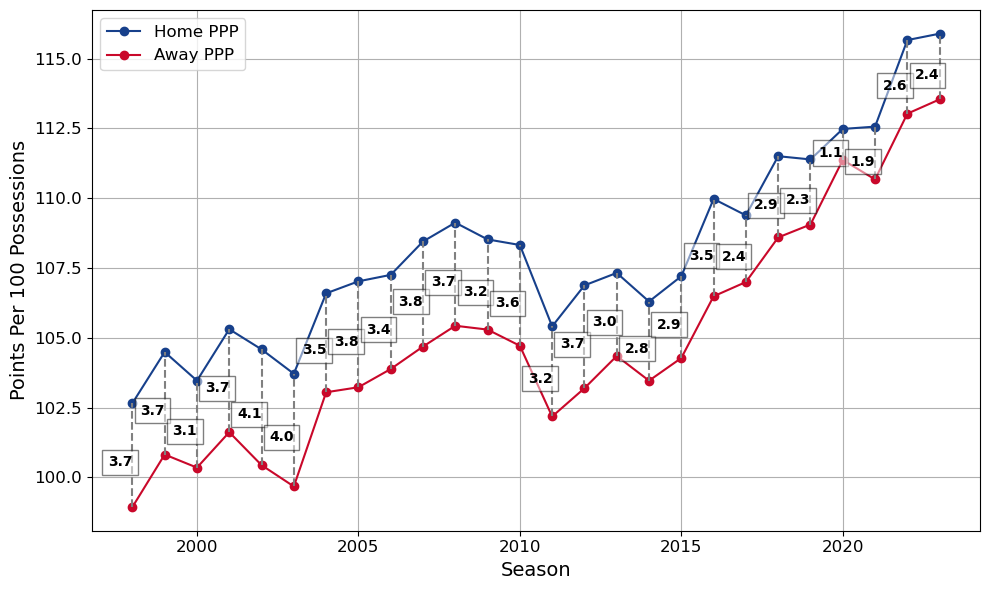

In [8]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot home and away points per possession
plt.plot(hca_pivot['season'], hca_pivot['home_ppp'], marker='o', label='Home PPP', color='#17408b')
plt.plot(hca_pivot['season'], hca_pivot['away_ppp'], marker='o', label='Away PPP', color='#c9082a')

# Highlight HCA by drawing lines and annotating the difference
for i, row in hca_pivot.iterrows():
    plt.plot([row['season'], row['season']], [row['away_ppp'], row['home_ppp']], color='gray', linestyle='--')
    plt.text(row['season'], (row['away_ppp'] + row['home_ppp']) / 2.01, f"{row['hca_advantage']*100:.1f}", 
             ha='right', va='bottom', fontsize=10, fontweight='bold', color='black', bbox=dict(facecolor='white',alpha=0.5))

# Customize the plot
plt.xlabel('Season', fontsize=14)
plt.ylabel('Points Per 100 Possessions', fontsize=14)
# plt.title('Home vs Away Points Per 100 Possessions')
plt.legend(fontsize=12)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()

plt.show()

In [9]:
# get it for the train data as well to use for v0 and v1
hca_train_df = train_df.groupby(['season','game','game_number','home_team','away_team','game_possession','home_possession'])['points'].sum().reset_index()

hca_train_agg = hca_train_df.groupby(['season','home_possession']).agg(
    possessions=('game_possession', 'size'),
    points=('points', 'sum')
).reset_index()
hca_train_agg['ppp'] = hca_train_agg['points'] / hca_train_agg['possessions']

hca_train_pivot = hca_train_agg.pivot_table(index=['season'], columns='home_possession', values=['ppp']).reset_index()
hca_train_pivot.columns.name = None
hca_train_pivot.columns = ['season', 'away_ppp', 'home_ppp']
hca_train_pivot['hca_advantage'] = hca_train_pivot['home_ppp'] - hca_train_pivot['away_ppp']

In [10]:
# Create the train_hca lookup dictionary
train_hca = hca_train_pivot.set_index('season')['hca_advantage'].to_dict()

# Function to get hca_advantage from the dictionary
def get_hca_advantage(season):
    return train_hca.get(season, None)  # Return None if season is not found

### v0: predict 1 point for every possession

In [11]:
test_df0 = test_df.copy()

In [12]:
# aggregate the data
test_agg0 = test_df0.groupby(['season','game','home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    pred_points=('game_possession', 'nunique')
).reset_index()

In [13]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot0 = test_agg0.pivot_table(index=['season', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

# Rename columns
test_pivot0.columns.name = None
test_pivot0.columns = ['season', 'game', 'away_points', 'home_points', 'away_pred_points', 'home_pred_points']

# Create MOV columns
test_pivot0['hca_advantage'] = test_pivot0['season'].apply(get_hca_advantage)
test_pivot0['mov'] = test_pivot0['home_points'] - test_pivot0['away_points']
test_pivot0['pred_mov'] = (test_pivot0['home_pred_points']*(test_pivot0['hca_advantage']+1)) - test_pivot0['away_pred_points']

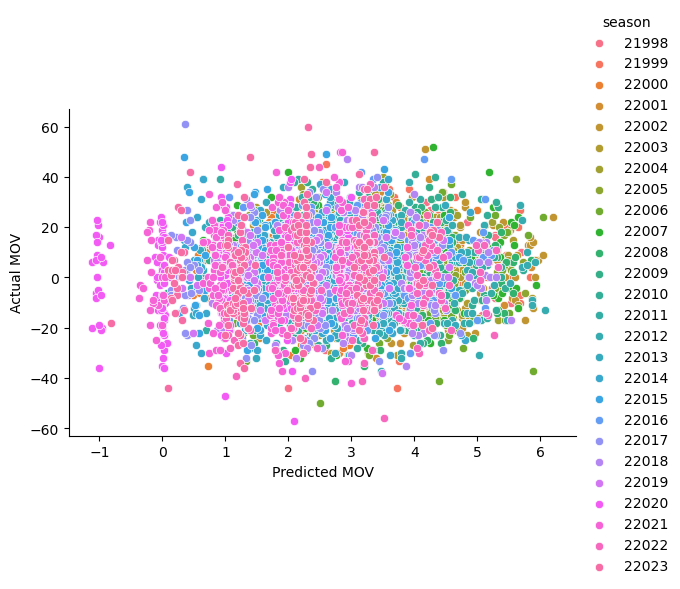

In [14]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot0, hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
plt.show()

In [15]:
# Group by 'alpha' and 'season' and calculate error metrics
error_metrics0 = test_pivot0.groupby(['season']).apply(calculate_error_metrics).reset_index()

In [16]:
# Aggregate the data
error_metrics_agg_0 = pd.DataFrame({
    'seasons': [error_metrics0['season'].nunique()],
    'avg_MAPE': [error_metrics0['MAPE'].mean()],
    'avg_RMSE': [error_metrics0['RMSE'].mean()],
    'avg_R_squared': [error_metrics0['R_squared'].mean()]
})

error_metrics_agg_0

seasons      avg_MAPE   avg_RMSE  avg_R_squared
0       26  7.187560e+14  13.718491      -0.004421

In [17]:
# Determine actual and predicted winners
test_pivot0['actual_winner'] = test_pivot0['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot0['predicted_winner'] = test_pivot0['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot0['correct_prediction'] = test_pivot0['actual_winner'] == test_pivot0['predicted_winner']
test_pivot0['league'] = 'NBA'

# Group by alpha and season and calculate summary statistics
pred_summary0 = test_pivot0.groupby(['league']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')
).reset_index()

# Calculate the percentage of correct predictions
pred_summary0['percent_correct'] = (pred_summary0['correct_predictions'] / pred_summary0['total_games']) * 100

pred_summary0

league  total_games  correct_predictions  percent_correct
0    NBA         5991                 3361        56.100818

### v1: Use raw player +/- to predict - should have significant noise

In [18]:
train_df1 = train_df.copy()
test_df1 = test_df.copy()

In [19]:
# Initialize the player stats dictionary
player_plus_minus = {}

# Function to update player stats
def update_player_plus_minus(row):
    season = row['season']
    players = row['players']
    home_possession = row['home_possession']
    points = row['points']

    # Split players into home and away
    home_players = players[:5]
    away_players = players[5:]

    # Update stats for home and away players
    for player in home_players:
        if player not in player_plus_minus:
            player_plus_minus[player] = {'seasons': {}}
        if season not in player_plus_minus[player]['seasons']:
            player_plus_minus[player]['seasons'][season] = {'off_possessions': 0, 'off_points': 0, 'def_possessions': 0, 'def_points': 0}

        if home_possession == 1:
            player_plus_minus[player]['seasons'][season]['off_possessions'] += 1
            player_plus_minus[player]['seasons'][season]['off_points'] += points
        else:
            player_plus_minus[player]['seasons'][season]['def_possessions'] += 1
            player_plus_minus[player]['seasons'][season]['def_points'] += points

    for player in away_players:
        if player not in player_plus_minus:
            player_plus_minus[player] = {'seasons': {}}
        if season not in player_plus_minus[player]['seasons']:
            player_plus_minus[player]['seasons'][season] = {'off_possessions': 0, 'off_points': 0, 'def_possessions': 0, 'def_points': 0}

        if home_possession == 0:
            player_plus_minus[player]['seasons'][season]['off_possessions'] += 1
            player_plus_minus[player]['seasons'][season]['off_points'] += points
        else:
            player_plus_minus[player]['seasons'][season]['def_possessions'] += 1
            player_plus_minus[player]['seasons'][season]['def_points'] += points

# Apply the function to each row
train_df1.apply(update_player_plus_minus, axis=1)

# Calculate offensive and defensive points per possession
for player, stats in player_plus_minus.items():
    for season, season_stats in stats['seasons'].items():
        season_stats['off_points_per_possession'] = (
            season_stats['off_points'] / season_stats['off_possessions']
            if season_stats['off_possessions'] > 0 else 0
        )
        season_stats['def_points_per_possession'] = (
            season_stats['def_points'] / season_stats['def_possessions']
            if season_stats['def_possessions'] > 0 else 0
        )

In [20]:
# Function to predict possession outcome with safe averaging
def predict_possession_outcome(row):
    season = row['season']
    players = row['players']
    home_possession = row['home_possession']
    
    home_players = players[:5]
    away_players = players[5:]
    
    if home_possession == 1:
        # Calculate home offensive points per possession
        home_off_ppp_values = [
            player_plus_minus[player]['seasons'][season]['off_points_per_possession']
            for player in home_players
            if player in player_plus_minus and season in player_plus_minus[player]['seasons']
        ]
        home_off_ppp = sum(home_off_ppp_values) / len(home_off_ppp_values) if home_off_ppp_values else 1
        
        # Calculate away defensive points per possession
        away_def_ppp_values = [
            player_plus_minus[player]['seasons'][season]['def_points_per_possession']
            for player in away_players
            if player in player_plus_minus and season in player_plus_minus[player]['seasons']
        ]
        away_def_ppp = sum(away_def_ppp_values) / len(away_def_ppp_values) if away_def_ppp_values else 1
        
        predicted_diff = home_off_ppp - away_def_ppp
    else:
        # Calculate away offensive points per possession
        away_off_ppp_values = [
            player_plus_minus[player]['seasons'][season]['off_points_per_possession']
            for player in away_players
            if player in player_plus_minus and season in player_plus_minus[player]['seasons']
        ]
        away_off_ppp = sum(away_off_ppp_values) / len(away_off_ppp_values) if away_off_ppp_values else 1
        
        # Calculate home defensive points per possession
        home_def_ppp_values = [
            player_plus_minus[player]['seasons'][season]['def_points_per_possession']
            for player in home_players
            if player in player_plus_minus and season in player_plus_minus[player]['seasons']
        ]
        home_def_ppp = sum(home_def_ppp_values) / len(home_def_ppp_values) if home_def_ppp_values else 1
        
        predicted_diff = away_off_ppp - home_def_ppp
    
    return predicted_diff

# Apply the prediction function to the test DataFrame
test_df1['predicted_diff'] = test_df1.apply(predict_possession_outcome, axis=1)

In [21]:
# aggregate the data
test_agg1 = test_df1.groupby(['season','game','home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    predicted_diff=('predicted_diff', 'sum')
).reset_index()

In [22]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot1 = test_agg1.pivot_table(index=['season', 'game'], columns='home_possession', values=['points', 'predicted_diff']).reset_index()

# Rename columns
test_pivot1.columns.name = None
test_pivot1.columns = ['season', 'game', 'away_points', 'home_points', 'away_pred_diff', 'home_pred_diff']

# Create MOV columns
test_pivot1['hca_advantage'] = test_pivot1['season'].apply(get_hca_advantage)
test_pivot1['mov'] = test_pivot1['home_points'] - test_pivot1['away_points']
test_pivot1['pred_mov'] = (test_pivot1['home_pred_diff']*(test_pivot1['hca_advantage']+1)) - test_pivot1['away_pred_diff']

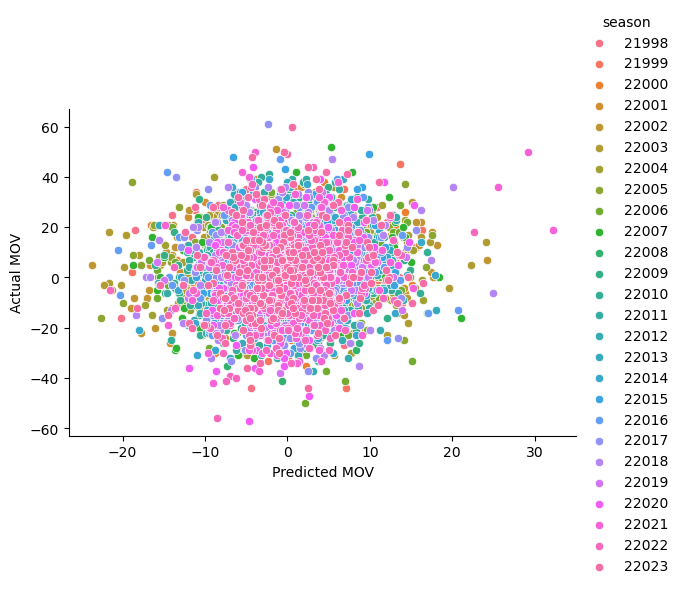

In [23]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot1, hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
plt.show()

In [24]:
# Group by 'alpha' and 'season' and calculate error metrics
error_metrics1 = test_pivot1.groupby(['season']).apply(calculate_error_metrics).reset_index()

In [25]:
# Aggregate the data
error_metrics_agg_1 = pd.DataFrame({
    'seasons': [error_metrics1['season'].nunique()],
    'avg_MAPE': [error_metrics1['MAPE'].mean()],
    'avg_RMSE': [error_metrics1['RMSE'].mean()],
    'avg_R_squared': [error_metrics1['R_squared'].mean()]
})

error_metrics_agg_1

seasons      avg_MAPE   avg_RMSE  avg_R_squared
0       26  1.337047e+15  14.824777      -0.184755

In [26]:
# Determine actual and predicted winners
test_pivot1['actual_winner'] = test_pivot1['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot1['predicted_winner'] = test_pivot1['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot1['correct_prediction'] = test_pivot1['actual_winner'] == test_pivot1['predicted_winner']
test_pivot1['league'] = 'NBA'

# Group by alpha and season and calculate summary statistics
pred_summary1 = test_pivot1.groupby(['league']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')
).reset_index()

# Calculate the percentage of correct predictions
pred_summary1['percent_correct'] = (pred_summary1['correct_predictions'] / pred_summary1['total_games']) * 100

pred_summary1

league  total_games  correct_predictions  percent_correct
0    NBA         5991                 3125        52.161576

### v2:Predict MOV using ridge regression to calculate Player RAPM and sum up at the lineup level

In [27]:
# Create final table
player_rapm = pd.DataFrame()
player_rapm_summary = pd.DataFrame()
season_averages = {}
hca_averages = {}

In [28]:
all_seasons = range(min_season,max_season+1)

for current_season in all_seasons:
    print(current_season)
    # get the years that are needed for this based on the current year and the number of years using for RAPM
    relevant_years = set(range(current_season-years_of_data+1,current_season+1))
    df = train_df[train_df['season'].isin(relevant_years)].reset_index(drop=True)
    # Get a list of all players
    all_players = set([player for sublist in df['players'] for player in sublist])
    # Initialize an empty dictionary
    player_to_col = {}
    # Initialize a counter
    counter = 0
    # Iterate through each player ID in the set
    for player_id in all_players:
        # Create keys with '_off' and '_def' suffixes and assign the counter value
        player_to_col[f"{player_id}_off"] = counter
        counter += 1
        player_to_col[f"{player_id}_def"] = counter
        counter += 1
    col_to_player = {value: key for key, value in player_to_col.items()}
    # group the dataframe in case there are any possessions not fully summed up
    df['players'] = df['players'].apply(tuple)
    
    # Initialize sparse matrix and response vector
    X = lil_matrix((len(df), len(player_to_col)))
    y = np.zeros(len(df))
    sample_weights = []
    
    # Populate the matrix and vectors - just go through the home data first
    for idx, row in df.iterrows():
        # for each row we need to take the home and away data and find both of their offensive and defensive output
        home_possession = row['home_possession']
        points = row['points']
        season = row['season']

        if home_possession:
            off_lineup = row['players'][:5]
            def_lineup = row['players'][5:]
        else:
            off_lineup = row['players'][5:]
            def_lineup = row['players'][:5]
        for player in off_lineup:
            X[idx, player_to_col[f"{player}_off"]] = 1 # set the player on offense = 1 in the matrix
        for player in def_lineup:
            X[idx, player_to_col[f"{player}_def"]] = -1
        y[idx] = points
        sample_weights.append(1.0 - 0.1 * (current_season-season))

    y_av = np.average(y, weights=sample_weights) # average points per possession
    
    # Perform cross-validation for Ridge
    ridge = Ridge()
    ridge_cv = GridSearchCV(ridge, ridge_params, scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)
    ridge_cv.fit(X.tocsr(), y - y_av, sample_weight=sample_weights)
  
    # Extract results for all parameter combinations for Ridge
    ridge_results_df = pd.DataFrame(ridge_cv.cv_results_)
    ridge_results_summary = ridge_results_df[['param_alpha', 'mean_test_score', 'std_test_score']].copy()
    ridge_results_summary.loc[:, 'mean_test_rmse'] = -ridge_results_summary['mean_test_score']
    ridge_results_summary.loc[:, 'std_test_rmse'] = ridge_results_summary['std_test_score']

    # Add a model identifier to each DataFrame
    ridge_results_summary['season'] = current_season
    player_rapm_summary = pd.concat([player_rapm_summary,ridge_results_summary], ignore_index=True)
    
    # stort the season averages
    season_averages[current_season] = y_av
    
    # Initialize list to store results for each hyperparameter combination
    results = []
    hca_averages[current_season] = {}
    
    # Iterate over each parameter combination
    for idx, params in enumerate(ridge_cv.cv_results_['params']):
        # Extract the corresponding coefficients
        ridge_model = Ridge(alpha=params['alpha'])
        ridge_model.fit(X, y - y_av, sample_weight=sample_weights)
        beta_ridge = ridge_model.coef_
        hca_ridge = ridge_model.intercept_*-1
        
        hca_averages[current_season][params['alpha']] = hca_ridge

        # Store results for each coefficient
        for i in range(len(beta_ridge)):
            player_id, type_ = col_to_player[i].rsplit('_', 1)
            results.append({
                'player_id': player_id,
                'season': current_season,
                'years_of_data': years_of_data,
                'type': type_,
                'value': beta_ridge[i],
                'alpha': params['alpha']
            })

    # Convert results to a DataFrame
    df_results = pd.DataFrame(results)

    # Pivot the DataFrame to separate orapm and drapm
    df_pivot = df_results.pivot_table(index=['player_id', 'season', 'years_of_data', 'alpha'], columns='type', values='value').reset_index()

    # Rename columns
    df_pivot.columns.name = None
    df_pivot.columns = ['player_id', 'season', 'years_of_data', 'alpha', 'drapm', 'orapm']

    # Add player names using the dictionary
    df_pivot['player_name'] = df_pivot['player_id'].astype(int).map(nba_players_dict)

    # Calculate rapm
    df_pivot['rapm'] = df_pivot['orapm'] + df_pivot['drapm']
    
    # Append this to the master table
    player_rapm = pd.concat([player_rapm, df_pivot], ignore_index=True)

player_rapm['player_id'] = player_rapm['player_id'].astype(int)

21998
21999
22000
22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023


In [29]:
player_rapm_summary.sort_values(by='mean_test_rmse', ascending=True)

param_alpha  mean_test_score  std_test_score  mean_test_rmse  \
12         2000        -1.039701        0.006548        1.039701   
11         1500        -1.039722        0.006529        1.039722   
13         3000        -1.039727        0.006571        1.039727   
10         1000        -1.039815        0.006497        1.039815   
14         5000        -1.039831        0.006592        1.039831   
..          ...              ...             ...             ...   
402          10        -1.155525        0.005167        1.155525   
353           1        -1.155925        0.003986        1.155925   
401           1        -1.156550        0.006095        1.156550   
352           0        -1.156807        0.004212        1.156807   
400           0        -1.157168        0.006595        1.157168   

     std_test_rmse  season  
12        0.006548   21998  
11        0.006529   21998  
13        0.006571   21998  
10        0.006497   21998  
14        0.006592   21998  
..             ...     ...  
402       0.005167   22023  
353       0.003986   22020  
401       0.006095   22023  
352       0.004212   22020  
400       0.006595   22023  

[416 rows x 6 columns]

In [30]:
best_params_per_season2 = player_rapm_summary.loc[player_rapm_summary.groupby('season')['mean_test_rmse'].idxmin()]

# Group by model, param_alpha, and param_l1_ratio
aggregated_data2 = player_rapm_summary.groupby(['param_alpha']).agg(
    unique_seasons=('season', 'nunique'),
    avg_mean_test_rmse=('mean_test_rmse', 'mean'),
    avg_std_test_rmse=('std_test_rmse', 'mean')
).reset_index()

# Sort by minimum mean_test_rmse
sorted_aggregated_data2 = aggregated_data2.sort_values(by='avg_mean_test_rmse')

In [31]:
best_params_per_season2

param_alpha  mean_test_score  std_test_score  mean_test_rmse  \
12         2000        -1.039701        0.006548        1.039701   
29         3000        -1.048060        0.004866        1.048060   
44         2000        -1.051805        0.005771        1.051805   
60         2000        -1.060856        0.004539        1.060856   
76         2000        -1.057163        0.007253        1.057163   
92         2000        -1.056666        0.005795        1.056666   
109        3000        -1.060820        0.005625        1.060820   
124        2000        -1.062001        0.004269        1.062001   
140        2000        -1.069500        0.004121        1.069500   
156        2000        -1.076247        0.003582        1.076247   
172        2000        -1.080837        0.005421        1.080837   
189        3000        -1.076030        0.005285        1.076030   
205        3000        -1.077585        0.003555        1.077585   
220        2000        -1.069227        0.005353        1.069227   
237        3000        -1.082095        0.004299        1.082095   
252        2000        -1.086707        0.003993        1.086707   
269        3000        -1.087706        0.002113        1.087706   
285        3000        -1.093265        0.003848        1.093265   
301        3000        -1.113338        0.006381        1.113338   
317        3000        -1.125237        0.004945        1.125237   
333        3000        -1.130823        0.005055        1.130823   
349        3000        -1.142090        0.006478        1.142090   
365        3000        -1.151656        0.004595        1.151656   
381        3000        -1.148635        0.003546        1.148635   
398        5000        -1.145803        0.003080        1.145803   
413        3000        -1.152379        0.004622        1.152379   

     std_test_rmse  season  
12        0.006548   21998  
29        0.004866   21999  
44        0.005771   22000  
60        0.004539   22001  
76        0.007253   22002  
92        0.005795   22003  
109       0.005625   22004  
124       0.004269   22005  
140       0.004121   22006  
156       0.003582   22007  
172       0.005421   22008  
189       0.005285   22009  
205       0.003555   22010  
220       0.005353   22011  
237       0.004299   22012  
252       0.003993   22013  
269       0.002113   22014  
285       0.003848   22015  
301       0.006381   22016  
317       0.004945   22017  
333       0.005055   22018  
349       0.006478   22019  
365       0.004595   22020  
381       0.003546   22021  
398       0.003080   22022  
413       0.004622   22023

In [32]:
sorted_aggregated_data2

param_alpha  unique_seasons  avg_mean_test_rmse  avg_std_test_rmse
13         3000              26            1.090244           0.004804
12         2000              26            1.090258           0.004804
14         5000              26            1.090295           0.004807
11         1500              26            1.090302           0.004804
10         1000              26            1.090415           0.004806
15        10000              26            1.090453           0.004814
9           500              26            1.090733           0.004810
8           250              26            1.091151           0.004814
7           150              26            1.091476           0.004816
6           100              26            1.091724           0.004818
5            75              26            1.091889           0.004819
4            50              26            1.092104           0.004823
3            25              26            1.092422           0.004832
2            10              26            1.092759           0.004855
1             1              26            1.093326           0.004939
0             0              26            1.093601           0.005061

In [33]:
# Precompute RAPM dictionaries
rapm_dicts = {}
for alpha in ridge_params['alpha']:
    rapm_dicts[alpha] = {
        'orapm': player_rapm[player_rapm['alpha'] == alpha].set_index(['season', 'player_id'])['orapm'].to_dict(),
        'drapm': player_rapm[player_rapm['alpha'] == alpha].set_index(['season', 'player_id'])['drapm'].to_dict()
    }

In [34]:
# Function to calculate RAPM using precomputed dictionaries
def calculate_possession_rapm(season, home_lineup, away_lineup, home_possession, alpha, rapm_dicts):
    orapm_dict = rapm_dicts[alpha]['orapm']
    drapm_dict = rapm_dicts[alpha]['drapm']
    
    if home_possession == 1:
        home_orapm = sum(orapm_dict.get((season, player), 0) for player in home_lineup)
        away_drapm = sum(drapm_dict.get((season, player), 0) for player in away_lineup)
        return home_orapm - away_drapm
    else:
        home_drapm = sum(drapm_dict.get((season, player), 0) for player in home_lineup)
        away_orapm = sum(orapm_dict.get((season, player), 0) for player in away_lineup)
        return away_orapm - home_drapm

In [35]:
test_df2 = test_df.copy()

In [36]:
test_df2['home_lineup'] = test_df2['players'].apply(lambda x: x[:5])
test_df2['away_lineup'] = test_df2['players'].apply(lambda x: x[5:])

# Calculate RAPM for each alpha and store in separate columns
for alpha in ridge_params['alpha']:
    print(alpha)
    test_df2[f'rapm_{alpha}'] = test_df2.apply(
        lambda row: calculate_possession_rapm(
            row['season'], row['home_lineup'], row['away_lineup'], row['home_possession'], alpha, rapm_dicts
        ), axis=1
    )

0
1
10
25
50
75
100
150
250
500
1000
1500
2000
3000
5000
10000


In [37]:
# Melt the DataFrame to long format
rapm_columns = [f'rapm_{alpha}' for alpha in ridge_params['alpha']]
test_df2_long = test_df2.melt(id_vars=['season', 'game', 'home_possession', 'game_possession', 'points'],
                            value_vars=rapm_columns,
                            var_name='alpha',
                            value_name='rapm')

# Extract alpha values from column names
test_df2_long['alpha'] = test_df2_long['alpha'].str.extract('(\d+)').astype(int)

In [38]:
test_agg2 = test_df2_long.groupby(['alpha','season','game','home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    rapm=('rapm', 'sum')
).reset_index()

In [39]:
def get_y_av(season):
    return season_averages[season]

def get_hca(season, alpha):
    return hca_averages[season][alpha]

test_agg2['y_av'] = test_agg2.apply(lambda row: get_y_av(row['season']), axis=1)
test_agg2['hca'] = test_agg2.apply(lambda row: get_hca(row['season'], row['alpha']), axis=1)

In [40]:
if home_possession==1:
    test_agg2['pred_points'] = (test_agg2['possessions']*test_agg2['y_av'])+((test_agg2['possessions']*test_agg2['hca'])/2)+test_agg2['rapm']
else:
    test_agg2['pred_points'] = (test_agg2['possessions']*test_agg2['y_av'])-((test_agg2['possessions']*test_agg2['hca'])/2)+test_agg2['rapm']

In [41]:
test_agg2[test_agg2['game']=='0022301226']

alpha  season        game  home_possession  possessions  points  \
11972       0   22023  0022301226                0          103     125   
11973       0   22023  0022301226                1          104     112   
23954       1   22023  0022301226                0          103     125   
23955       1   22023  0022301226                1          104     112   
35936      10   22023  0022301226                0          103     125   
35937      10   22023  0022301226                1          104     112   
47918      25   22023  0022301226                0          103     125   
47919      25   22023  0022301226                1          104     112   
59900      50   22023  0022301226                0          103     125   
59901      50   22023  0022301226                1          104     112   
71882      75   22023  0022301226                0          103     125   
71883      75   22023  0022301226                1          104     112   
83864     100   22023  0022301226                0          103     125   
83865     100   22023  0022301226                1          104     112   
95846     150   22023  0022301226                0          103     125   
95847     150   22023  0022301226                1          104     112   
107828    250   22023  0022301226                0          103     125   
107829    250   22023  0022301226                1          104     112   
119810    500   22023  0022301226                0          103     125   
119811    500   22023  0022301226                1          104     112   
131792   1000   22023  0022301226                0          103     125   
131793   1000   22023  0022301226                1          104     112   
143774   1500   22023  0022301226                0          103     125   
143775   1500   22023  0022301226                1          104     112   
155756   2000   22023  0022301226                0          103     125   
155757   2000   22023  0022301226                1          104     112   
167738   3000   22023  0022301226                0          103     125   
167739   3000   22023  0022301226                1          104     112   
179720   5000   22023  0022301226                0          103     125   
179721   5000   22023  0022301226                1          104     112   
191702  10000   22023  0022301226                0          103     125   
191703  10000   22023  0022301226                1          104     112   

             rapm      y_av       hca  pred_points  
11972   14.986510  1.078242  0.041706   123.897536  
11973   -1.375005  1.078242  0.041706   108.593410  
23954   15.028383  1.078242  0.042382   123.904606  
23955   -1.320259  1.078242  0.042382   108.613015  
35936   14.584091  1.078242  0.040242   123.570498  
35937   -1.673336  1.078242  0.040242   108.371191  
47918   14.127159  1.078242  0.038818   123.186902  
47919   -1.919770  1.078242  0.038818   108.198806  
59900   13.558783  1.078242  0.037288   122.697310  
59901   -2.141041  1.078242  0.037288   108.057085  
71882   13.127646  1.078242  0.036163   122.324113  
71883   -2.260622  1.078242  0.036163   107.996004  
83864   12.778365  1.078242  0.035252   122.021784  
83865   -2.333732  1.078242  0.035252   107.970303  
95846   12.232256  1.078242  0.033791   121.550873  
95847   -2.404622  1.078242  0.033791   107.975340  
107828  11.456117  1.078242  0.031656   120.884734  
107829  -2.415773  1.078242  0.031656   108.075258  
119810  10.256516  1.078242  0.028228   119.861655  
119811  -2.291447  1.078242  0.028228   108.377820  
131792   8.896740  1.078242  0.024220   118.708270  
131793  -2.073809  1.078242  0.024220   108.803851  
143774   8.049891  1.078242  0.021638   117.994389  
143775  -1.952773  1.078242  0.021638   109.059147  
155756   7.434195  1.078242  0.019724   117.477271  
155757  -1.881853  1.078242  0.019724   109.229602  
167738   6.550811  1.078242  0.016956   116.736432  
167739  -1.800107  1.078242  0.016956   109.4552

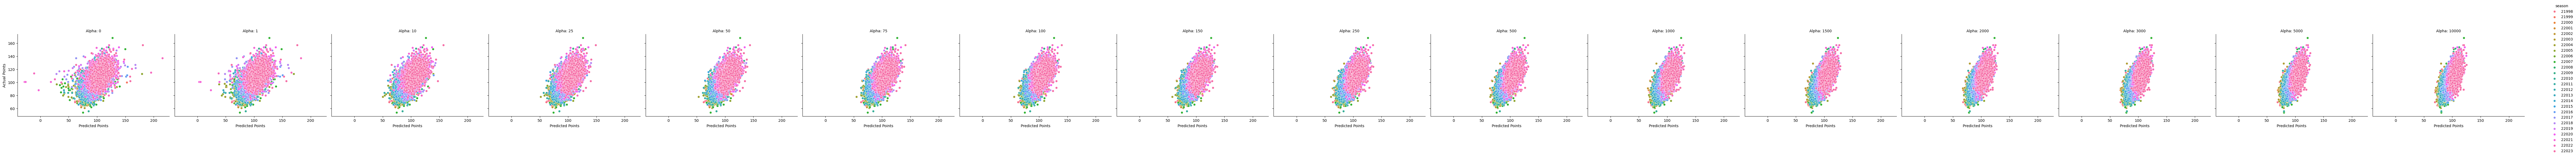

In [42]:
# Plot using seaborn
g = sns.FacetGrid(test_agg2, col='alpha', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_points', 'points')
g.add_legend()
g.set_axis_labels("Predicted Points", "Actual Points")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [43]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot2 = test_agg2.pivot_table(index=['alpha', 'season', 'y_av', 'hca', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

# Rename columns
test_pivot2.columns.name = None
test_pivot2.columns = ['alpha', 'season', 'y_av', 'hca', 'game', 'away_points', 'home_points', 'away_pred_points', 'home_pred_points']

# Create MOV columns
test_pivot2['mov'] = test_pivot2['home_points'] - test_pivot2['away_points']
test_pivot2['pred_mov'] = test_pivot2['home_pred_points'] - test_pivot2['away_pred_points']

In [44]:
test_pivot2.head(10)

alpha  season      y_av       hca        game  away_points  home_points  \
0      0   21998  0.924806  0.013979  0029800581           97           76   
1      0   21998  0.924806  0.013979  0029800582           83           86   
2      0   21998  0.924806  0.013979  0029800583           93           99   
3      0   21998  0.924806  0.013979  0029800584          103          101   
4      0   21998  0.924806  0.013979  0029800585           90           85   
5      0   21998  0.924806  0.013979  0029800586          120          104   
6      0   21998  0.924806  0.013979  0029800587          120          113   
7      0   21998  0.924806  0.013979  0029800588           67           72   
8      0   21998  0.924806  0.013979  0029800589           72           90   
9      0   21998  0.924806  0.013979  0029800590           94           87   

   away_pred_points  home_pred_points  mov   pred_mov  
0         79.258504         71.960442  -21  -7.298062  
1         78.192146         83.068931    3   4.876785  
2         82.223143         93.898482    6  11.675339  
3         87.317665         94.148838   -2   6.831173  
4         84.433005         82.152820   -5  -2.280186  
5         70.419556         92.809092  -16  22.389536  
6         96.319894         90.789047   -7  -5.530847  
7         79.285858         73.717890    5  -5.567967  
8         83.722040         71.972061   18 -11.749978  
9         83.077748         79.147694   -7  -3.930054

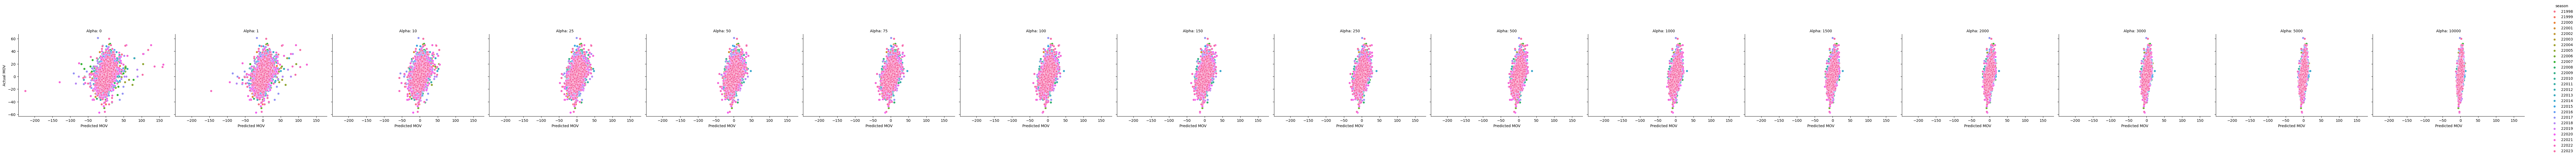

In [45]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot2, col='alpha', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [46]:
# Group by 'alpha' and 'season' and calculate error metrics
error_metrics2 = test_pivot2.groupby(['alpha', 'season']).apply(calculate_error_metrics).reset_index()

best_params_per_season2 = error_metrics2.loc[error_metrics2.groupby('season')['RMSE'].idxmin()]

best_params_per_season2

alpha  season          MAPE       RMSE  R_squared
260   1000   21998  8.181881e+14  12.305916   0.133047
261   1000   21999  1.884654e+15  12.266829   0.138835
288   1500   22000  1.186895e+15  11.280050   0.157988
289   1500   22001  5.948529e+14  12.240222   0.124567
342   3000   22002  1.083352e+15  12.589414   0.058983
343   3000   22003  1.253319e+15  12.038687   0.040330
240    500   22004  1.711060e+15  11.949237   0.140454
293   1500   22005  6.048681e+14  11.777496   0.080663
346   3000   22006  1.128758e+15  12.494566   0.128253
347   3000   22007  9.841253e+14  12.847084   0.141775
374   5000   22008  5.729292e+14  12.718171   0.080404
375   5000   22009  7.769446e+14  12.180320   0.121230
298   1500   22010  1.852704e+15  12.115258   0.172008
299   1500   22011  1.647120e+15  13.169244   0.146993
378   5000   22012  6.710278e+14  12.250624   0.107876
353   3000   22013  9.984843e+14  11.856603   0.133608
276   1000   22014  1.622860e+15  12.267542   0.242816
329   2000   22015  1.281490e+15  12.565362   0.147217
382   5000   22016  4.289654e+14  13.462330  -0.000396
357   3000   22017  1.059910e+15  13.394531   0.115754
332   2000   22018  9.883499e+14  13.280448   0.186418
229    250   22019  1.463835e+15  11.914445   0.096660
308   1500   22020  1.088469e+15  13.835067   0.227577
309   1500   22021  9.499697e+14  14.645012   0.220235
310   1500   22022  1.770484e+15  13.699661   0.180577
259    500   22023  1.418614e+15  14.172455   0.286995

In [47]:
# Group by model, param_alpha, and param_l1_ratio
error_metrics_agg2 = error_metrics2.groupby(['alpha']).agg(
    unique_seasons=('season', 'nunique'),
    avg_mape=('MAPE', 'mean'),
    avg_rmse=('RMSE', 'mean'),
    avg_r2=('R_squared', 'mean')
).sort_values(by='avg_rmse').reset_index()

error_metrics_agg2

alpha  unique_seasons      avg_mape   avg_rmse    avg_r2
0    2000              26  1.107550e+15  12.719995  0.131827
1    1500              26  1.184940e+15  12.724183  0.130901
2    3000              26  1.003119e+15  12.748785  0.128455
3    1000              26  1.294980e+15  12.766969  0.124641
4    5000              26  8.727033e+14  12.835021  0.117360
5     500              26  1.490802e+15  12.932193  0.101456
6   10000              26  6.933438e+14  13.022428  0.092284
7     250              26  1.665493e+15  13.176488  0.067161
8     150              26  1.775093e+15  13.377597  0.038596
9     100              26  1.852850e+15  13.539307  0.015374
10     75              26  1.904124e+15  13.652939 -0.001077
11     50              26  1.969471e+15  13.810955 -0.024133
12     25              26  2.066612e+15  14.078348 -0.063631
13     10              26  2.191911e+15  14.445424 -0.118991
14      1              26  2.417072e+15  15.479706 -0.284149
15      0              26  2.504070e+15  16.206660 -0.416681

In [48]:
# Determine actual and predicted winners
test_pivot2['actual_winner'] = test_pivot2['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot2['predicted_winner'] = test_pivot2['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot2['correct_prediction'] = test_pivot2['actual_winner'] == test_pivot2['predicted_winner']

# Group by alpha and season and calculate summary statistics
pred_summary2 = test_pivot2.groupby(['alpha']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')
).reset_index()

# Calculate the percentage of correct predictions
pred_summary2['percent_correct'] = (pred_summary2['correct_predictions'] / pred_summary2['total_games']) * 100

pred_summary2

alpha  total_games  correct_predictions  percent_correct
0       0         5991                 3775        63.011183
1       1         5991                 3787        63.211484
2      10         5991                 3817        63.712235
3      25         5991                 3830        63.929227
4      50         5991                 3829        63.912535
5      75         5991                 3837        64.046069
6     100         5991                 3849        64.246370
7     150         5991                 3867        64.546820
8     250         5991                 3882        64.797196
9     500         5991                 3902        65.131030
10   1000         5991                 3930        65.598398
11   1500         5991                 3946        65.865465
12   2000         5991                 3950        65.932232
13   3000         5991                 3947        65.882157
14   5000         5991                 3934        65.665164
15  10000         5991                 3911        65.281255

### v3: Build a model to predict RAPM using box score stats and use that to predict game MOV

In [49]:
# Some things to explore:
    # different model types - straight linear regression, xgboost, random forest, etc. with different hyperparameters
    # predict RAPM or predict raw plus minus?
    # I think i should attempt to predict RAPM at a low alpha and filter by certain minutes, so essentially for the box score prediction model we will have something more like an APM
    # use box score stats ideally minutes and pace adjusted
    # any advanced rate stats i could use?

In [50]:
### STATS I WANT TO INCLUDE

## boxscoreadvancedv3 - GOOD
# possessions 
# pace
# assistPercentage
# offensiveReboundPercentage
# defensiveReboundPercentage
# usagePercentage

## boxscorehustlev2 - starts in 2015
# contested2pt
# contested3pt
# deflections
# chargesDrawn
# screenAssists
# screenAssistPoints
# looseBallsRecoveredOffensive
# looseBallsRecoveredDefensive
# offensiveBoxOuts
# defensiveBoxOuts
# boxOutPlayerTeamRebounds

## boxscoreplayertrackv3 - data has a bunch of 0s until it actually starts
# speed
# distance
# reboundChancesOffensive
# reboundChancesDefensive
# touches
# secondaryAssists
# freeThrowAssists
# passes
# contestedFieldGoalsMade
# contestedFieldGoalsAttempted
# uncontestedFieldGoalsMade
# uncontestedFieldGoalsAttempted
# defendedAtRimFieldGoalsMade
# defendedatRimFieldGoalsAttempted

## boxscoretraditionalv2
# min
# fgm
# fga
# fg3m
# fg3a
# ftm
# fta
# oreb
# dreb
# ast
# stl
# blk
# to
# pf
# pts

### Convert all stats to per 100 possessions

### ADD IN 2 LEAGUEWIDE STATS FOR PACE AND PPG

In [51]:
### THIS WAS GOOD FOR GETTING SEASON LONG PLAYER STATS BUT WE NEED GAME LOGS TO GET MORE GRANULAR AND TO SPLIT FOR TRAIN/TEST

#from nba_api.stats.endpoints import playercareerstats
#from requests.exceptions import ReadTimeout
#import time

# Get all players from the player_rapm file
#all_players = set(player_rapm['player_id'])

#player_box_stats = pd.DataFrame()

# will need to repull this data - need to get data at the game log level
#for player_id in all_players:
#    stats_df = api_call_with_retries(playercareerstats.PlayerCareerStats, player_id=player_id)
#    stats_df = stats_df.get_data_frames()[0]
#    player_box_stats = pd.concat([player_box_stats, stats_df], ignore_index=True)
#    time.sleep(0.45)
    
#player_box_stats = player_box_stats[['PLAYER_ID','SEASON_ID','GP','MIN','FGM','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','AST','STL','BLK','TOV','PTS']]
#player_box_stats.columns = map(str.lower, player_stats.columns)

In [52]:
#player_box_stats = pd.read_csv("player_stats_1997_2023.csv")

# Columns to adjust
#columns_to_adjust = player_box_stats.columns[4:]  # All columns after the first 4

# Adjust columns by dividing by the 'minutes' column
#player_box_stats[columns_to_adjust] = player_box_stats[columns_to_adjust].div(player_box_stats['min'], axis=0)

# add a variable for mpg and true shooting %
#player_box_stats['mpg'] = player_box_stats['min'] / player_box_stats['gp']
#player_box_stats['ts_pct'] = player_box_stats['pts'] / (2 * (player_box_stats['fga'] + (0.44 * player_box_stats['fta'])))

# create season variable for us to actually be able to join on
#player_box_stats['season'] = player_box_stats.apply(lambda row: "2"+row['season_id'][:4], axis=1).astype(int)
#player_box_stats = player_box_stats.drop(columns=['season_id'])

# Group by 'player_id' and 'season_id' and select the row with the maximum 'min'
#player_box_stats = player_box_stats.loc[player_box_stats.groupby(['player_id', 'season'])['min'].idxmax()]

In [53]:
# build API retry function to use for every npa_api call
def api_call_with_retries(api_class, retries=3, delay=10, **kwargs):
    for attempt in range(retries):
        try:
            api_instance = api_class(**kwargs)
            return api_instance
        except ReadTimeout as e:
            print(f"ReadTimeout occurred: {e}")
            if attempt < retries - 1:
                print(f"Retrying in {delay} seconds...")
                time.sleep(delay)
            else:
                print(f"Failed to retrieve data after {retries} attempts.")
                return None

#### Get box score data from nba.com

In [54]:
#all_games = set(lineups_df['game'])

#advanced_stats = pd.DataFrame()

#for game_id in all_games:
#    stats_df = api_call_with_retries(boxscoreadvancedv3.BoxScoreAdvancedV3, game_id=game_id)
#    stats_df = stats_df.get_data_frames()[0]
#    advanced_stats = pd.concat([advanced_stats, stats_df], ignore_index=True)
#    time.sleep(0.45)

#advanced_stats.to_csv('advanced_stats_game_logs_1998_2023.csv', index=False)

In [55]:
#box_score_stats = pd.DataFrame()

#counter = 0
#for game_id in all_games:
#    if counter % 1000 == 0:
#        print(counter)
#    stats_df = api_call_with_retries(boxscoretraditionalv2.BoxScoreTraditionalV2, game_id=game_id)
#    stats_df = stats_df.get_data_frames()[0]
#    box_score_stats = pd.concat([box_score_stats, stats_df], ignore_index=True)
#    counter += 1
#    time.sleep(0.45)

#box_score_stats.to_csv('box_score_game_logs_1998_2023.csv', index=False)

In [56]:
advanced_stats = pd.read_csv("advanced_stats_game_logs_1998_2023.csv")
box_score_stats = pd.read_csv("box_score_game_logs_1998_2023.csv")

In [57]:
advanced_df = advanced_stats[['gameId','personId','possessions', 'pace', 'assistPercentage', 'offensiveReboundPercentage', 'defensiveReboundPercentage', 'usagePercentage']]
box_df = box_score_stats[['GAME_ID','TEAM_ID','PLAYER_ID','MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']]

merged_df = pd.merge(box_df, advanced_df, left_on=['GAME_ID', 'PLAYER_ID'], right_on=['gameId', 'personId'])

merged_df.drop(['gameId', 'personId'], axis=1, inplace=True)

merged_df['GAME_ID'] = merged_df['GAME_ID'].apply(lambda x: f'00{x:06d}')

# Filter merged_df to include only games in train_df
season_games = train_df[['game', 'season']].drop_duplicates().reset_index(drop = True)
filtered_df = pd.merge(merged_df, season_games, left_on='GAME_ID', right_on='game', how='inner')

# Filter out players who didn't play (MIN is NaN)
filtered_df = filtered_df.dropna(subset=['MIN'])

#### Transform data and prep for modelling

In [58]:
# Aggregate data by player and season
player_stats = filtered_df.groupby(['PLAYER_ID', 'season']).agg(
    games=('GAME_ID', 'nunique'),
    possessions=('possessions', 'sum'),
    pts=('PTS', 'sum'),
    fgm=('FGM', 'sum'),
    fga=('FGA', 'sum'),
    fg3m=('FG3M', 'sum'),
    fg3a=('FG3A', 'sum'),
    ftm=('FTM', 'sum'),
    fta=('FTA', 'sum'),
    oreb=('OREB', 'sum'),
    dreb=('DREB', 'sum'),
    ast=('AST', 'sum'),
    stl=('STL', 'sum'),
    blk=('BLK', 'sum'),
    tov=('TO', 'sum'),
    pf=('PF', 'sum')
).reset_index()

# make all the columns lowercase
player_stats.columns = [x.lower() for x in player_stats.columns]

# Normalize stats per 100 possessions
player_stats['pts_per_100'] = (player_stats['pts'] / player_stats['possessions']) * 100
player_stats['fgm_per_100'] = (player_stats['fgm'] / player_stats['possessions']) * 100
player_stats['fga_per_100'] = (player_stats['fga'] / player_stats['possessions']) * 100
player_stats['fg3m_per_100'] = (player_stats['fg3m'] / player_stats['possessions']) * 100
player_stats['fg3a_per_100'] = (player_stats['fg3a'] / player_stats['possessions']) * 100
player_stats['ftm_per_100'] = (player_stats['ftm'] / player_stats['possessions']) * 100
player_stats['fta_per_100'] = (player_stats['fta'] / player_stats['possessions']) * 100
player_stats['oreb_per_100'] = (player_stats['oreb'] / player_stats['possessions']) * 100
player_stats['dreb_per_100'] = (player_stats['dreb'] / player_stats['possessions']) * 100
player_stats['ast_per_100'] = (player_stats['ast'] / player_stats['possessions']) * 100
player_stats['stl_per_100'] = (player_stats['stl'] / player_stats['possessions']) * 100
player_stats['blk_per_100'] = (player_stats['blk'] / player_stats['possessions']) * 100
player_stats['tov_per_100'] = (player_stats['tov'] / player_stats['possessions']) * 100
player_stats['pf_per_100'] = (player_stats['pf'] / player_stats['possessions']) * 100

# Standardize stats per season
season_avg = player_stats.groupby('season').agg(
    avg_pts_per_100=('pts_per_100', 'mean'),
    std_pts_per_100=('pts_per_100', 'std'),
    avg_fgm_per_100=('fgm_per_100', 'mean'),
    std_fgm_per_100=('fgm_per_100', 'std'),
    avg_fga_per_100=('fga_per_100', 'mean'),
    std_fga_per_100=('fga_per_100', 'std'),
    avg_fg3m_per_100=('fg3m_per_100', 'mean'),
    std_fg3m_per_100=('fg3m_per_100', 'std'),
    avg_fg3a_per_100=('fg3a_per_100', 'mean'),
    std_fg3a_per_100=('fg3a_per_100', 'std'),
    avg_ftm_per_100=('ftm_per_100', 'mean'),
    std_ftm_per_100=('ftm_per_100', 'std'),
    avg_fta_per_100=('fta_per_100', 'mean'),
    std_fta_per_100=('fta_per_100', 'std'),
    avg_oreb_per_100=('oreb_per_100', 'mean'),
    std_oreb_per_100=('oreb_per_100', 'std'),
    avg_dreb_per_100=('dreb_per_100', 'mean'),
    std_dreb_per_100=('dreb_per_100', 'std'),
    avg_ast_per_100=('ast_per_100', 'mean'),
    std_ast_per_100=('ast_per_100', 'std'),
    avg_stl_per_100=('stl_per_100', 'mean'),
    std_stl_per_100=('stl_per_100', 'std'),
    avg_blk_per_100=('blk_per_100', 'mean'),
    std_blk_per_100=('blk_per_100', 'std'),
    avg_tov_per_100=('tov_per_100', 'mean'),
    std_tov_per_100=('tov_per_100', 'std'),
    avg_pf_per_100=('pf_per_100', 'mean'),
    std_pf_per_100=('pf_per_100', 'std')
).reset_index()

player_stats = player_stats.merge(season_avg, on='season', how='left')
player_stats['z_pts'] = (player_stats['pts_per_100'] - player_stats['avg_pts_per_100']) / player_stats['std_pts_per_100']
player_stats['z_fgm'] = (player_stats['fgm_per_100'] - player_stats['avg_fgm_per_100']) / player_stats['std_fgm_per_100']
player_stats['z_fga'] = (player_stats['fga_per_100'] - player_stats['avg_fga_per_100']) / player_stats['std_fga_per_100']
player_stats['z_fg3m'] = (player_stats['fg3m_per_100'] - player_stats['avg_fg3m_per_100']) / player_stats['std_fg3m_per_100']
player_stats['z_fg3a'] = (player_stats['fg3a_per_100'] - player_stats['avg_fg3a_per_100']) / player_stats['std_fg3a_per_100']
player_stats['z_ftm'] = (player_stats['ftm_per_100'] - player_stats['avg_ftm_per_100']) / player_stats['std_ftm_per_100']
player_stats['z_fta'] = (player_stats['fta_per_100'] - player_stats['avg_fta_per_100']) / player_stats['std_fta_per_100']
player_stats['z_oreb'] = (player_stats['oreb_per_100'] - player_stats['avg_oreb_per_100']) / player_stats['std_oreb_per_100']
player_stats['z_dreb'] = (player_stats['dreb_per_100'] - player_stats['avg_dreb_per_100']) / player_stats['std_dreb_per_100']
player_stats['z_ast'] = (player_stats['ast_per_100'] - player_stats['avg_ast_per_100']) / player_stats['std_ast_per_100']
player_stats['z_stl'] = (player_stats['stl_per_100'] - player_stats['avg_stl_per_100']) / player_stats['std_stl_per_100']
player_stats['z_blk'] = (player_stats['blk_per_100'] - player_stats['avg_blk_per_100']) / player_stats['std_blk_per_100']
player_stats['z_tov'] = (player_stats['tov_per_100'] - player_stats['avg_tov_per_100']) / player_stats['std_tov_per_100']
player_stats['z_pf'] = (player_stats['pf_per_100'] - player_stats['avg_pf_per_100']) / player_stats['std_pf_per_100']

In [33]:
# Initialize an empty DataFrame to store results
player_bpm = pd.DataFrame()

# Loop over each combination of alpha and min_threshold
for alpha in ridge_params['alpha']:
    for poss in possession_thresholds:
        # Merge DataFrames on player_id and season
        merged_df = pd.merge(player_stats, player_rapm[player_rapm['alpha'] == alpha], on=['player_id', 'season'])

        # Filter for seasons with at least min_threshold minutes played
        merged_df = merged_df[merged_df['possessions'] >= poss].reset_index(drop=True)

        # Select features and target
        bpm_features = merged_df[['z_pts','z_fgm','z_fga','z_fg3m','z_fg3a','z_ftm','z_fta','z_oreb','z_dreb','z_ast','z_stl','z_blk','z_tov','z_pf']]
        bpm_target = merged_df['rapm']
        
        obpm_features = merged_df[['z_pts','z_fgm','z_fga','z_fg3m','z_fg3a','z_ftm','z_fta','z_oreb','z_ast','z_tov']]
        obpm_target = merged_df['orapm']

        # Initialize linear regression model
        bpm_model = LinearRegression()
        obpm_model = LinearRegression()

        # Perform 10-fold cross-validation
        bpm_cv_scores = cross_val_score(bpm_model, bpm_features, bpm_target, cv=10, scoring='neg_root_mean_squared_error')
        bpm_cv_predictions = cross_val_predict(bpm_model, bpm_features, bpm_target, cv=10)
        
        obpm_cv_scores = cross_val_score(obpm_model, obpm_features, obpm_target, cv=10, scoring='neg_root_mean_squared_error')
        obpm_cv_predictions = cross_val_predict(obpm_model, obpm_features, obpm_target, cv=10)

        # Calculate metrics
        bpm_mse = -bpm_cv_scores.mean()
        bpm_rmse = bpm_mse ** 0.5
        bpm_r2 = r2_score(bpm_target, bpm_cv_predictions)

        obpm_mse = -obpm_cv_scores.mean()
        obpm_rmse = obpm_mse ** 0.5
        obpm_r2 = r2_score(obpm_target, obpm_cv_predictions)

        # Add results to DataFrame
        merged_df['dbpm'] = bpm_cv_predictions-obpm_cv_predictions
        merged_df['obpm'] = obpm_cv_predictions
        merged_df['bpm'] = bpm_cv_predictions
        merged_df['alpha'] = alpha
        merged_df['possession_threshold'] = poss
        merged_df['bpm_rmse'] = bpm_rmse
        merged_df['bpm_r2'] = bpm_r2
        merged_df['obpm_rmse'] = obpm_rmse
        merged_df['obpm_r2'] = obpm_r2

        # Append to results DataFrame
        player_bpm = pd.concat([player_bpm, merged_df], ignore_index=True)

In [60]:
# Precompute BPM dictionaries
bpm_dicts = {}
for alpha in ridge_params['alpha']:
    bpm_dicts[alpha] = {}
    for poss in possession_thresholds:
        bpm_dicts[alpha][poss] = {
            'obpm': player_bpm[(player_bpm['alpha'] == alpha) & (player_bpm['possession_threshold'] == poss)].set_index(['season', 'player_id'])['obpm'].to_dict(),
            'dbpm': player_bpm[(player_bpm['alpha'] == alpha) & (player_bpm['possession_threshold'] == poss)].set_index(['season', 'player_id'])['dbpm'].to_dict()
        }

In [61]:
# Function to calculate RAPM using precomputed dictionaries
def calculate_possession_bpm(season, home_lineup, away_lineup, home_possession, alpha, poss, bpm_dicts):
    obpm_dict = bpm_dicts[alpha][poss]['obpm']
    dbpm_dict = bpm_dicts[alpha][poss]['dbpm']
    
    if home_possession == 1:
        home_obpm = sum(obpm_dict.get((season, player), 0) for player in home_lineup)
        away_dbpm = sum(dbpm_dict.get((season, player), 0) for player in away_lineup)
        return home_obpm - away_dbpm
    else:
        home_dbpm = sum(dbpm_dict.get((season, player), 0) for player in home_lineup)
        away_obpm = sum(obpm_dict.get((season, player), 0) for player in away_lineup)
        return away_obpm - home_dbpm

In [62]:
test_df3 = test_df.copy()

In [63]:
test_df3['home_lineup'] = test_df3['players'].apply(lambda x: x[:5])
test_df3['away_lineup'] = test_df3['players'].apply(lambda x: x[5:])

# Calculate RAPM for each alpha and store in separate columns
for alpha in ridge_params['alpha']:
    print(alpha)
    for poss in possession_thresholds:
        test_df3[f'bpm_{alpha}_{poss}'] = test_df3.apply(
            lambda row: calculate_possession_bpm(
                row['season'], row['home_lineup'], row['away_lineup'], row['home_possession'], alpha, poss, bpm_dicts
            ), axis=1
        )

0
100
500
1000
2000


In [64]:
# Melt the DataFrame to long format
bpm_columns = [f'bpm_{alpha}_{poss}' for alpha in ridge_params['alpha'] for poss in possession_thresholds]
test_df3_long = test_df3.melt(id_vars=['season', 'game', 'home_possession', 'game_possession', 'points'],
                            value_vars=bpm_columns,
                            var_name='alpha_possession',
                            value_name='bpm')

# Use str.extract to separate the 'alpha_minute' column into 'alpha' and 'min_threshold'
test_df3_long[['alpha', 'possession_threshold']] = test_df3_long['alpha_possession'].str.extract(r'bpm_(\d+)_(\d+)')

# Convert extracted values to integers
test_df3_long['alpha'] = test_df3_long['alpha'].astype(int)
test_df3_long['possession_threshold'] = test_df3_long['possession_threshold'].astype(int)

In [65]:
test_agg3 = test_df3_long.groupby(['alpha','possession_threshold','season','game','home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    bpm=('bpm', 'sum')
).reset_index()

In [66]:
def get_y_av(season):
    return season_averages[season]

def get_hca(season, alpha):
    return hca_averages[season][alpha]

test_agg3['y_av'] = test_agg3.apply(lambda row: get_y_av(row['season']), axis=1)
test_agg3['hca'] = test_agg3.apply(lambda row: get_hca(row['season'], row['alpha']), axis=1)

In [67]:
if home_possession==1:
    test_agg3['pred_points'] = (test_agg3['possessions']*test_agg3['y_av'])+((test_agg3['possessions']*test_agg3['hca'])/2)+test_agg3['bpm']
else:
    test_agg3['pred_points'] = (test_agg3['possessions']*test_agg3['y_av'])-((test_agg3['possessions']*test_agg3['hca'])/2)+test_agg3['bpm']

In [68]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot3 = test_agg3.pivot_table(index=['alpha', 'possession_threshold', 'season', 'y_av', 'hca', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

# Rename columns
test_pivot3.columns.name = None
test_pivot3.columns = ['alpha', 'possession_threshold', 'season', 'y_av', 'hca', 'game', 'away_points', 'home_points', 'away_pred_points', 'home_pred_points']

# Create MOV columns
test_pivot3['mov'] = test_pivot3['home_points'] - test_pivot3['away_points']
test_pivot3['pred_mov'] = test_pivot3['home_pred_points'] - test_pivot3['away_pred_points']

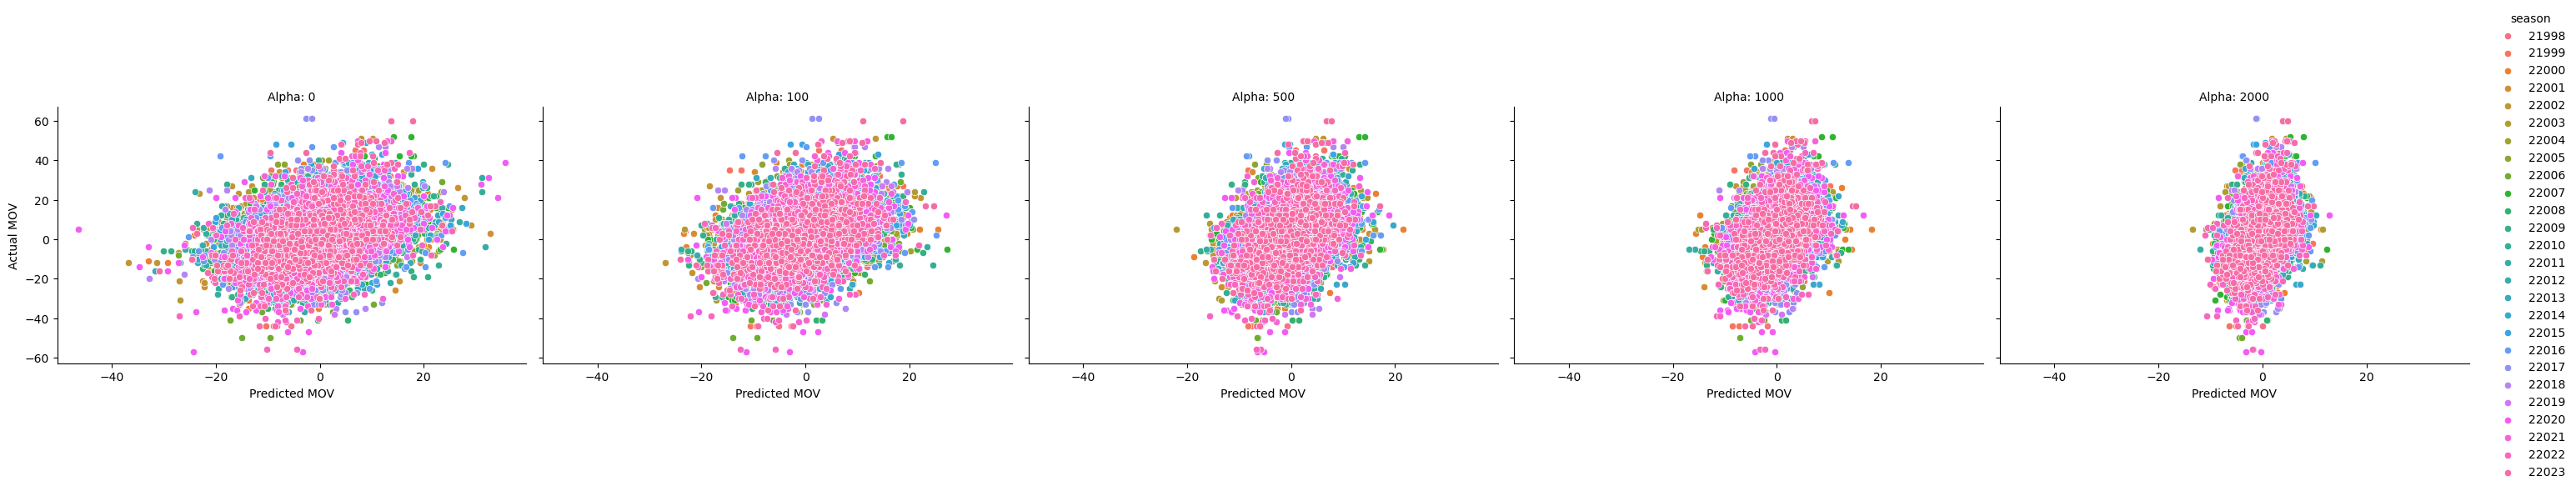

In [69]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot3, col='alpha', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [70]:
# Group by 'alpha' and 'season' and calculate error metrics
error_metrics3 = test_pivot3.groupby(['alpha', 'possession_threshold', 'season']).apply(calculate_error_metrics).reset_index()

best_params_per_season3 = error_metrics3.loc[error_metrics3.groupby('season')['RMSE'].idxmin()]

best_params_per_season3.head(10)

alpha  possession_threshold  season          MAPE       RMSE  R_squared
156   1000                   100   21998  8.105649e+14  12.818155   0.059371
105    500                   100   21999  1.220666e+15  12.671911   0.081020
236   2000                  1000   22000  8.471538e+14  12.100559   0.031037
107    500                   100   22001  8.253123e+14  12.698094   0.057847
238   2000                  1000   22002  1.004834e+15  12.872975   0.016115
187   1000                  1000   22003  9.907415e+14  12.424325  -0.022137
214   2000                   100   22004  6.534083e+14  12.552668   0.051449
85     100                  1000   22005  5.948139e+14  11.959360   0.052052
190   1000                  1000   22006  6.029727e+14  12.664145   0.104429
61     100                   100   22007  1.085529e+15  12.945149   0.128622

In [71]:
# Group by model, param_alpha, and param_l1_ratio
error_metrics_agg3 = error_metrics3.groupby(['alpha','possession_threshold']).agg(
    unique_seasons=('season', 'nunique'),
    avg_mape=('MAPE', 'mean'),
    avg_rmse=('RMSE', 'mean'),
    avg_r2=('R_squared', 'mean')
).sort_values(by='avg_rmse').reset_index()

error_metrics_agg3.head(10)

alpha  possession_threshold  unique_seasons      avg_mape   avg_rmse  \
0    500                   100              26  1.036067e+15  13.118802   
1   1000                   100              26  8.493346e+14  13.151213   
2    100                   100              26  1.387631e+15  13.226913   
3   2000                   100              26  6.235431e+14  13.280220   
4   1000                  1000              26  8.089185e+14  13.287132   
5    500                  1000              26  1.034398e+15  13.291001   
6   2000                  1000              26  6.623325e+14  13.368334   
7    100                  1000              26  1.346181e+15  13.445916   
8      0                  1000              26  1.541760e+15  13.620446   
9      0                   100              26  1.590574e+15  13.815250   

     avg_r2  
0  0.076280  
1  0.072773  
2  0.057716  
3  0.055558  
4  0.053503  
5  0.051046  
6  0.042974  
7  0.026066  
8 -0.001786  
9 -0.030250

In [72]:
# Determine actual and predicted winners
test_pivot3['actual_winner'] = test_pivot3['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot3['predicted_winner'] = test_pivot3['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot3['correct_prediction'] = test_pivot3['actual_winner'] == test_pivot3['predicted_winner']

# Group by alpha and season and calculate summary statistics
pred_summary3 = test_pivot3.groupby(['alpha','possession_threshold']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')
).reset_index()

# Calculate the percentage of correct predictions
pred_summary3['percent_correct'] = (pred_summary3['correct_predictions'] / pred_summary3['total_games']) * 100

pred_summary3.sort_values(by='percent_correct', ascending=False).reset_index(drop=True).head(10)

alpha  possession_threshold  total_games  correct_predictions  \
0    100                   100         5991                 3807   
1    500                   100         5991                 3783   
2      0                   100         5991                 3771   
3   1000                   100         5991                 3760   
4   1000                  1000         5991                 3752   
5    100                  1000         5991                 3738   
6   2000                   100         5991                 3733   
7      0                  1000         5991                 3717   
8    500                  1000         5991                 3689   
9   2000                  1000         5991                 3649   

   percent_correct  
0        63.545318  
1        63.144717  
2        62.944417  
3        62.760808  
4        62.627274  
5        62.393590  
6        62.310132  
7        62.043065  
8        61.575697  
9        60.908029

In [60]:
player_bpm[(player_bpm['player_name']=='Stephen Curry') & (player_bpm['season']==22015)].sort_values(by='bpm',ascending=False).reset_index(drop=True)

player_id  season  games  possessions     pts    fgm     fga   fg3m  \
0      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
1      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
2      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
3      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
4      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
5      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
6      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
7      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
8      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
9      201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
10     201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   
11     201939   22015     62       4532.0  1891.0  638.0  1249.0  318.0   

     fg3a    ftm  ...      obpm       bpm  possession_threshold  \
0   692.0  297.0  ...  0.126994  0.144914                  3000   
1   692.0  297.0  ...  0.128151  0.144135                   100   
2   692.0  297.0  ...  0.128523  0.142384                  1000   
3   692.0  297.0  ...  0.114460  0.125557                  3000   
4   692.0  297.0  ...  0.113937  0.121313                  1000   
5   692.0  297.0  ...  0.101281  0.109314                   100   
6   692.0  297.0  ...  0.074877  0.078502                  3000   
7   692.0  297.0  ...  0.072599  0.073680                  1000   
8   692.0  297.0  ...  0.058209  0.060192                  3000   
9   692.0  297.0  ...  0.055164  0.054934                  1000   
10  692.0  297.0  ...  0.052661  0.053407                   100   
11  692.0  297.0  ...  0.037871  0.037494                   100   

               model  bpm_rmse    bpm_r2  obpm_rmse   obpm_r2  param1  param2  
0   LinearRegression  0.051748  0.162661   0.037339  0.217741       0       0  
1   LinearRegression  0.068710  0.153628   0.049073  0.206044       0       0  
2   LinearRegression  0.053579  0.153501   0.038578  0.222705       0       0  
3   LinearRegression  0.041562  0.194007   0.029714  0.261703       0       0  
4   LinearRegression  0.042702  0.186314   0.030530  0.274100       0       0  
5   LinearRegression  0.048521  0.184768   0.034687  0.254319       0       0  
6   LinearRegression  0.022939  0.246276   0.016309  0.325879       0       0  
7   LinearRegression  0.023065  0.234540   0.016615  0.344959       0       0  
8   LinearRegression  0.016909  0.266886   0.012018  0.350270       0       0  
9   LinearRegression  0.016663  0.250829   0.012140  0.366740       0       0  
10  LinearRegression  0.022753  0.199748   0.016587  0.291372       0       0  
11  LinearRegression  0.016049  0.200013   0.011908  0.295180       0       0  

[12 rows x 91 columns]

In [59]:
from sklearn.linear_model import LinearRegression, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict, ParameterGrid
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Example parameter grids
elastic_net_params = {'alpha': [0.01, 0.05, 0.1, 0.25], 'l1_ratio': [0.01, 0.05, 0.1, 0.25]}
random_forest_params = {'max_depth': [100, 500], 'n_estimators': [1000, 2000]}
decision_tree_params = {'max_depth': [5, 50, 100]}
xgboost_params = {'max_depth': [1, 5, 10, 20], 'n_estimators': [10, 100, 250, 500]}
huber_params = {'alpha': [0.0001, 0.001, 0.01, 0.1], 'epsilon': [1.1, 1.35, 1.5, 1.75, 2.0]}

# Initialize an empty DataFrame to store results
player_bpm = pd.DataFrame()

# Loop over each combination of alpha and min_threshold
for alpha in ridge_params['alpha']:
    print(alpha)
    for poss in possession_thresholds:
        # Merge DataFrames on player_id and season
        merged_df = pd.merge(player_stats, player_rapm[player_rapm['alpha'] == alpha], on=['player_id', 'season'])

        # Filter for seasons with at least min_threshold minutes played
        merged_df = merged_df[merged_df['possessions'] >= poss].reset_index(drop=True)

        # Select features and target
        bpm_features = merged_df[['z_pts', 'z_fgm', 'z_fga', 'z_fg3m', 'z_fg3a', 'z_ftm', 'z_fta', 'z_oreb', 'z_dreb', 'z_ast', 'z_stl', 'z_blk', 'z_tov', 'z_pf']]
        bpm_target = merged_df['rapm']
        obpm_features = merged_df[['z_pts', 'z_fgm', 'z_fga', 'z_fg3m', 'z_fg3a', 'z_ftm', 'z_fta', 'z_oreb', 'z_ast', 'z_tov']]
        obpm_target = merged_df['orapm']

        # Define models and their parameter grids
        models = {
            'LinearRegression': (LinearRegression(), [{}]),  # No parameters to test
            'ElasticNet': (ElasticNet(), list(ParameterGrid(elastic_net_params))),
            # 'HuberRegressor': (HuberRegressor(), [{}]),  # No parameters to test
            'HuberRegressor': (HuberRegressor(), list(ParameterGrid(huber_params))),
            # 'RandomForest': (RandomForestRegressor(), list(ParameterGrid(random_forest_params))),
            'DecisionTree': (DecisionTreeRegressor(), list(ParameterGrid(decision_tree_params))),
            'XGBoost': (xgb.XGBRegressor(), list(ParameterGrid(xgboost_params)))
        }

        # Dictionary to store the best results for each model
        best_results = {}

        # Perform cross-validation for each model
        for model_name, (model, param_grid) in models.items():
            print(model_name)
            best_rmse = float('inf')
            best_params = None
            best_predictions = None

            for params in param_grid:
                print(params)
                model.set_params(**params)
                bpm_cv_predictions = cross_val_predict(model, bpm_features, bpm_target, cv=10)
                obpm_cv_predictions = cross_val_predict(model, obpm_features, obpm_target, cv=10)

                # Calculate metrics
                bpm_rmse = mean_squared_error(bpm_target, bpm_cv_predictions, squared=False)

                # Update best results if current rmse is better
                if bpm_rmse < best_rmse:
                    best_rmse = bpm_rmse
                    best_params = params
                    best_predictions = (bpm_cv_predictions, obpm_cv_predictions)

            # Store the best results for this model
            if best_params is not None:
                best_results[model_name] = {
                    'bpm_predictions': best_predictions[0],
                    'obpm_predictions': best_predictions[1],
                    'bpm_rmse': best_rmse,
                    'bpm_r2': r2_score(bpm_target, best_predictions[0]),
                    'obpm_rmse': mean_squared_error(obpm_target, best_predictions[1], squared=False),
                    'obpm_r2': r2_score(obpm_target, best_predictions[1]),
                    'params': best_params
                }

        # Append the best results for each model to the player_bpm DataFrame
        for model_name, result in best_results.items():
            merged_df['dbpm'] = result['bpm_predictions'] - result['obpm_predictions']
            merged_df['obpm'] = result['obpm_predictions']
            merged_df['bpm'] = result['bpm_predictions']
            merged_df['alpha'] = alpha
            merged_df['possession_threshold'] = poss
            merged_df['model'] = model_name
            merged_df['bpm_rmse'] = result['bpm_rmse']
            merged_df['bpm_r2'] = result['bpm_r2']
            merged_df['obpm_rmse'] = result['obpm_rmse']
            merged_df['obpm_r2'] = result['obpm_r2']
            merged_df['param1'] = result['params'].get('alpha', result['params'].get('max_depth', 0))
            merged_df['param2'] = result['params'].get('l1_ratio', result['params'].get('n_estimators', result['params'].get('epsilon', 0)))

            player_bpm = pd.concat([player_bpm, merged_df], ignore_index=True)

0
LinearRegression
{}
ElasticNet
{'alpha': 0.01, 'l1_ratio': 0.01}
{'alpha': 0.01, 'l1_ratio': 0.05}
{'alpha': 0.01, 'l1_ratio': 0.1}
{'alpha': 0.01, 'l1_ratio': 0.25}
{'alpha': 0.05, 'l1_ratio': 0.01}
{'alpha': 0.05, 'l1_ratio': 0.05}
{'alpha': 0.05, 'l1_ratio': 0.1}
{'alpha': 0.05, 'l1_ratio': 0.25}
{'alpha': 0.1, 'l1_ratio': 0.01}
{'alpha': 0.1, 'l1_ratio': 0.05}
{'alpha': 0.1, 'l1_ratio': 0.1}
{'alpha': 0.1, 'l1_ratio': 0.25}
{'alpha': 0.25, 'l1_ratio': 0.01}
{'alpha': 0.25, 'l1_ratio': 0.05}
{'alpha': 0.25, 'l1_ratio': 0.1}
{'alpha': 0.25, 'l1_ratio': 0.25}
HuberRegressor
{'alpha': 0.0001, 'epsilon': 1.1}
{'alpha': 0.0001, 'epsilon': 1.35}
{'alpha': 0.0001, 'epsilon': 1.5}
{'alpha': 0.0001, 'epsilon': 1.75}
{'alpha': 0.0001, 'epsilon': 2.0}
{'alpha': 0.001, 'epsilon': 1.1}
{'alpha': 0.001, 'epsilon': 1.35}
{'alpha': 0.001, 'epsilon': 1.5}
{'alpha': 0.001, 'epsilon': 1.75}
{'alpha': 0.001, 'epsilon': 2.0}
{'alpha': 0.01, 'epsilon': 1.1}
{'alpha': 0.01, 'epsilon': 1.35}
{'alpha': 0.

In [60]:
best_params_df = player_bpm.loc[player_bpm.groupby('model')['bpm_rmse'].idxmin()]
best_params_dict = {    
    row['model']: {'param1': row['param1'], 'param2': row['param2']}    
    for _, row in best_params_df.iterrows()
}

In [63]:
# Precompute BPM dictionaries
bpm_dicts = {}
for alpha in ridge_params['alpha']:
    for poss in possession_thresholds:
        for model_name, best_params in best_params_dict.items():
            param1 = best_params['param1']
            param2 = best_params['param2']

            key = (alpha, poss, model_name, param1, param2)
            bpm_dicts[key] = {
                'obpm': player_bpm[
                    (player_bpm['alpha'] == alpha) &
                    (player_bpm['possession_threshold'] == poss) &
                    (player_bpm['model'] == model_name) &
                    (player_bpm['param1'] == param1) &
                    (player_bpm['param2'] == param2)
                ].set_index(['season', 'player_id'])['obpm'].to_dict(),
                'dbpm': player_bpm[
                    (player_bpm['alpha'] == alpha) &
                    (player_bpm['possession_threshold'] == poss) &
                    (player_bpm['model'] == model_name) &
                    (player_bpm['param1'] == param1) &
                    (player_bpm['param2'] == param2)
                ].set_index(['season', 'player_id'])['dbpm'].to_dict()
            }

In [64]:
# Function to calculate RAPM using precomputed dictionaries
def calculate_possession_bpm(season, home_lineup, away_lineup, home_possession, alpha, poss, model_name, param1, param2, bpm_dicts):
    key = (alpha, poss, model_name, param1, param2)
    obpm_dict = bpm_dicts[key]['obpm']
    dbpm_dict = bpm_dicts[key]['dbpm']
    
    if home_possession == 1:
        home_obpm = sum(obpm_dict.get((season, player), 0) for player in home_lineup)
        away_dbpm = sum(dbpm_dict.get((season, player), 0) for player in away_lineup)
        return home_obpm - away_dbpm
    else:
        home_dbpm = sum(dbpm_dict.get((season, player), 0) for player in home_lineup)
        away_obpm = sum(obpm_dict.get((season, player), 0) for player in away_lineup)
        return away_obpm - home_dbpm

In [65]:
test_df3 = test_df.copy()

In [66]:
test_df3['home_lineup'] = test_df3['players'].apply(lambda x: x[:5])
test_df3['away_lineup'] = test_df3['players'].apply(lambda x: x[5:])

# Calculate RAPM for each combination of parameters and store in separate columns
for alpha in ridge_params['alpha']:
    for poss in possession_thresholds:
        for model_name, best_params in best_params_dict.items():
            param1 = best_params['param1']
            param2 = best_params['param2']
            
            column_name = f'bpm_{alpha}_{poss}_{model_name}_{param1}_{param2}'
            test_df3[column_name] = test_df3.apply(
                lambda row: calculate_possession_bpm(
                    row['season'], row['home_lineup'], row['away_lineup'], row['home_possession'],
                    alpha, poss, model_name, param1, param2, bpm_dicts
                ), axis=1
            )

In [67]:
# Step 1: Aggregate the DataFrame
bpm_columns = [col for col in test_df3.columns if col.startswith('bpm_')]
test_agg3 = test_df3.groupby(['season', 'game', 'home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    **{col: (col, 'sum') for col in bpm_columns}
).reset_index()

In [68]:
# Step 2: Melt the Aggregated DataFrame to long format
test_agg3_long = test_agg3.melt(
    id_vars=['season', 'game', 'home_possession', 'possessions', 'points'],
    value_vars=bpm_columns,
    var_name='param_combination',
    value_name='bpm'
)

# Corrected regular expression to capture integers and decimals
pattern = r'bpm_(\d+)_(\d+)_(\w+)_([\d.]+)_([\d.]+)'

# Use str.extract to separate the 'param_combination' column into components
test_agg3_long[['alpha', 'possession_threshold', 'model_name', 'param1', 'param2']] = test_agg3_long['param_combination'].str.extract(pattern)

# Convert extracted values to appropriate types
test_agg3_long['alpha'] = test_agg3_long['alpha'].astype(int)
test_agg3_long['possession_threshold'] = test_agg3_long['possession_threshold'].astype(int)
test_agg3_long['param1'] = test_agg3_long['param1'].astype(float)
test_agg3_long['param2'] = test_agg3_long['param2'].astype(float)


In [69]:
# Calculate additional metrics
def get_y_av(season):
    return season_averages[season]

def get_hca(season, alpha):
    return hca_averages[season][alpha]

test_agg3_long['y_av'] = test_agg3_long.apply(lambda row: get_y_av(row['season']), axis=1)
test_agg3_long['hca'] = test_agg3_long.apply(lambda row: get_hca(row['season'], row['alpha']), axis=1)

test_agg3_long['pred_points'] = test_agg3_long.apply(
    lambda row: (row['possessions'] * row['y_av']) + ((row['possessions'] * row['hca']) / 2) + row['bpm'] if row['home_possession'] == 1 else
                (row['possessions'] * row['y_av']) - ((row['possessions'] * row['hca']) / 2) + row['bpm'], axis=1
)

In [70]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot3 = test_agg3_long.pivot_table(index=['alpha', 'possession_threshold', 'model_name', 'param1', 'param2', 'season', 'y_av', 'hca', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

# Rename columns
test_pivot3.columns.name = None
test_pivot3.columns = ['alpha', 'possession_threshold', 'model_name', 'param1', 'param2', 'season', 'y_av', 'hca', 'game', 'away_points', 'home_points', 'away_pred_points', 'home_pred_points']

# Create MOV columns
test_pivot3['mov'] = test_pivot3['home_points'] - test_pivot3['away_points']
test_pivot3['pred_mov'] = test_pivot3['home_pred_points'] - test_pivot3['away_pred_points']

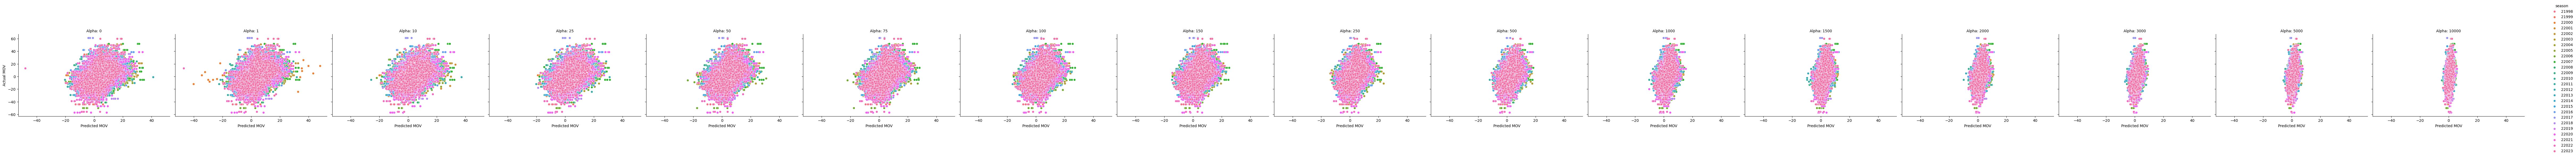

In [71]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot3, col='alpha', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [72]:
error_metrics3 = test_pivot3.groupby(['alpha', 'possession_threshold', 'model_name', 'param1', 'param2', 'season']).apply(calculate_error_metrics).reset_index()
best_params_per_season3 = error_metrics3.loc[error_metrics3.groupby('season')['RMSE'].idxmin()]

best_params_per_season3

alpha  possession_threshold        model_name  param1  param2  season  \
624      50                   100           XGBoost    1.00  500.00   21998   
989     150                   100  LinearRegression    0.00    0.00   21999   
990     150                   100  LinearRegression    0.00    0.00   22000   
939     150                   100        ElasticNet    0.01    0.01   22001   
1122    250                   100  LinearRegression    0.00    0.00   22002   
1201    500                   100        ElasticNet    0.01    0.01   22003   
1124    250                   100  LinearRegression    0.00    0.00   22004   
1151    250                   100           XGBoost    1.00  500.00   22005   
34        0                   100        ElasticNet    0.01    0.01   22006   
997     150                   100  LinearRegression    0.00    0.00   22007   
1128    250                   100  LinearRegression    0.00    0.00   22008   
1285    500                   100           XGBoost    1.00  500.00   22009   
766      75                   100           XGBoost    1.00  500.00   22010   
741      75                   100  LinearRegression    0.00    0.00   22011   
1028    150                   100           XGBoost    1.00  500.00   22012   
691      75                   100        ElasticNet    0.01    0.01   22013   
614      50                   100  LinearRegression    0.00    0.00   22014   
43        0                   100        ElasticNet    0.01    0.01   22015   
1292    500                   100           XGBoost    1.00  500.00   22016   
305      10                   100        ElasticNet    0.01    0.01   22017   
618      50                   100  LinearRegression    0.00    0.00   22018   
619      50                   100  LinearRegression    0.00    0.00   22019   
1140    250                   100  LinearRegression    0.00    0.00   22020   
257       1                   100           XGBoost    1.00  500.00   22021   
180       1                   100        ElasticNet    0.01    0.01   22022   
103       0                   100  LinearRegression    0.00    0.00   22023   

              MAPE       RMSE  R_squared  
624   8.122822e+14  11.972501   0.179389  
989   1.665457e+15  11.927793   0.185780  
990   1.592676e+15  10.711715   0.240698  
939   6.734991e+14  12.002519   0.158239  
1122  1.970903e+15  12.015418   0.142835  
1201  1.443741e+15  11.683021   0.096197  
1124  1.486252e+15  12.000756   0.133026  
1151  8.393254e+14  11.359294   0.144793  
34    1.719693e+15  12.444247   0.135260  
997   1.492010e+15  11.857339   0.268917  
1128  1.067537e+15  12.388516   0.127458  
1285  6.593726e+14  12.054465   0.139297  
766   1.476552e+15  11.576088   0.244065  
741   1.426984e+15  12.873032   0.184935  
1028  7.726200e+14  11.907641   0.157131  
691   1.390734e+15  11.599459   0.170781  
614   1.139328e+15  12.153434   0.256837  
43    1.423635e+15  11.987214   0.223886  
1292  6.722953e+14  12.875627   0.084901  
305   9.398512e+14  13.362998   0.119912  
618   1.429020e+15  12.969952   0.224016  
619   1.704165e+15  11.675403   0.132544  
1140  1.114012e+15  13.933282   0.216571  
257   1.014812e+15  14.959171   0.186421  
180   1.546469e+15  13.646253   0.186954  
103   1.406469e+15  14.105887   0.293677

In [73]:
# Group by model, param_alpha, and param_l1_ratio
error_metrics_agg3 = error_metrics3.groupby(['alpha', 'possession_threshold', 'model_name', 'param1', 'param2']).agg(
    unique_seasons=('season', 'nunique'),
    avg_mape=('MAPE', 'mean'),
    avg_rmse=('RMSE', 'mean'),
    avg_r2=('R_squared', 'mean')).sort_values(by='avg_rmse').reset_index()

error_metrics_agg3

alpha  possession_threshold        model_name  param1  param2  \
0     150                   100  LinearRegression    0.00    0.00   
1     100                   100  LinearRegression    0.00    0.00   
2     100                   100        ElasticNet    0.01    0.01   
3     250                   100  LinearRegression    0.00    0.00   
4     150                   100        ElasticNet    0.01    0.01   
..    ...                   ...               ...     ...     ...   
75    100                   100    HuberRegressor    0.01    2.00   
76     75                   100    HuberRegressor    0.01    2.00   
77     50                   100    HuberRegressor    0.01    2.00   
78      1                   100    HuberRegressor    0.01    2.00   
79      0                   100    HuberRegressor    0.01    2.00   

    unique_seasons      avg_mape   avg_rmse    avg_r2  
0               26  1.227470e+15  12.468865  0.167666  
1               26  1.310735e+15  12.480196  0.165771  
2               26  1.251834e+15  12.486969  0.165254  
3               26  1.109377e+15  12.487288  0.165700  
4               26  1.173026e+15  12.489460  0.165266  
..             ...           ...        ...       ...  
75              26  8.955714e+14  13.773468 -0.012231  
76              26  9.194058e+14  13.783138 -0.013620  
77              26  9.477645e+14  13.797225 -0.015666  
78              26  1.086165e+15  13.946301 -0.039011  
79              26  1.159779e+15  14.030677 -0.052147  

[80 rows x 9 columns]

In [74]:
# Group by model and alpha_x and calculate the mean of avg_rmse
grouped_df3 = error_metrics_agg3.groupby(['model_name', 'alpha'])['avg_rmse'].mean().reset_index()

In [75]:
# Define a custom color palette
custom_palette = {
    'DecisionTree': '#f9a01b', 
    'ElasticNet': '#f58426', 
    'HuberRegressor': '#006bb6', 
    'LinearRegression': '#007a33', 
    'RandomForest': '#552583', 
    'XGBoost': '#ce1141', 
}


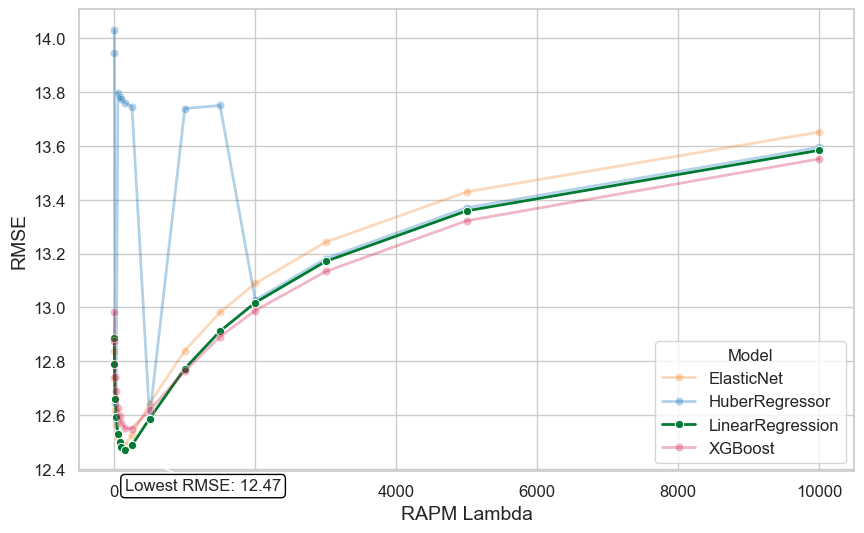

In [ ]:
# Identify the model with the lowest RMSE value
min_rmse_point = grouped_df3.loc[grouped_df3['avg_rmse'].idxmin()]
highlight_model = min_rmse_point['model_name']

# Plotting
plt.figure(figsize=(10, 6))

# Plot each model, highlighting the one with the lowest RMSE
for model_name, group in grouped_df3[grouped_df3['model_name']!='DecisionTree'].groupby('model_name'):
# for model_name, group in grouped_df3.groupby('model_name'):
    alpha_value = 1.0 if model_name == highlight_model else 0.3
    sns.lineplot(data=group, x='alpha', y='avg_rmse', marker='o', markersize=7, label=model_name, alpha=alpha_value, color=custom_palette.get(model_name, '#333333'), linewidth=3)

# Set y-axis limits
# plt.ylim(12.25, 14)

# Annotate the point with the lowest y value
plt.annotate(
    f"Lowest RMSE: {min_rmse_point['avg_rmse']:.2f}",
    xy=(min_rmse_point['alpha'], min_rmse_point['avg_rmse']),
    xytext=(min_rmse_point['alpha'] + 0.5, min_rmse_point['avg_rmse'] - 0.15),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    bbox=dict(boxstyle="round,pad=0.25", edgecolor='black', facecolor='white')
)

# Set labels and grid
plt.xlabel('RAPM Lambda', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.grid(True)
plt.legend(title='Model', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

In [54]:
# Determine actual and predicted winners
test_pivot3['actual_winner'] = test_pivot3['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot3['predicted_winner'] = test_pivot3['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot3['correct_prediction'] = test_pivot3['actual_winner'] == test_pivot3['predicted_winner']

# Group by alpha and season and calculate summary statistics
pred_summary3 = test_pivot3.groupby(['alpha', 'possession_threshold', 'model_name', 'param1', 'param2']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')).reset_index()

# Calculate the percentage of correct predictions
pred_summary3['percent_correct'] = (pred_summary3['correct_predictions'] / pred_summary3['total_games']) * 100
pred_summary3.sort_values(by='percent_correct', ascending=False).reset_index(drop=True).head(25)

alpha  possession_threshold        model_name  param1  param2  \
0       0                   100  LinearRegression     0.0     0.0   
1       0                   100    HuberRegressor     0.0     0.0   
2      50                   100  LinearRegression     0.0     0.0   
3     100                   100  LinearRegression     0.0     0.0   
4     100                   100    HuberRegressor     0.0     0.0   
5      50                   100    HuberRegressor     0.0     0.0   
6     250                   100  LinearRegression     0.0     0.0   
7     250                   100    HuberRegressor     0.0     0.0   
8     500                   100    HuberRegressor     0.0     0.0   
9     500                   100  LinearRegression     0.0     0.0   
10      0                   100      RandomForest   500.0  2000.0   
11   1000                   100    HuberRegressor     0.0     0.0   
12   1000                   100  LinearRegression     0.0     0.0   
13    250                   100           XGBoost     1.0   100.0   
14    250                   100      RandomForest   500.0  2000.0   
15   1500                   100  LinearRegression     0.0     0.0   
16   1500                   100    HuberRegressor     0.0     0.0   
17      0                   100           XGBoost     1.0   100.0   
18    100                   100           XGBoost     1.0   100.0   
19     50                   100           XGBoost     1.0   100.0   
20    500                   100           XGBoost     1.0   100.0   
21   1500                   100      RandomForest   500.0  2000.0   
22   1000                   100           XGBoost     1.0   100.0   
23   2000                   100  LinearRegression     0.0     0.0   
24   2000                   100    HuberRegressor     0.0     0.0   

    total_games  correct_predictions  percent_correct  
0          5991                 3950        65.932232  
1          5991                 3944        65.832081  
2          5991                 3943        65.815390  
3          5991                 3942        65.798698  
4          5991                 3938        65.731931  
5          5991                 3936        65.698548  
6          5991                 3907        65.214488  
7          5991                 3900        65.097646  
8          5991                 3898        65.064263  
9          5991                 3896        65.030880  
10         5991                 3873        64.646970  
11         5991                 3868        64.563512  
12         5991                 3859        64.413287  
13         5991                 3846        64.196294  
14         5991                 3846        64.196294  
15         5991                 3841        64.112836  
16         5991                 3831        63.945919  
17         5991                 3827        63.879152  
18         5991                 3825        63.845769  
19         5991                 3824        63.829077  
20         5991                 3821        63.779002  
21         5991                 3816        63.695543  
22         5991                 3812        63.628776  
23         5991                 3807        63.545318  
24         5991                 3797        63.378401

In [78]:
# Step 1: Sort df1 by avg_rmse and select the top 10 rows
top_10_bpm_models = error_metrics_agg3.nsmallest(10, 'avg_rmse')
top_10_bpm_models.rename(columns={'model_name': 'model'}, inplace=True)

In [80]:
# Step 2: Filter df2 based on the top 10 rows from df1
player_bpm_filtered = player_bpm.merge(top_10_bpm_models[['alpha', 'possession_threshold', 'model', 'param1', 'param2']], 
                         on=['alpha', 'possession_threshold', 'model', 'param1', 'param2'])

### v4: player SPM model - try every combination of parameters for player RAPM with every combination of parameters for player BPM and try different weights from 0% to 100% between the two

In [81]:
merged_df = pd.merge(player_rapm, player_bpm_filtered[['player_id','season','years_of_data','alpha','possession_threshold','model','param1','param2','dbpm','obpm','bpm','possessions']], on=['player_id', 'season', 'years_of_data'])

In [82]:
merged_df[(merged_df['player_name']=='Stephen Curry') & (merged_df['season']==22015)].sort_values(by='bpm',ascending=False).reset_index(drop=True)

player_id  season  years_of_data  alpha_x     drapm     orapm  \
0      201939   22015              1        0  0.028310  0.134289   
1      201939   22015              1     2000  0.018250  0.055795   
2      201939   22015              1      500  0.020878  0.084594   
3      201939   22015              1     1000  0.020575  0.070059   
4      201939   22015              1      100  0.020429  0.112010   
5      201939   22015              1        0  0.028310  0.134289   
6      201939   22015              1     1000  0.020575  0.070059   
7      201939   22015              1      100  0.020429  0.112010   
8      201939   22015              1     2000  0.018250  0.055795   
9      201939   22015              1      500  0.020878  0.084594   
10     201939   22015              1      100  0.020429  0.112010   
11     201939   22015              1     1000  0.020575  0.070059   
12     201939   22015              1     2000  0.018250  0.055795   
13     201939   22015              1        0  0.028310  0.134289   
14     201939   22015              1      500  0.020878  0.084594   
15     201939   22015              1     2000  0.018250  0.055795   
16     201939   22015              1      500  0.020878  0.084594   
17     201939   22015              1      100  0.020429  0.112010   
18     201939   22015              1     1000  0.020575  0.070059   
19     201939   22015              1        0  0.028310  0.134289   
20     201939   22015              1     1000  0.020575  0.070059   
21     201939   22015              1     2000  0.018250  0.055795   
22     201939   22015              1      500  0.020878  0.084594   
23     201939   22015              1        0  0.028310  0.134289   
24     201939   22015              1      100  0.020429  0.112010   
25     201939   22015              1     1000  0.020575  0.070059   
26     201939   22015              1     2000  0.018250  0.055795   
27     201939   22015              1      500  0.020878  0.084594   
28     201939   22015              1      100  0.020429  0.112010   
29     201939   22015              1        0  0.028310  0.134289   
30     201939   22015              1        0  0.028310  0.134289   
31     201939   22015              1     2000  0.018250  0.055795   
32     201939   22015              1      100  0.020429  0.112010   
33     201939   22015              1     1000  0.020575  0.070059   
34     201939   22015              1      500  0.020878  0.084594   
35     201939   22015              1      100  0.020429  0.112010   
36     201939   22015              1     1000  0.020575  0.070059   
37     201939   22015              1     2000  0.018250  0.055795   
38     201939   22015              1        0  0.028310  0.134289   
39     201939   22015              1      500  0.020878  0.084594   
40     201939   22015              1      100  0.020429  0.112010   
41     201939   22015              1        0  0.028310  0.134289   
42     201939   22015              1      500  0.020878  0.084594   
43     201939   22015              1     2000  0.018250  0.055795   
44     201939   22015              1     1000  0.020575  0.070059   
45     201939   22015              1     1000  0.020575  0.070059   
46     201939   22015              1        0  0.028310  0.134289   
47     201939   22015              1      500  0.020878  0.084594   
48     201939   22015              1      100  0.020429  0.112010   
49     201939   22015              1     2000  0.018250  0.055795   

      player_name      rapm  alpha_y  possession_threshold             model  \
0   Stephen Curry  0.162599        0                   100  LinearRegression   
1   Stephen Curry  0.074045        0                   100  LinearRegression   
2   Stephen Curry  0.105472        0                   100  LinearRegression   
3   Stephen Curry  0.090634        0                   100  LinearRegression   
4   Stephen Curry  0.132439        0                   100  LinearRegression   
5   

In [83]:
# Initialize a list to store DataFrames for each weight
player_spm = []

# Iterate over weightings from 10% to 90% towards rapm
for weight in rapm_weights:
    # Calculate dspm and ospm for each row
    merged_df['dspm'] = weight * merged_df['drapm'] + (1 - weight) * merged_df['dbpm']
    merged_df['ospm'] = weight * merged_df['orapm'] + (1 - weight) * merged_df['obpm']
    merged_df['rapm_weight'] = weight
    
    # Append a copy of the DataFrame with the new columns to the list
    player_spm.append(merged_df.copy())

# Concatenate all results into a single DataFrame
player_spm = pd.concat(player_spm, ignore_index=True)

In [84]:
# Precompute SPM dictionaries
spm_dicts = {}
for weight in rapm_weights:
    print(weight)
    spm_dicts[weight] = {}
    for alpha_x in ridge_params['alpha']:  
        print(alpha_x) 
        spm_dicts[weight][alpha_x] = {}
        for _, row in top_10_bpm_models.iterrows():
            alpha_y = row['alpha']
            poss = row['possession_threshold']
            model = row['model']
            param1 = row['param1']
            param2 = row['param2']

            key = (alpha_y, poss, model, param1, param2)
            filtered_spm = player_spm[
                (player_spm['rapm_weight'] == weight) &
                (player_spm['alpha_x'] == alpha_x) &
                (player_spm['alpha_y'] == alpha_y) &
                (player_spm['possession_threshold'] == poss) &
                (player_spm['model'] == model) &
                (player_spm['param1'] == param1) &
                (player_spm['param2'] == param2)
            ]
            spm_dicts[weight][alpha_x][key] = {
                'ospm': filtered_spm.set_index(['season', 'player_id'])['ospm'].to_dict(),
                'dspm': filtered_spm.set_index(['season', 'player_id'])['dspm'].to_dict()
            }

0.1
0
100
500
1000
2000
0.3
0
100
500
1000
2000
0.5
0
100
500
1000
2000
0.7
0
100
500
1000
2000
0.9
0
100
500
1000
2000


In [85]:
# Function to calculate SPM using precomputed dictionaries
def calculate_possession_spm(season, home_lineup, away_lineup, home_possession, weight, alpha_x, key, spm_dicts):
    ospm_dict = spm_dicts[weight][alpha_x][key]['ospm']
    dspm_dict = spm_dicts[weight][alpha_x][key]['dspm']
    
    if home_possession == 1:
        home_ospm = sum(ospm_dict.get((season, player), 0) for player in home_lineup)
        away_dspm = sum(dspm_dict.get((season, player), 0) for player in away_lineup)
        return home_ospm - away_dspm
    else:
        home_dspm = sum(dspm_dict.get((season, player), 0) for player in home_lineup)
        away_ospm = sum(ospm_dict.get((season, player), 0) for player in away_lineup)
        return away_ospm - home_dspm

In [86]:
test_df4 = test_df.copy()

In [87]:
test_df4['home_lineup'] = test_df4['players'].apply(lambda x: x[:5])
test_df4['away_lineup'] = test_df4['players'].apply(lambda x: x[5:])

# Calculate SPM for each alpha and store in separate columns
for weight in rapm_weights:
    print(weight)
    for alpha_x in ridge_params['alpha']:   
        for _, row in top_10_bpm_models.iterrows():
            alpha_y = row['alpha']
            poss = row['possession_threshold']
            model = row['model']
            param1 = row['param1']
            param2 = row['param2']
            key = (alpha_y, poss, model, param1, param2)
            
            test_df4[f'spm_{weight}_{alpha_x}_{alpha_y}_{poss}_{model}_{param1}_{param2}'] = test_df4.apply(
                lambda row: calculate_possession_spm(
                    row['season'], row['home_lineup'], row['away_lineup'], row['home_possession'], weight, alpha_x, key, spm_dicts
                ), axis=1
            )

0.1
0.3
0.5
0.7
0.9


In [88]:
# Step 1: Aggregate the DataFrame
spm_columns = [col for col in test_df4.columns if col.startswith('spm_')]
test_agg4 = test_df4.groupby(['season', 'game', 'home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    **{col: (col, 'sum') for col in spm_columns}
).reset_index()

In [89]:
# Step 2: Melt the Aggregated DataFrame to long format
test_agg4_long = test_agg4.melt(
    id_vars=['season', 'game', 'home_possession', 'possessions', 'points'],
    value_vars=spm_columns,
    var_name='param_combination',
    value_name='spm'
)

# Corrected regular expression to capture integers and decimals
pattern = r'spm_([\d.]+)_(\d+)_(\d+)_(\d+)_(\w+)_([\d.]+)_([\d.]+)'

# Use str.extract to separate the 'param_combination' column into components
test_agg4_long[['weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'model', 'param1', 'param2']] = test_agg4_long['param_combination'].str.extract(pattern)

# Convert extracted values to appropriate data types
test_agg4_long['weight'] = test_agg4_long['weight'].astype(float)
test_agg4_long['alpha_x'] = test_agg4_long['alpha_x'].astype(int)
test_agg4_long['alpha_y'] = test_agg4_long['alpha_y'].astype(int)
test_agg4_long['possession_threshold'] = test_agg4_long['possession_threshold'].astype(int)
test_agg4_long['param1'] = test_agg4_long['param1'].astype(float)
test_agg4_long['param2'] = test_agg4_long['param2'].astype(float)

In [90]:
# Calculate additional metrics
def get_y_av(season):
    return season_averages[season]

def get_hca(season, alpha):
    return hca_averages[season][alpha]

test_agg4_long['y_av'] = test_agg4_long.apply(lambda row: get_y_av(row['season']), axis=1)
test_agg4_long['hca_x'] = test_agg4_long.apply(lambda row: get_hca(row['season'], row['alpha_x']), axis=1)
test_agg4_long['hca_y'] = test_agg4_long.apply(lambda row: get_hca(row['season'], row['alpha_y']), axis=1)
test_agg4_long['hca'] = (test_agg4_long['hca_x'] + test_agg4_long['hca_x']) / 2

test_agg4_long['pred_points'] = test_agg4_long.apply(
    lambda row: (row['possessions'] * row['y_av']) + ((row['possessions'] * row['hca']) / 2) + row['spm'] if row['home_possession'] == 1 else
                (row['possessions'] * row['y_av']) - ((row['possessions'] * row['hca']) / 2) + row['spm'], axis=1
)

In [91]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot4 = test_agg4_long.pivot_table(index=['weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'model', 'param1', 'param2', 'season', 'y_av', 'hca', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

# Rename columns
test_pivot4.columns.name = None
test_pivot4.columns = ['weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'model', 'param1', 'param2', 'season', 'y_av', 'hca', 'game', 'away_points', 'home_points', 'away_pred_points', 'home_pred_points']

# Create MOV columns
test_pivot4['mov'] = test_pivot4['home_points'] - test_pivot4['away_points']
test_pivot4['pred_mov'] = test_pivot4['home_pred_points'] - test_pivot4['away_pred_points']

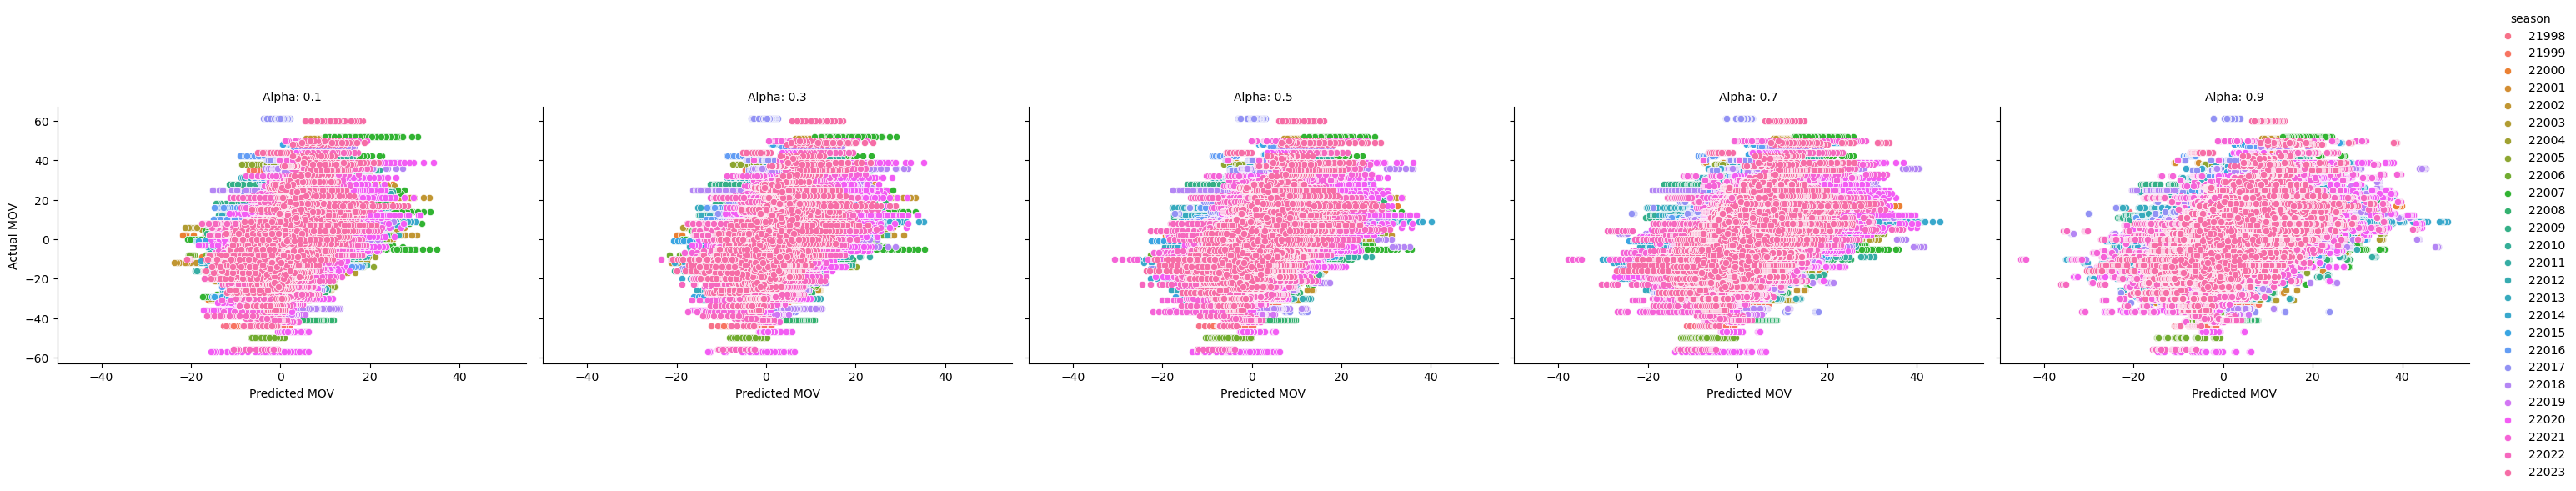

In [92]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot4, col='weight', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [141]:
# Group by 'alpha' and 'season' and calculate error metrics
error_metrics4 = test_pivot4.groupby(['weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'model', 'param1', 'param2', 'season']).apply(calculate_error_metrics).reset_index()

best_params_per_season4 = error_metrics4.loc[error_metrics4.groupby('season')['RMSE'].idxmin()]

best_params_per_season4

weight  alpha_x  alpha_y  possession_threshold             model  \
2860     0.5      100        0                   100  LinearRegression   
3173     0.5      500      100                   100  LinearRegression   
3174     0.5      500      100                   100  LinearRegression   
4683     0.7     1000        0                   100  LinearRegression   
3488     0.5     1000      500                   100  LinearRegression   
4997     0.7     2000      100                   100  LinearRegression   
4426     0.7      500        0                   100  LinearRegression   
4739     0.7     1000      100                   100  LinearRegression   
3700     0.5     2000      100                   100  LinearRegression   
841      0.1     1000      100                   100  LinearRegression   
3702     0.5     2000      100                   100  LinearRegression   
4977     0.7     2000        0                  1000  LinearRegression   
1858     0.3      500        0                  1000  LinearRegression   
1859     0.3      500        0                  1000  LinearRegression   
2406     0.3     2000      100                   100  LinearRegression   
3447     0.5     1000      100                   100  LinearRegression   
1628     0.3      100      100                   100  LinearRegression   
69       0.1        0      100                   100  LinearRegression   
1552     0.3        0     2000                  1000  LinearRegression   
2125     0.3     1000        0                  1000  LinearRegression   
2100     0.3     1000        0                   100  LinearRegression   
2881     0.5      100        0                   100  LinearRegression   
1088     0.1     2000        0                  1000  LinearRegression   
4703     0.7     1000        0                   100  LinearRegression   
2104     0.3     1000        0                   100  LinearRegression   
2885     0.5      100        0                   100  LinearRegression   

      param1  param2  season          MAPE       RMSE  R_squared  
2860     0.0     0.0   21998  9.047322e+14  11.639290   0.224431  
3173     0.0     0.0   21999  1.634057e+15  11.596908   0.230327  
3174     0.0     0.0   22000  1.470594e+15  10.427816   0.280413  
4683     0.0     0.0   22001  6.374969e+14  11.737295   0.195029  
3488     0.0     0.0   22002  1.561901e+15  11.894294   0.160030  
4997     0.0     0.0   22003  1.265016e+15  11.380114   0.142455  
4426     0.0     0.0   22004  1.793130e+15  11.475964   0.207194  
4739     0.0     0.0   22005  7.298363e+14  11.170945   0.172918  
3700     0.0     0.0   22006  1.353979e+15  12.162062   0.174033  
841      0.0     0.0   22007  1.427751e+15  11.764617   0.280306  
3702     0.0     0.0   22008  8.478845e+14  12.284794   0.142007  
4977     0.0     0.0   22009  8.462370e+14  11.873028   0.165011  
1858     0.0     0.0   22010  1.539809e+15  11.377984   0.269717  
1859     0.0     0.0   22011  1.393104e+15  12.691627   0.207744  
2406     0.0     0.0   22012  8.324235e+14  11.942875   0.152136  
3447     0.0     0.0   22013  1.199765e+15  11.456084   0.191153  
1628     0.0     0.0   22014  1.347718e+15  11.934710   0.283345  
69       0.0     0.0   22015  1.298475e+15  11.967553   0.226430  
1552     0.0     0.0   22016  5.487437e+14  12.771727   0.099610  
2125     0.0     0.0   22017  1.176254e+15  13.113442   0.152477  
2100     0.0     0.0   22018  1.492954e+15  12.880109   0.234730  
2881     0.0     0.0   22019  1.676174e+15  11.321089   0.184395  
1088     0.0     0.0   22020  1.147141e+15  13.209774   0.295820  
4703     0.0     0.0   22021  9.554749e+14  14.552052   0.230103  
2104     0.0     0.0   22022  1.565252e+15  13.309813   0.226550  
2885     0.0     0.0   22023  1.540743e+15  13.576478   0.345700

In [94]:
# Group by model, param_alpha, and param_l1_ratio
error_metrics_agg4 = error_metrics4.groupby(['weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'model', 'param1', 'param2']).agg(
    unique_seasons=('season', 'nunique'),
    avg_mape=('MAPE', 'mean'),
    avg_rmse=('RMSE', 'mean'),
    avg_r2=('R_squared', 'mean')
).sort_values(by='avg_rmse').reset_index()

error_metrics_agg4.head(10)

weight  alpha_x  alpha_y  possession_threshold             model  param1  \
0     0.5     1000      100                   100  LinearRegression     0.0   
1     0.5     1000        0                   100  LinearRegression     0.0   
2     0.5     2000        0                   100  LinearRegression     0.0   
3     0.7     2000        0                   100  LinearRegression     0.0   
4     0.7     1000        0                   100  LinearRegression     0.0   
5     0.5      500      100                   100  LinearRegression     0.0   
6     0.3      500      100                   100  LinearRegression     0.0   
7     0.3     1000      100                   100  LinearRegression     0.0   
8     0.7     1000      100                   100  LinearRegression     0.0   
9     0.5     2000      100                   100  LinearRegression     0.0   

   param2  unique_seasons      avg_mape   avg_rmse    avg_r2  
0     0.0              26  1.170106e+15  12.244554  0.196737  
1     0.0              26  1.295501e+15  12.247516  0.195712  
2     0.0              26  1.192884e+15  12.258686  0.194487  
3     0.0              26  1.138792e+15  12.264334  0.194150  
4     0.0              26  1.286258e+15  12.266563  0.193466  
5     0.0              26  1.286203e+15  12.268263  0.193393  
6     0.0              26  1.231868e+15  12.271033  0.193139  
7     0.0              26  1.154340e+15  12.272574  0.193050  
8     0.0              26  1.216799e+15  12.278051  0.192256  
9     0.0              26  1.060954e+15  12.278665  0.192535

In [95]:
# Determine actual and predicted winners
test_pivot4['actual_winner'] = test_pivot4['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot4['predicted_winner'] = test_pivot4['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot4['correct_prediction'] = test_pivot4['actual_winner'] == test_pivot4['predicted_winner']

# Group by alpha and season and calculate summary statistics
pred_summary4 = test_pivot4.groupby(['weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'model', 'param1', 'param2']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')
).reset_index()

# Calculate the percentage of correct predictions
pred_summary4['percent_correct'] = (pred_summary4['correct_predictions'] / pred_summary4['total_games']) * 100

pred_summary4.sort_values(by='percent_correct', ascending=False).reset_index(drop=True).head(10)

weight  alpha_x  alpha_y  possession_threshold             model  param1  \
0     0.5      500        0                  1000  LinearRegression     0.0   
1     0.5     1000        0                  1000  LinearRegression     0.0   
2     0.9     2000     1000                  1000  LinearRegression     0.0   
3     0.5     2000        0                   100  LinearRegression     0.0   
4     0.5      500        0                   100  LinearRegression     0.0   
5     0.9     2000      100                  1000  LinearRegression     0.0   
6     0.9     2000        0                  1000  LinearRegression     0.0   
7     0.5     1000      100                  1000  LinearRegression     0.0   
8     0.5     2000        0                  1000  LinearRegression     0.0   
9     0.9     2000      100                   100  LinearRegression     0.0   

   param2  total_games  correct_predictions  percent_correct  
0     0.0         5991                 4045        67.517944  
1     0.0         5991                 4037        67.384410  
2     0.0         5991                 4035        67.351027  
3     0.0         5991                 4034        67.334335  
4     0.0         5991                 4034        67.334335  
5     0.0         5991                 4033        67.317643  
6     0.0         5991                 4033        67.317643  
7     0.0         5991                 4031        67.284260  
8     0.0         5991                 4030        67.267568  
9     0.0         5991                 4030        67.267568

### v5: calculate lineup RAPM vs. individual 5 player opposition and use that to predict game MOV

In [ ]:
# Create final table
lineup_orapm = pd.DataFrame()
lineup_drapm = pd.DataFrame()
lineup_orapm_summary = pd.DataFrame()
lineup_drapm_summary = pd.DataFrame()

In [ ]:
all_seasons = range(min_season,max_season+1)

for current_season in all_seasons:
    print(current_season)
    
    # Get the years that are needed for this based on the current year and the number of years using for RAPM
    relevant_years = set(range(current_season-years_of_data+1, current_season+1))
    df = train_df[train_df['season'].isin(relevant_years)].reset_index(drop=True)
    # Create a unique identifier for each 5-man lineup
    df['home_lineup'] = df['players'].apply(lambda x: tuple(sorted(x[:5])))
    df['away_lineup'] = df['players'].apply(lambda x: tuple(sorted(x[5:])))
    # Get a list of all unique lineups and all unique players
    all_lineups = set(set(df['home_lineup']).union(set(df['away_lineup'])))
    all_players = set([player for sublist in df['players'] for player in sublist])
    print("Get Lineups")
    # Initialize an empty dictionary for lineup-to-column mapping
    lineup_to_col = {lineup: idx for idx, lineup in enumerate(all_lineups)}
    player_to_col = {player: idx + len(lineup_to_col) for idx, player in enumerate(all_players)}
    # Create the reverse dictionary for looking up
    col_to_lineup = {value: key for key, value in lineup_to_col.items()}
    col_to_player = {value: key for key, value in player_to_col.items()}
    
    # Initialize sparse matrix and response vector
    X = lil_matrix((len(df), len(lineup_to_col) + len(player_to_col)))
    y = np.zeros(len(df))
    sample_weights = []
            
    print("Populate Matrix")
    # Populate the matrix and vectors
    for idx, row in df.iterrows():
        home_possession = row['home_possession']
        points = row['points']
        season = row['season']
        
        if home_possession:
            off_lineup = row['home_lineup']
            def_lineup = row['away_lineup']
        else:
            def_lineup = row['home_lineup']
            off_lineup = row['away_lineup']
        
        X[idx, lineup_to_col[off_lineup]] = 1
        
        for player in def_lineup:
            X[idx, player_to_col[player]] = -1            
            
        y[idx] = points
        sample_weights.append(1.0 - 0.1 * (current_season-season))
    
    y_av = np.average(y, weights=sample_weights)
    
        # Perform cross-validation for Ridge
    ridge = Ridge()
    ridge_cv = GridSearchCV(ridge, ridge_params, scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)
    ridge_cv.fit(X.tocsr(), y - y_av, sample_weight=sample_weights)
  
    # Extract results for all parameter combinations for Ridge
    ridge_results_df = pd.DataFrame(ridge_cv.cv_results_)
    ridge_results_summary = ridge_results_df[['param_alpha', 'mean_test_score', 'std_test_score']].copy()
    ridge_results_summary.loc[:, 'mean_test_rmse'] = -ridge_results_summary['mean_test_score']
    ridge_results_summary.loc[:, 'std_test_rmse'] = ridge_results_summary['std_test_score']

    # Add a model identifier to each DataFrame
    ridge_results_summary['season'] = current_season
    lineup_orapm_summary = pd.concat([lineup_orapm_summary,ridge_results_summary], ignore_index=True)
        
    results = []
    
    # Iterate over each parameter combination
    for idx, params in enumerate(ridge_cv.cv_results_['params']):
        # Extract the corresponding coefficients
        ridge_model = Ridge(alpha=params['alpha'])
        ridge_model.fit(X, y - y_av, sample_weight=sample_weights)
        beta_ridge = ridge_model.coef_
        hca_ridge = ridge_model.intercept_*-1

        # Store results for each coefficient
        for i in range(len(lineup_to_col)):
            results.append({
                'lineup_id': col_to_lineup[i],
                'season': current_season,
                'years_of_data': years_of_data,
                'alpha': params['alpha'],
                'orapm': beta_ridge[i]
            })

    # Convert results to a DataFrame
    df_results = pd.DataFrame(results)
    
    # Append this to the master table
    lineup_orapm = pd.concat([lineup_orapm, df_results], ignore_index=True)

In [ ]:
all_seasons = range(min_season,max_season+1)

for current_season in all_seasons:
    print(current_season)
    
    # Get the years that are needed for this based on the current year and the number of years using for RAPM
    relevant_years = set(range(current_season-years_of_data+1, current_season+1))
    df = train_df[train_df['season'].isin(relevant_years)].reset_index(drop=True)
    # Create a unique identifier for each 5-man lineup
    df['home_lineup'] = df['players'].apply(lambda x: tuple(sorted(x[:5])))
    df['away_lineup'] = df['players'].apply(lambda x: tuple(sorted(x[5:])))
    # Get a list of all unique lineups and all unique players
    all_lineups = set(set(df['home_lineup']).union(set(df['away_lineup'])))
    all_players = set([player for sublist in df['players'] for player in sublist])
    print("Get Lineups")
    # Initialize an empty dictionary for lineup-to-column mapping
    lineup_to_col = {lineup: idx for idx, lineup in enumerate(all_lineups)}
    player_to_col = {player: idx + len(lineup_to_col) for idx, player in enumerate(all_players)}
    # Create the reverse dictionary for looking up
    col_to_lineup = {value: key for key, value in lineup_to_col.items()}
    col_to_player = {value: key for key, value in player_to_col.items()}
    
    # Initialize sparse matrix and response vector
    X = lil_matrix((len(df), len(lineup_to_col) + len(player_to_col)))
    y = np.zeros(len(df))
    sample_weights = []
            
    print("Populate Matrix")
    # Populate the matrix and vectors
    for idx, row in df.iterrows():
        home_possession = row['home_possession']
        points = row['points']
        season = row['season']
        
        if home_possession:
            off_lineup = row['home_lineup']
            def_lineup = row['away_lineup']
        else:
            def_lineup = row['home_lineup']
            off_lineup = row['away_lineup']
        
        X[idx, lineup_to_col[def_lineup]] = -1
        
        for player in off_lineup:
            X[idx, player_to_col[player]] = 1            
            
        y[idx] = points
        sample_weights.append(1.0 - 0.1 * (current_season-season))
    
    y_av = np.average(y, weights=sample_weights)
    
        # Perform cross-validation for Ridge
    ridge = Ridge()
    ridge_cv = GridSearchCV(ridge, ridge_params, scoring='neg_root_mean_squared_error', cv=10, return_train_score=True)
    ridge_cv.fit(X.tocsr(), y - y_av, sample_weight=sample_weights)
  
    # Extract results for all parameter combinations for Ridge
    ridge_results_df = pd.DataFrame(ridge_cv.cv_results_)
    ridge_results_summary = ridge_results_df[['param_alpha', 'mean_test_score', 'std_test_score']].copy()
    ridge_results_summary.loc[:, 'mean_test_rmse'] = -ridge_results_summary['mean_test_score']
    ridge_results_summary.loc[:, 'std_test_rmse'] = ridge_results_summary['std_test_score']

    # Add a model identifier to each DataFrame
    ridge_results_summary['season'] = current_season
    lineup_drapm_summary = pd.concat([lineup_drapm_summary,ridge_results_summary], ignore_index=True)
        
    results = []
    
    # Iterate over each parameter combination
    for idx, params in enumerate(ridge_cv.cv_results_['params']):
        # Extract the corresponding coefficients
        ridge_model = Ridge(alpha=params['alpha'])
        ridge_model.fit(X, y - y_av, sample_weight=sample_weights)
        beta_ridge = ridge_model.coef_
        hca_ridge = ridge_model.intercept_*-1

        # Store results for each coefficient
        for i in range(len(lineup_to_col)):
            results.append({
                'lineup_id': col_to_lineup[i],
                'season': current_season,
                'years_of_data': years_of_data,
                'alpha': params['alpha'],
                'drapm': beta_ridge[i]
            })

    # Convert results to a DataFrame
    df_results = pd.DataFrame(results)
    
    # Append this to the master table
    lineup_drapm = pd.concat([lineup_drapm, df_results], ignore_index=True)

In [ ]:
# Join lineup offensive RAPM to lineup defensive RAPM
lineup_rapm = pd.merge(lineup_orapm, lineup_drapm, on=['lineup_id', 'season', 'years_of_data', 'alpha'])

# Calculate total RAPM
lineup_rapm['rapm'] = lineup_rapm['orapm'] + lineup_rapm['drapm']

# Add player names using the dictionary
lineup_rapm[['player1', 'player2', 'player3', 'player4', 'player5']] = lineup_rapm['lineup_id'].apply(get_player_names).apply(pd.Series)

In [ ]:
# Sort the DataFrame by rapm
df_sorted = lineup_rapm.sort_values(by='rapm', ascending=False)

print("\nSorted DataFrame with Hyperparameters:")
df_sorted.head(10).reset_index(drop=True)

In [ ]:
# Precompute RAPM dictionaries
lineup_rapm_dicts = {}
for alpha in ridge_params['alpha']:
    lineup_rapm_dicts[alpha] = {
        'orapm': lineup_rapm[lineup_rapm['alpha'] == alpha].set_index(['season', 'lineup_id'])['orapm'].to_dict(),
        'drapm': lineup_rapm[lineup_rapm['alpha'] == alpha].set_index(['season', 'lineup_id'])['drapm'].to_dict()
    }

In [ ]:
# Function to calculate RAPM using precomputed dictionaries
def calculate_possession_lineup_rapm(season, home_lineup, away_lineup, home_possession, alpha, lineup_rapm_dicts):
    orapm_dict = lineup_rapm_dicts[alpha]['orapm']
    drapm_dict = lineup_rapm_dicts[alpha]['drapm']
    
    if home_possession == 1:
        home_orapm = orapm_dict.get((season, home_lineup), 0)
        away_drapm = drapm_dict.get((season, away_lineup), 0)
        return home_orapm - away_drapm
    else:
        home_drapm = drapm_dict.get((season, home_lineup), 0)
        away_orapm = orapm_dict.get((season, away_lineup), 0)
        return away_orapm - home_drapm

In [ ]:
test_df5 = test_df.copy()

In [ ]:
test_df5['home_lineup'] = test_df5['players'].apply(lambda x: x[:5])
test_df5['away_lineup'] = test_df5['players'].apply(lambda x: x[5:])

# Calculate RAPM for each alpha and store in separate columns
for alpha in ridge_params['alpha']:
    print(alpha)
    test_df5[f'rapm_{alpha}'] = test_df5.apply(
        lambda row: calculate_possession_lineup_rapm(
            row['season'], row['home_lineup'], row['away_lineup'], row['home_possession'], alpha, lineup_rapm_dicts
        ), axis=1
    )

In [ ]:
# Melt the DataFrame to long format
rapm_columns = [f'rapm_{alpha}' for alpha in ridge_params['alpha']]
test_df5_long = test_df5.melt(id_vars=['season', 'game', 'home_possession', 'game_possession', 'points'],
                            value_vars=rapm_columns,
                            var_name='alpha',
                            value_name='rapm')

# Extract alpha values from column names
test_df5_long['alpha'] = test_df5_long['alpha'].str.extract('(\d+)').astype(int)

In [ ]:
test_agg5 = test_df5_long.groupby(['alpha','season','game','home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    rapm=('rapm', 'sum')
).reset_index()

In [ ]:
def get_y_av(season):
    return season_averages[season]

def get_hca(season, alpha):
    return hca_averages[season][alpha]

test_agg5['y_av'] = test_agg5.apply(lambda row: get_y_av(row['season']), axis=1)
test_agg5['hca'] = test_agg5.apply(lambda row: get_hca(row['season'], row['alpha']), axis=1)

In [ ]:
if home_possession==1:
    test_agg5['pred_points'] = (test_agg5['possessions']*test_agg5['y_av'])+((test_agg5['possessions']*test_agg5['hca'])/2)+test_agg5['rapm']
else:
    test_agg5['pred_points'] = (test_agg5['possessions']*test_agg5['y_av'])-((test_agg5['possessions']*test_agg5['hca'])/2)+test_agg5['rapm']

In [ ]:
# Plot using seaborn
g = sns.FacetGrid(test_agg5, col='alpha', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_points', 'points')
g.add_legend()
g.set_axis_labels("Predicted Points", "Actual Points")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [ ]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot5 = test_agg5.pivot_table(index=['alpha', 'season', 'y_av', 'hca', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

test_pivot5.head(5)

In [ ]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot5 = test_agg5.pivot_table(index=['alpha', 'season', 'y_av', 'hca', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

# Rename columns
test_pivot5.columns.name = None
test_pivot5.columns = ['alpha', 'season', 'y_av', 'hca', 'game', 'away_points', 'home_points', 'away_pred_points', 'home_pred_points']

# Create MOV columns
test_pivot5['mov'] = test_pivot5['home_points'] - test_pivot5['away_points']
test_pivot5['pred_mov'] = test_pivot5['home_pred_points'] - test_pivot5['away_pred_points']

In [ ]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot5, col='alpha', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [ ]:
# Group by 'alpha' and 'season' and calculate error metrics
error_metrics5 = test_pivot5.groupby(['alpha', 'season']).apply(calculate_error_metrics).reset_index()

best_params_per_season5 = error_metrics5.loc[error_metrics5.groupby('season')['RMSE'].idxmin()]

best_params_per_season5

In [ ]:
# Group by model, param_alpha, and param_l1_ratio
error_metrics_agg5 = error_metrics5.groupby(['alpha']).agg(
    unique_seasons=('season', 'nunique'),
    avg_mape=('MAPE', 'mean'),
    avg_rmse=('RMSE', 'mean'),
    avg_r2=('R_squared', 'mean')
).sort_values(by='avg_rmse').reset_index()

error_metrics_agg5

In [ ]:
# Determine actual and predicted winners
test_pivot5['actual_winner'] = test_pivot5['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot5['predicted_winner'] = test_pivot5['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot5['correct_prediction'] = test_pivot5['actual_winner'] == test_pivot5['predicted_winner']

# Group by alpha and season and calculate summary statistics
pred_summary5 = test_pivot5.groupby(['alpha']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')
).reset_index()

# Calculate the percentage of correct predictions
pred_summary5['percent_correct'] = (pred_summary5['correct_predictions'] / pred_summary5['total_games']) * 100

pred_summary5.sort_values(by='percent_correct', ascending=False).reset_index(drop=True).head(10)

### v6: use lineup RAPM and different combos of all of the previous options or maybe just the best 5-20 options and see if we get any improvement

In [ ]:
# get like the top 20 performing models at the player level and then rather than loop through weight, then alpha_x, then alpha_y, then posssession we make a precomputed table of the best combinations of those parameters from previous

In [ ]:
#player_spm = pd.read_csv("best_model_predictions.csv")
#lineup_rapm = pd.read_csv("lineup_rapm.csv")

In [ ]:
player_spm.head(5)

In [ ]:
player_spm_final = player_spm[(player_spm['rapm_weight']==0.5) & (player_spm['alpha_x']==1000) & (player_spm['alpha_y']==0) & (player_spm['possession_threshold']==100)]

In [ ]:
lineup_rapm.head(5)

In [ ]:
# Precompute a dictionary for summed DSPM/OSPM
player_spm_dict = {}

for _, row in player_spm_final.iterrows():
    key = (row['season'], row['rapm_weight'], row['alpha_x'], row['alpha_y'], row['possession_threshold'])
    if key not in player_spm_dict:
        player_spm_dict[key] = {'dspm': 0, 'ospm': 0}
    player_spm_dict[key]['dspm'] += row['dspm']
    player_spm_dict[key]['ospm'] += row['ospm']

In [ ]:
# Initialize a list to store results
lineup_spm_results = []

# Iterate over each lineup and calculate combined RAPM
for _, lineup_row in lineup_rapm.iterrows():
    lineup = lineup_row['lineup_id']
    season = lineup_row['season']
    lineup_orapm = lineup_row['orapm']
    lineup_drapm = lineup_row['drapm']
    alpha = lineup_row['alpha']
    
    # Iterate over each combination of parameters in player_spm
    for key, values in player_spm_dict.items():
        if key[0] == season:  # Match season
            summed_dspm = values['dspm']
            summed_ospm = values['ospm']
            
            for weight in np.arange(0.1, 1.0, 0.1):
                combined_orapm = weight * lineup_orapm + (1 - weight) * summed_ospm
                combined_drapm = weight * lineup_drapm + (1 - weight) * summed_dspm
                lineup_spm_results.append({
                    'lineup_id': lineup,
                    'season': season,
                    'alpha': alpha,
                    'rapm_weight': key[1],
                    'alpha_x': key[2],
                    'alpha_y': key[3],
                    'possession_threshold': key[4],
                    'weight': weight,
                    'ospm': combined_orapm,
                    'dspm': combined_drapm
                })

# Convert results to a DataFrame
lineup_spm = pd.DataFrame(lineup_spm_results)

In [ ]:
lineup_spm.head(5)

In [ ]:
# Precompute SPM dictionaries
lineup_spm_dicts = {}
for weight in set(lineup_spm['weight']):
    lineup_spm_dicts[weight] = {}
    for alpha in set(lineup_spm['alpha']):
        lineup_spm_dicts[weight][alpha] = {}
        for rapm_weight in set(lineup_spm['rapm_weight']):
            lineup_spm_dicts[weight][alpha][rapm_weight] = {}
            for alpha_x in set(lineup_spm['alpha_x']):  
                lineup_spm_dicts[weight][alpha][rapm_weight][alpha_x] = {}
                for alpha_y in set(lineup_spm['alpha_y']):  
                    lineup_spm_dicts[weight][alpha][rapm_weight][alpha_x][alpha_y] = {}
                    for poss in set(lineup_spm['possession_threshold']):
                        lineup_spm_dicts[weight][alpha][rapm_weight][alpha_x][alpha_y][poss] = {
                            'ospm': lineup_spm[(lineup_spm['weight'] == weight) & (lineup_spm['alpha'] == alpha) & (lineup_spm['rapm_weight'] == rapm_weight) & (lineup_spm['alpha_x'] == alpha_x) & (lineup_spm['alpha_y'] == alpha_y) & (lineup_spm['possession_threshold'] == poss)].set_index(['season', 'lineup_id'])['ospm'].to_dict(),
                            'dspm': lineup_spm[(lineup_spm['weight'] == weight) & (lineup_spm['alpha'] == alpha) & (lineup_spm['rapm_weight'] == rapm_weight) & (lineup_spm['alpha_x'] == alpha_x) & (lineup_spm['alpha_y'] == alpha_y) & (lineup_spm['possession_threshold'] == poss)].set_index(['season', 'lineup_id'])['dspm'].to_dict()
                        }

In [ ]:
# Function to calculate RAPM using precomputed dictionaries
def calculate_possession_lineup_spm(season, home_lineup, away_lineup, home_possession, weight, alpha, rapm_weight, alpha_x, alpha_y, poss, lineup_spm_dicts):
    orapm_dict = lineup_spm_dicts[weight][alpha][rapm_weight][alpha_x][alpha_y][poss]['ospm']
    drapm_dict = lineup_spm_dicts[weight][alpha][rapm_weight][alpha_x][alpha_y][poss]['dspm']
    
    if home_possession == 1:
        home_orapm = orapm_dict.get((season, home_lineup), 0)
        away_drapm = drapm_dict.get((season, away_lineup), 0)
        return home_orapm - away_drapm
    else:
        home_drapm = drapm_dict.get((season, home_lineup), 0)
        away_orapm = orapm_dict.get((season, away_lineup), 0)
        return away_orapm - home_drapm

In [ ]:
test_df6 = test_df.copy()

In [ ]:
test_df6['home_lineup'] = test_df6['players'].apply(lambda x: x[:5])
test_df6['away_lineup'] = test_df6['players'].apply(lambda x: x[5:])

# Calculate SPM for each alpha and store in separate columns
for weight in set(lineup_spm['weight']):
    for alpha in set(lineup_spm['alpha']):
        for rapm_weight in set(lineup_spm['rapm_weight']):
            for alpha_x in set(lineup_spm['alpha_x']):  
                for alpha_y in set(lineup_spm['alpha_y']):  
                    for poss in set(lineup_spm['possession_threshold']):
                        test_df6[f'spm_{weight}_{alpha}_{rapm_weight}_{alpha_x}_{alpha_y}_{poss}'] = test_df6.apply(
                            lambda row: calculate_possession_lineup_spm(
                                row['season'], row['home_lineup'], row['away_lineup'], row['home_possession'], weight, alpha, rapm_weight, alpha_x, alpha_y, poss, lineup_spm_dicts
                            ), axis=1
                        )

In [ ]:
# Melt the DataFrame to long format 
lineup_spm_columns = [f'spm_{weight}_{alpha}_{rapm_weight}_{alpha_x}_{alpha_y}_{poss}' for weight in set(lineup_spm['weight']) for alpha in set(lineup_spm['alpha']) for rapm_weight in set(lineup_spm['rapm_weight']) for alpha_x in set(lineup_spm['alpha_x']) for alpha_y in set(lineup_spm['alpha_y']) for poss in set(lineup_spm['possession_threshold'])]
test_df6_long = test_df6.melt(id_vars=['season', 'game', 'home_possession', 'game_possession', 'points'],
                            value_vars=lineup_spm_columns,
                            var_name='weight_alpha_RAPMweight_alphaX_alphaY_possession',
                            value_name='spm')

# Extract alpha values from column names
test_df6_long[['weight', 'alpha','rapm_weight', 'alpha_x', 'alpha_y', 'possession_threshold']] = test_df6_long['weight_alpha_RAPMweight_alphaX_alphaY_possession'].str.extract(r'spm_([\d.]+)_([\d.]+)_([\d.]+)_([\d.]+)_([\d.]+)_(\d+)')

# Convert extracted values to appropriate data types
test_df6_long['weight'] = test_df6_long['weight'].astype(float)
test_df6_long['alpha'] = test_df6_long['alpha'].astype(int)
test_df6_long['rapm_weight'] = test_df6_long['rapm_weight'].astype(float)
test_df6_long['alpha_x'] = test_df6_long['alpha_x'].astype(int)
test_df6_long['alpha_y'] = test_df6_long['alpha_y'].astype(int)
test_df6_long['possession_threshold'] = test_df6_long['possession_threshold'].astype(int)

In [ ]:
test_agg6 = test_df6_long.groupby(['weight','alpha','rapm_weight','alpha_x','alpha_y','possession_threshold','season','game','home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    spm=('spm', 'sum')
).reset_index()

In [ ]:
def get_y_av(season):
    return season_averages[season]

def get_hca(season, alpha):
    return hca_averages[season][alpha]

test_agg6['y_av'] = test_agg6.apply(lambda row: get_y_av(row['season']), axis=1)
test_agg6['hca'] = test_agg6.apply(lambda row: get_hca(row['season'], row['alpha']), axis=1)

In [ ]:
if home_possession==1:
    test_agg6['pred_points'] = (test_agg6['possessions']*test_agg6['y_av'])+((test_agg6['possessions']*test_agg6['hca'])/2)+test_agg6['spm']
else:
    test_agg6['pred_points'] = (test_agg6['possessions']*test_agg6['y_av'])-((test_agg6['possessions']*test_agg6['hca'])/2)+test_agg6['spm']

In [ ]:
# Plot using seaborn
g = sns.FacetGrid(test_agg6, col='weight', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_points', 'points')
g.add_legend()
g.set_axis_labels("Predicted Points", "Actual Points")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [ ]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot6 = test_agg6.pivot_table(index=['weight', 'alpha', 'rapm_weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'season', 'y_av', 'hca', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

# Rename columns
test_pivot6.columns.name = None
test_pivot6.columns = ['weight', 'alpha', 'rapm_weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'season', 'y_av', 'hca', 'game', 'away_points', 'home_points', 'away_pred_points', 'home_pred_points']

# Create MOV columns
test_pivot6['mov'] = test_pivot6['home_points'] - test_pivot6['away_points']
test_pivot6['pred_mov'] = test_pivot6['home_pred_points'] - test_pivot6['away_pred_points']

In [ ]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot6, col='weight', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
g.set_titles(col_template="Alpha: {col_name}")
plt.show()

In [ ]:
# Group by 'alpha' and 'season' and calculate error metrics
error_metrics6 = test_pivot6.groupby(['weight', 'alpha', 'rapm_weight', 'alpha_x', 'alpha_y', 'possession_threshold', 'season']).apply(calculate_error_metrics).reset_index()

best_params_per_season6 = error_metrics6.loc[error_metrics6.groupby('season')['RMSE'].idxmin()]

best_params_per_season6

In [ ]:
# Group by model, param_alpha, and param_l1_ratio
error_metrics_agg6 = error_metrics6.groupby(['weight', 'alpha', 'rapm_weight', 'alpha_x', 'alpha_y', 'possession_threshold']).agg(
    unique_seasons=('season', 'nunique'),
    avg_mape=('MAPE', 'mean'),
    avg_rmse=('RMSE', 'mean'),
    avg_r2=('R_squared', 'mean')
).sort_values(by='avg_rmse').reset_index()

error_metrics_agg6

In [ ]:
# Determine actual and predicted winners
test_pivot6['actual_winner'] = test_pivot6['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot6['predicted_winner'] = test_pivot6['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot6['correct_prediction'] = test_pivot6['actual_winner'] == test_pivot6['predicted_winner']

# Group by alpha and season and calculate summary statistics
pred_summary6 = test_pivot6.groupby(['weight', 'alpha', 'rapm_weight', 'alpha_x', 'alpha_y', 'possession_threshold']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')
).reset_index()

# Calculate the percentage of correct predictions
pred_summary6['percent_correct'] = (pred_summary6['correct_predictions'] / pred_summary6['total_games']) * 100

pred_summary6.sort_values(by='percent_correct', ascending=False).reset_index(drop=True).head(10)

### v7: bayesian B-RAPM combined with bayesian RAPM

In [ ]:
# take B-RAPM when alpha = 0 and B-RAPM when alpha = 500 as one side with weights by how many possessions you've played
# take RAPM when alpha = 0 and when alpha = 2000 as the other side weighted by how many possessions they've played


# could do several layers, from alpha = 0, alpha = 500, alpha = 1000, alpha = 2000
# use the formula for RBR
# will be gradual but essentially like at possessions=0 then alpha=2000, at possessions=500 then alpha=1000, at possessions=1000 then alpha=500, at posssessions >2000 then alpha=0
# can do some research of my own to find what these weights should be but can also use guidance from Sill/Rosenbaum about minutes filters

In [ ]:
## need to find at what possession number does a player's rapm stabilize at each alpha

In [ ]:
ridge_params = {'alpha': [0, 100, 1000, 2000]}

In [96]:
# Pivot the DataFrame
pivot_rapm = player_rapm.pivot_table(index=['player_id', 'player_name', 'season'], 
                                  columns='alpha', 
                                  values=['drapm', 'orapm'])

# Flatten the MultiIndex columns
pivot_rapm.columns = [f'{col[0]}_{col[1]}' for col in pivot_rapm.columns]

# Reset the index to make player_id, player_name, and season columns again
pivot_rapm.reset_index(inplace=True)

pivot_rapm = pd.merge(pivot_rapm, player_bpm[['player_id','season','possessions']].drop_duplicates(), on=['player_id','season'])


# DRAPM
pivot_rapm['b_drapm'] = (
  (
    (pivot_rapm['drapm_1000'] * (pivot_rapm['possessions']**2))
    + (pivot_rapm['drapm_2000'] * 100000)
  ) / ((pivot_rapm['possessions']**2) + 100000)
)

pivot_rapm['b_drapm'] = (
  (
    (pivot_rapm['drapm_100'] * (pivot_rapm['possessions']**2))
    + (pivot_rapm['b_drapm'] * 100000000)
  ) / ((pivot_rapm['possessions']**2) + 100000000)
)

# ORAPM
pivot_rapm['b_orapm'] = (
  (
    (pivot_rapm['orapm_1000'] * (pivot_rapm['possessions']**2))
    + (pivot_rapm['orapm_2000'] * 100000)
  ) / ((pivot_rapm['possessions']**2) + 100000)
)

pivot_rapm['b_orapm'] = (
  (
    (pivot_rapm['orapm_100'] * (pivot_rapm['possessions']**2))
    + (pivot_rapm['b_orapm'] * 100000000)
  ) / ((pivot_rapm['possessions']**2) + 100000000)
)

In [97]:
pivot_rapm['b_rapm'] = pivot_rapm['b_drapm'] + pivot_rapm['b_orapm']

pivot_rapm.sort_values(by='b_rapm', ascending=False).head(40).reset_index(drop=True)

player_id              player_name  season   drapm_0  drapm_100  \
0         708            Kevin Garnett   22002  0.113641   0.097936   
1        2544             LeBron James   22008  0.067128   0.058377   
2      101108               Chris Paul   22008  0.088009   0.073074   
3        1717            Dirk Nowitzki   22002  0.106107   0.094082   
4      201142             Kevin Durant   22018  0.086368   0.073779   
5        2548              Dwyane Wade   22008  0.070094   0.058857   
6      203110           Draymond Green   22015  0.061015   0.060313   
7        1763               Ryan Bowen   22001  0.106700   0.094993   
8      201935             James Harden   22014  0.057688   0.044950   
9      202331              Paul George   22018  0.056598   0.062537   
10    1628983  Shai Gilgeous-Alexander   22023  0.078424   0.062743   
11     201939            Stephen Curry   22015  0.028310   0.020429   
12       2548              Dwyane Wade   22009  0.023493   0.024184   
13       1495               Tim Duncan   22004  0.115783   0.091314   
14     202695            Kawhi Leonard   22015  0.115495   0.098175   
15       1717            Dirk Nowitzki   22010  0.010118   0.006109   
16       1905         Andrei Kirilenko   22001  0.094194   0.084787   
17     201588              George Hill   22021  0.156665   0.127107   
18    1628384               OG Anunoby   22023  0.110569   0.097028   
19       2544             LeBron James   22009  0.053665   0.044372   
20     201939            Stephen Curry   22014  0.064764   0.052060   
21     201939            Stephen Curry   22021  0.036907   0.020529   
22     201142             Kevin Durant   22009  0.074453   0.063187   
23     201950             Jrue Holiday   22018  0.068956   0.065014   
24       2544             LeBron James   22016  0.031796   0.027305   
25       2544             LeBron James   22005  0.060494   0.041049   
26     201939            Stephen Curry   22016  0.017898   0.018063   
27     200768               Kyle Lowry   22015  0.091761   0.059976   
28         56              Gary Payton   21999  0.093996   0.067117   
29       1713             Vince Carter   21999 -0.001797  -0.003346   
30        708            Kevin Garnett   22006  0.072763   0.061451   
31       1718              Paul Pierce   22004  0.089388   0.072568   
32     203999             Nikola Jokic   22021  0.102656   0.076559   
33       1897        Metta World Peace   22005  0.067652   0.059744   
34       2594              Kyle Korver   22014  0.055557   0.001983   
35       2365           Chris Andersen   22009  0.085340   0.081240   
36       2544             LeBron James   22019  0.078659   0.070734   
37       1938            Manu Ginobili   22010  0.010366   0.010027   
38       2548              Dwyane Wade   22005  0.044511   0.038177   
39    1627832            Fred VanVleet   22023  0.103016   0.085920   

    drapm_500  drapm_1000  drapm_2000   orapm_0  orapm_100  orapm_500  \
0    0.065111    0.046138    0.028979  0.131620   0.109324   0.076599   
1    0.044404    0.036197    0.028099  0.129443   0.109647   0.078537   
2    0.048968    0.035660    0.023363  0.143713   0.113324   0.075439   
3    0.064987    0.047882    0.032175  0.074430   0.063296   0.053987   
4    0.046067    0.031885    0.019762  0.104211   0.092267   0.073480   
5    0.037042    0.025503    0.015779  0.154245   0.128768   0.083807   
6    0.046689    0.037058    0.027278  0.076960   0.073942   0.067054   
7    0.073687    0.057962    0.040438  0.080351   0.068628   0.050673   
8    0.029201    0.021002    0.013963  0.123861   0.111221   0.083426   
9    0.053978    0.044758    0.033549  0.113606   0.085340   0.055921   
10   0.042452    0.032138    0.023343  0.118431   0.098578   0.068361   
11   0.020878    0.020575    0.018250  0.134289   0.112010   0.084594   
12   0.016569    0.011935    0.007978  0.160548   0.137536   0.096092   
13   0.062909    0.049633    0.037590  0.068750   0.060093   0.045714 

In [98]:
# Pivot the DataFrame
# player_bpm_top = player_bpm.merge(top_10_bpm_models.loc[[0], ['alpha', 'possession_threshold', 'model', 'param1', 'param2']], 
#                          on=['alpha', 'possession_threshold', 'model', 'param1', 'param2'])

In [115]:
# Pivot the DataFrame
pivot_bpm = player_bpm[player_bpm['possession_threshold']==100].pivot_table(index=['player_id', 'player_name', 'season','possessions','possession_threshold', 'model', 'param1','param2'], 
                                                                          columns='alpha', 
                                                                          values=['dbpm', 'obpm'])

# Flatten the MultiIndex columns
pivot_bpm.columns = [f'{col[0]}_{col[1]}' for col in pivot_bpm.columns]

In [120]:
# Reset the index to make player_id, player_name, and season columns again
pivot_bpm.reset_index(inplace=True)

# DBPM
pivot_bpm['b_dbpm'] = (
  (
    (pivot_bpm['dbpm_100'] * (pivot_bpm['possessions']**2))
    + (pivot_bpm['dbpm_1000'] * 100000)
  ) / ((pivot_bpm['possessions']**2) + 100000)
)

pivot_bpm['b_dbpm'] = (
  (
    (pivot_bpm['dbpm_0'] * (pivot_bpm['possessions']**2))
    + (pivot_bpm['b_dbpm'] * 100000000)
  ) / ((pivot_bpm['possessions']**2) + 100000000)
)

# OBPM
pivot_bpm['b_obpm'] = (
  (
    (pivot_bpm['obpm_100'] * (pivot_bpm['possessions']**2))
    + (pivot_bpm['obpm_1000'] * 100000)
  ) / ((pivot_bpm['possessions']**2) + 100000)
)

pivot_bpm['b_obpm'] = (
  (
    (pivot_bpm['obpm_0'] * (pivot_bpm['possessions']**2))
    + (pivot_bpm['b_obpm'] * 100000000)
  ) / ((pivot_bpm['possessions']**2) + 100000000)
)

In [121]:
pivot_bpm['b_bpm'] = pivot_bpm['b_dbpm'] + pivot_bpm['b_obpm']

pivot_bpm.sort_values(by='b_bpm', ascending=False).head(40).reset_index(drop=True)

level_0  index  player_id       player_name  season  possessions  \
0      6761   6761     201939     Stephen Curry   22015       4532.0   
1      5026   5026     101108        Chris Paul   22008       4303.0   
2      5025   5025     101108        Chris Paul   22007       4485.0   
3      5030   5030     101108        Chris Paul   22012       3427.0   
4      4119   4119       2544      LeBron James   22009       4823.0   
5      4118   4118       2544      LeBron James   22008       4656.0   
6      8973   8973     203999      Nikola Jokic   22020       3943.0   
7      5031   5031     101108        Chris Paul   22013       3401.0   
8      5029   5029     101108        Chris Paul   22011       3273.0   
9      5028   5028     101108        Chris Paul   22010       4481.0   
10     5034   5034     101108        Chris Paul   22016       2866.0   
11     5027   5027     101108        Chris Paul   22009       2848.0   
12     6760   6760     201939     Stephen Curry   22014       4428.0   
13     5879   5879     201142      Kevin Durant   22013       5014.0   
14     8975   8975     203999      Nikola Jokic   22022       3898.0   
15     4122   4122       2544      LeBron James   22012       4727.0   
16     4180   4180       2548       Dwyane Wade   22008       4895.0   
17     1742   1742       1497  Chauncey Billups   22005       4315.0   
18     5033   5033     101108        Chris Paul   22015       4081.0   
19     8976   8976     203999      Nikola Jokic   22023       4413.0   
20     8974   8974     203999      Nikola Jokic   22021       3980.0   
21     1448   1448        965      Derek Fisher   22000        205.0   
22     1808   1808       1503     Tracy McGrady   22002       4857.0   
23     5032   5032     101108        Chris Paul   22014       4683.0   
24     2179   2179       1717     Dirk Nowitzki   22002       4862.0   
25     1744   1744       1497  Chauncey Billups   22007       3828.0   
26     6724   6724     201935      James Harden   22018       4570.0   
27     7631   7631     202695     Kawhi Leonard   22016       3875.0   
28     6766   6766     201939     Stephen Curry   22020       3667.0   
29      985    985        708     Kevin Garnett   22003       4999.0   
30      986    986        708     Kevin Garnett   22004       4999.0   
31     5878   5878     201142      Kevin Durant   22012       4996.0   
32     5023   5023     101108        Chris Paul   22005       4168.0   
33     4123   4123       2544      LeBron James   22013       4486.0   
34     4177   4177       2548       Dwyane Wade   22005       4643.0   
35     4178   4178       2548       Dwyane Wade   22006       3499.0   
36     6307   6307     201567        Kevin Love   22013       4735.0   
37      517    517        304     John Stockton   21999       3672.0   
38     5882   5882     201142      Kevin Durant   22016       4185.0   
39     6726   6726     201935      James Harden   22020       3244.0   

    possession_threshold             model  param1  param2  ...  dbpm_1000  \
0                    100  LinearRegression       0       0  ...   0.000746   
1                    100  LinearRegression       0       0  ...   0.015914   
2                    100  LinearRegression       0       0  ...   0.013662   
3                    100  LinearRegression       0       0  ...   0.014731   
4                    100  LinearRegression       0       0  ...   0.004645   
5                    100  LinearRegression       0       0  ...   0.007208   
6                    100  LinearRegression       0       0  ...   0.000478   
7                    100  LinearRegression       0       0  ...   0.009900   
8                    100  LinearRegression       0       0  ...   0.008851   
9                    100  LinearRegression       0       0  ...   0.015067   
10                   100  LinearRegression       0       0  ...   0.011528   
11                   100  LinearRegression       0       0  ...   0.009466   
12                   100  LinearRegre

In [122]:
merged_df = pd.merge(pivot_rapm[['player_id','player_name','season','b_drapm','b_orapm']], pivot_bpm[['player_id','season','b_dbpm','b_obpm']], on=['player_id', 'season'])

In [123]:
pivot_bpm[(pivot_bpm['player_name']=='Derek Fisher') & (pivot_bpm['season']==22000)]

level_0  index  player_id   player_name  season  possessions  \
1448     1448   1448        965  Derek Fisher   22000        205.0   

      possession_threshold             model  param1  param2  ...  dbpm_1000  \
1448                   100  LinearRegression       0       0  ...   0.025703   

      dbpm_2000    obpm_0  obpm_100  obpm_500  obpm_1000  obpm_2000    b_dbpm  \
1448   0.017212  0.093398  0.070766  0.045831   0.034639   0.024645  0.035416   

        b_obpm     b_bpm  
1448  0.045349  0.080765  

[1 rows x 23 columns]

In [124]:
pivot_bpm[(pivot_bpm['player_name']=='Stephen Curry') & (pivot_bpm['season']==22015)]

level_0  index  player_id    player_name  season  possessions  \
6761     6761   6761     201939  Stephen Curry   22015       4532.0   

      possession_threshold             model  param1  param2  ...  dbpm_1000  \
6761                   100  LinearRegression       0       0  ...   0.000746   

      dbpm_2000    obpm_0  obpm_100  obpm_500  obpm_1000  obpm_2000    b_dbpm  \
6761  -0.000377  0.128151  0.101281  0.068606   0.052661   0.037871  0.009359   

        b_obpm     b_bpm  
6761  0.105664  0.115022  

[1 rows x 23 columns]

In [125]:
# Initialize a list to store DataFrames for each weight
player_bspm = []
b_spm_weights = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# Iterate over weightings from 10% to 90% towards rapm
for weight in b_spm_weights:
    # Calculate b_dspm and b_ospm for each row
    merged_df['b_dspm'] = weight * merged_df['b_drapm'] + (1 - weight) * merged_df['b_dbpm']
    merged_df['b_ospm'] = weight * merged_df['b_orapm'] + (1 - weight) * merged_df['b_obpm']
    merged_df['rapm_weight'] = weight
    
    # Append a copy of the DataFrame with the new columns to the list
    player_bspm.append(merged_df.copy())

# Concatenate all results into a single DataFrame
player_bspm = pd.concat(player_bspm, ignore_index=True)
player_bspm['b_spm'] = player_bspm['b_dspm'] + player_bspm['b_ospm']

In [126]:
player_bspm[player_bspm['rapm_weight']==0.5].sort_values(by='b_spm', ascending = False).reset_index(drop=True).head(10)

player_id              player_name  season   b_drapm   b_orapm    b_dbpm  \
0     101108               Chris Paul   22008  0.041449  0.066484  0.039837   
1     201939            Stephen Curry   22015  0.020541  0.077150  0.009359   
2       2544             LeBron James   22008  0.040118  0.069626  0.020594   
3        708            Kevin Garnett   22002  0.058074  0.069869  0.017916   
4       2548              Dwyane Wade   22008  0.031917  0.073028  0.019782   
5       1717            Dirk Nowitzki   22002  0.056662  0.050475  0.024523   
6       2544             LeBron James   22009  0.024405  0.066873  0.015939   
7     201939            Stephen Curry   22014  0.031749  0.058292  0.018541   
8    1628983  Shai Gilgeous-Alexander   22023  0.037600  0.060094  0.015147   
9     201935             James Harden   22014  0.025519  0.073311  0.018111   

     b_obpm    b_dspm    b_ospm  rapm_weight     b_spm  
0  0.074618  0.040643  0.070551          0.5  0.111194  
1  0.105664  0.014950  0.091407          0.5  0.106357  
2  0.073768  0.030356  0.071697          0.5  0.102053  
3  0.044441  0.037995  0.057155          0.5  0.095150  
4  0.063824  0.025850  0.068426          0.5  0.094276  
5  0.055285  0.040593  0.052880          0.5  0.093473  
6  0.079627  0.020172  0.073250          0.5  0.093422  
7  0.071005  0.025145  0.064648          0.5  0.089793  
8  0.058126  0.026373  0.059110          0.5  0.085483  
9  0.053003  0.021815  0.063157          0.5  0.084972

In [127]:
# Precompute SPM dictionaries
b_spm_dicts = {}
for weight in b_spm_weights:
    b_spm_dicts[weight] = {
        'b_ospm': player_bspm[(player_bspm['rapm_weight'] == weight)].set_index(['season', 'player_id'])['b_ospm'].to_dict(),
        'b_dspm': player_bspm[(player_bspm['rapm_weight'] == weight)].set_index(['season', 'player_id'])['b_dspm'].to_dict()
    }

In [128]:
# Function to calculate SPM using precomputed dictionaries
def calculate_possession_b_spm(season, home_lineup, away_lineup, home_possession, weight, b_spm_dicts):
    b_ospm_dict = b_spm_dicts[weight]['b_ospm']
    b_dspm_dict = b_spm_dicts[weight]['b_dspm']
    
    if home_possession == 1:
        home_b_ospm = sum(b_ospm_dict.get((season, player), 0) for player in home_lineup)
        away_b_dspm = sum(b_dspm_dict.get((season, player), 0) for player in away_lineup)
        return home_b_ospm - away_b_dspm
    else:
        home_b_dspm = sum(b_dspm_dict.get((season, player), 0) for player in home_lineup)
        away_b_ospm = sum(b_ospm_dict.get((season, player), 0) for player in away_lineup)
        return away_b_ospm - home_b_dspm

In [129]:
test_df7 = test_df.copy()

In [130]:
test_df7['home_lineup'] = test_df7['players'].apply(lambda x: x[:5])
test_df7['away_lineup'] = test_df7['players'].apply(lambda x: x[5:])

# Calculate SPM for each alpha and store in separate columns
for weight in b_spm_weights:
    test_df7[f'b_spm_{weight}'] = test_df7.apply(
        lambda row: calculate_possession_b_spm(
            row['season'], row['home_lineup'], row['away_lineup'], row['home_possession'], weight, b_spm_dicts
        ), axis=1
    )

In [131]:
# Melt the DataFrame to long format
b_spm_columns = [f'b_spm_{weight}' for weight in b_spm_weights]
test_df7_long = test_df7.melt(id_vars=['season', 'game', 'home_possession', 'game_possession', 'points'],
                            value_vars=b_spm_columns,
                            var_name='rapm_weight',
                            value_name='b_spm')

# Correct the regular expression to capture decimal and integer numbers
test_df7_long[['rapm_weight']] = test_df7_long['rapm_weight'].str.extract(r'b_spm_([\d.]+)')

# Convert extracted values to appropriate data types
test_df7_long['rapm_weight'] = test_df7_long['rapm_weight'].astype(float)

test_df7_long.head(10)

season        game  home_possession  game_possession  points  rapm_weight  \
0   21998  0029800581                0               43       2          0.0   
1   21998  0029800581                1               44       1          0.0   
2   21998  0029800581                1               44       1          0.0   
3   21998  0029800581                0               45       0          0.0   
4   21998  0029800581                1               46       0          0.0   
5   21998  0029800581                0               47       0          0.0   
6   21998  0029800581                1               48       0          0.0   
7   21998  0029800581                0               49       2          0.0   
8   21998  0029800581                1               50       2          0.0   
9   21998  0029800581                0               51       2          0.0   

      b_spm  
0  0.043310  
1  0.009753  
2  0.042806  
3  0.019868  
4  0.042806  
5  0.019868  
6  0.042806  
7  0.019868  
8  0.042806  
9  0.019868

In [132]:
test_agg7 = test_df7_long.groupby(['rapm_weight','season','game','home_possession']).agg(
    possessions=('game_possession', 'nunique'),
    points=('points', 'sum'),
    b_spm=('b_spm', 'sum')
).reset_index()

In [133]:
def get_y_av(season):
    return season_averages[season]

def get_hca(season, alpha):
    return hca_averages[season][alpha]

test_agg7['y_av'] = test_agg7.apply(lambda row: get_y_av(row['season']), axis=1)
test_agg7['hca'] = test_agg7['season'].apply(get_hca_advantage)

In [134]:
# Try to use the actual raw home +/- for this and assume the intercept we have would be similar
test_agg7.head(10)

rapm_weight  season        game  home_possession  possessions  points  \
0          0.0   21998  0029800581                0           87      97   
1          0.0   21998  0029800581                1           85      76   
2          0.0   21998  0029800582                0           87      83   
3          0.0   21998  0029800582                1           87      86   
4          0.0   21998  0029800583                0           84      93   
5          0.0   21998  0029800583                1           85      99   
6          0.0   21998  0029800584                0           89     103   
7          0.0   21998  0029800584                1           89     101   
8          0.0   21998  0029800585                0           91      90   
9          0.0   21998  0029800585                1           93      85   

      b_spm      y_av       hca  
0  4.202899  0.924806  0.036123  
1 -0.737885  0.924806  0.036123  
2  3.490539  0.924806  0.036123  
3  3.204054  0.924806  0.036123  
4  2.607781  0.924806  0.036123  
5  7.591526  0.924806  0.036123  
6  4.692039  0.924806  0.036123  
7  1.513225  0.924806  0.036123  
8 -0.514247  0.924806  0.036123  
9  0.271417  0.924806  0.036123

In [135]:
if home_possession==1:
    test_agg7['pred_points'] = (test_agg7['possessions']*test_agg7['y_av'])+((test_agg7['possessions']*test_agg7['hca'])/2)+test_agg7['b_spm']
else:
    test_agg7['pred_points'] = (test_agg7['possessions']*test_agg7['y_av'])-((test_agg7['possessions']*test_agg7['hca'])/2)+test_agg7['b_spm']

In [136]:
# Pivot the DataFrame to separate orapm and drapm
test_pivot7 = test_agg7.pivot_table(index=['rapm_weight', 'season', 'y_av', 'hca', 'game'], columns='home_possession', values=['points', 'pred_points']).reset_index()

# Rename columns
test_pivot7.columns.name = None
test_pivot7.columns = ['rapm_weight', 'season', 'y_av', 'hca', 'game', 'away_points', 'home_points', 'away_pred_points', 'home_pred_points']

# Create MOV columns
test_pivot7['mov'] = test_pivot7['home_points'] - test_pivot7['away_points']
test_pivot7['pred_mov'] = test_pivot7['home_pred_points'] - test_pivot7['away_pred_points']

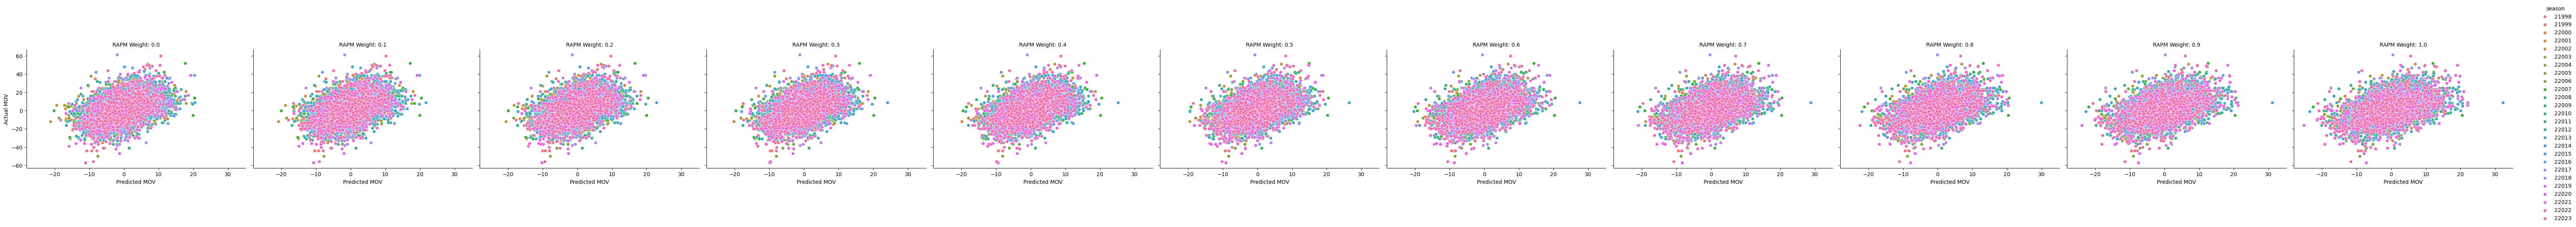

In [137]:
# Plot using seaborn
g = sns.FacetGrid(test_pivot7, col='rapm_weight', hue='season', height=4, aspect=1.5)
g.map(sns.scatterplot, 'pred_mov', 'mov')
g.add_legend()
g.set_axis_labels("Predicted MOV", "Actual MOV")
g.set_titles(col_template="RAPM Weight: {col_name}")
plt.show()

In [138]:
# Group by 'alpha' and 'season' and calculate error metrics
error_metrics7 = test_pivot7.groupby(['rapm_weight', 'season']).apply(calculate_error_metrics).reset_index()

best_params_per_season7 = error_metrics7.loc[error_metrics7.groupby('season')['RMSE'].idxmin()]

best_params_per_season7.head(10)

rapm_weight  season          MAPE       RMSE  R_squared
156          0.6   21998  7.957098e+14  12.217404   0.145474
157          0.6   21999  1.626618e+15  12.178549   0.151186
132          0.5   22000  1.204354e+15  11.079928   0.187599
185          0.7   22001  6.743903e+14  12.238085   0.124873
134          0.5   22002  1.348781e+15  12.586331   0.059444
161          0.6   22003  1.424460e+15  12.047721   0.038890
214          0.8   22004  1.433417e+15  11.980645   0.135930
137          0.5   22005  6.400127e+14  11.700285   0.092678
112          0.4   22006  1.369137e+15  12.314325   0.153222
9            0.0   22007  1.267101e+15  12.318405   0.210956

In [139]:
# Group by model, param_alpha, and param_l1_ratio
error_metrics_agg7 = error_metrics7.groupby(['rapm_weight']).agg(
    unique_seasons=('season', 'nunique'),
    avg_mape=('MAPE', 'mean'),
    avg_rmse=('RMSE', 'mean'),
    avg_r2=('R_squared', 'mean')
).sort_values(by='avg_rmse').reset_index()

error_metrics_agg7.head(10)

rapm_weight  unique_seasons      avg_mape   avg_rmse    avg_r2
0          0.5              26  1.151999e+15  12.574127  0.151084
1          0.4              26  1.131663e+15  12.577111  0.150700
2          0.6              26  1.177881e+15  12.586097  0.149432
3          0.3              26  1.117202e+15  12.595038  0.148278
4          0.7              26  1.209918e+15  12.612973  0.145744
5          0.2              26  1.110154e+15  12.627845  0.143820
6          0.8              26  1.248374e+15  12.654655  0.140019
7          0.1              26  1.108688e+15  12.675413  0.137326
8          0.9              26  1.292148e+15  12.710990  0.132258
9          0.0              26  1.112854e+15  12.737571  0.128795

In [140]:
# Determine actual and predicted winners
test_pivot7['actual_winner'] = test_pivot7['mov'].apply(lambda x: 'home' if x > 0 else 'away')
test_pivot7['predicted_winner'] = test_pivot7['pred_mov'].apply(lambda x: 'home' if x > 0 else 'away')

# Calculate if the prediction was correct
test_pivot7['correct_prediction'] = test_pivot7['actual_winner'] == test_pivot7['predicted_winner']

# Group by alpha and season and calculate summary statistics
pred_summary7 = test_pivot7.groupby(['rapm_weight']).agg(
    total_games=('game', 'size'),
    correct_predictions=('correct_prediction', 'sum')
).reset_index()

# Calculate the percentage of correct predictions
pred_summary7['percent_correct'] = (pred_summary7['correct_predictions'] / pred_summary7['total_games']) * 100

pred_summary7.sort_values(by='percent_correct', ascending=False).reset_index(drop=True).head(10)

rapm_weight  total_games  correct_predictions  percent_correct
0          0.5         5991                 3987        66.549825
1          0.3         5991                 3983        66.483058
2          0.4         5991                 3981        66.449675
3          0.7         5991                 3975        66.349524
4          0.6         5991                 3970        66.266066
5          0.2         5991                 3966        66.199299
6          0.8         5991                 3961        66.115840
7          0.1         5991                 3957        66.049074
8          0.9         5991                 3953        65.982307
9          1.0         5991                 3945        65.848773

### Plots/tables for final paper

<Figure size 1000x600 with 0 Axes>

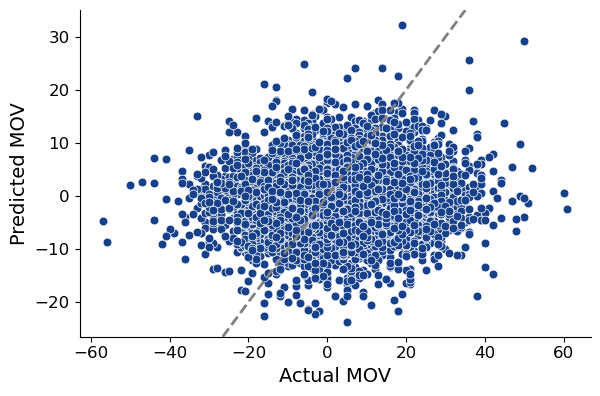

In [82]:
# Plot using seaborn
plot_data = test_pivot1.copy()
plot_data['season'] = plot_data['season']-20000
plot_data['decade'] = (plot_data['season'] // 10) * 10
plot_data['decade'] = plot_data['decade'].astype(str)+'s'

# Plotting
plt.figure(figsize=(10, 6))

g = sns.FacetGrid(plot_data, height=4, aspect=1.5)
g.map(sns.scatterplot, 'mov', 'pred_mov', color='#17408b', s=40)

for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, color='gray', linestyle='--', linewidth=2)
    ax.tick_params(labelsize=12)
    
# g.add_legend(title="Decade")        
g.set_axis_labels("Actual MOV", "Predicted MOV", fontsize=14)
# g.set_titles(col_template="RAPM, lambda={col_name}")
plt.show()

<Figure size 1000x600 with 0 Axes>

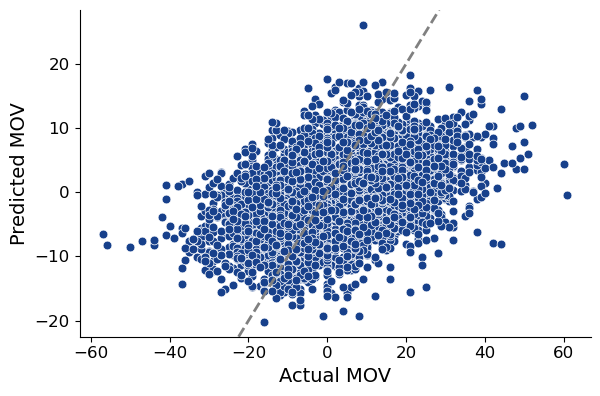

In [83]:
# Plot using seaborn
plot_data = test_pivot2[test_pivot2['alpha']==2000].copy()
plot_data['season'] = plot_data['season']-20000
plot_data['decade'] = (plot_data['season'] // 10) * 10
plot_data['decade'] = plot_data['decade'].astype(str)+'s'

# Plotting
plt.figure(figsize=(10, 6))

g = sns.FacetGrid(plot_data, height=4, aspect=1.5)
g.map(sns.scatterplot, 'mov', 'pred_mov', color='#17408b', s=40)

for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, color='gray', linestyle='--', linewidth=2)
    ax.tick_params(labelsize=12)
    
# g.add_legend(title="Decade")        
g.set_axis_labels("Actual MOV", "Predicted MOV", fontsize=14)
# g.set_titles(col_template="RAPM, lambda={col_name}")
plt.show()

In [145]:
## best model had 0 alpha and 1000 possession threshold
merged_df = pd.merge(player_stats, player_rapm[player_rapm['alpha'] == 100], on=['player_id', 'season'])

# Filter for seasons with at least min_threshold minutes played
merged_df = merged_df[merged_df['possessions'] >= 100].reset_index(drop=True)

# Select features and target
bpm_features = merged_df[['z_pts','z_fgm','z_fga','z_fg3m','z_fg3a','z_ftm','z_fta','z_oreb','z_dreb','z_ast','z_stl','z_blk','z_tov','z_pf']]
bpm_target = merged_df['rapm']

# Initialize linear regression model
bpm_model = LinearRegression()

bpm_model.fit(bpm_features, bpm_target)

bpm_coefficients = bpm_model.coef_
bpm_intercept = bpm_model.intercept_
coef_df = pd.DataFrame({
    'Feature': bpm_features.columns,
    'Coefficient': bpm_coefficients
})
coef_df.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

Feature  Coefficient
0    z_pts     0.048180
1    z_ast     0.013491
2    z_stl     0.011914
3   z_dreb     0.007635
4    z_ftm     0.004819
5    z_blk     0.004551
6   z_fg3a     0.004148
7   z_oreb     0.002826
8     z_pf     0.002292
9   z_fg3m     0.000718
10   z_fgm    -0.005638
11   z_fta    -0.012260
12   z_tov    -0.014525
13   z_fga    -0.025398

<Figure size 1000x600 with 0 Axes>

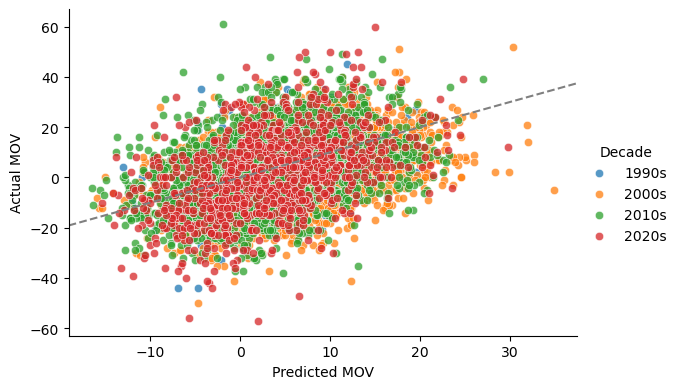

In [146]:
# Plot using seaborn
plot_data = test_pivot3[(test_pivot3['alpha']==0) & (test_pivot3['possession_threshold']==1000)].copy()
plot_data['season'] = plot_data['season']-20000
plot_data['decade'] = (plot_data['season'] // 10) * 10
plot_data['decade'] = plot_data['decade'].astype(str)+'s'

# Plotting
plt.figure(figsize=(10, 6))

g = sns.FacetGrid(plot_data, hue='decade', height=4, aspect=1.5)#, col_wrap=2)
g.map(sns.scatterplot, 'pred_mov', 'mov', alpha=0.75)

for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, color='gray', linestyle='--')
     
g.add_legend(title="Decade")        
g.set_axis_labels("Predicted MOV", "Actual MOV")
# g.set_titles(col_template="B-RAPM, lambda={col_name} & possessions>=1000")
plt.show()

In [147]:
advanced_df = advanced_stats[['gameId','personId','possessions', 'pace', 'assistPercentage', 'offensiveReboundPercentage', 'defensiveReboundPercentage', 'usagePercentage']]
box_df = box_score_stats[['GAME_ID','TEAM_ID','PLAYER_ID','MIN', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PTS']]

merged_df = pd.merge(box_df, advanced_df, left_on=['GAME_ID', 'PLAYER_ID'], right_on=['gameId', 'personId'])

merged_df.drop(['gameId', 'personId'], axis=1, inplace=True)

merged_df['GAME_ID'] = merged_df['GAME_ID'].apply(lambda x: f'00{x:06d}')

# Filter merged_df to include only games in train_df
season_games = lineups_df[['game', 'season']].drop_duplicates().reset_index(drop = True)
filtered_df = pd.merge(merged_df, season_games, left_on='GAME_ID', right_on='game', how='inner')

# Filter out players who didn't play (MIN is NaN)
filtered_df = filtered_df.dropna(subset=['MIN'])

In [148]:
# Aggregate data by player and season
player_stats = filtered_df.groupby(['PLAYER_ID', 'season']).agg(
    games=('GAME_ID', 'nunique'),
    possessions=('possessions', 'sum'),
    pts=('PTS', 'sum'),
    fgm=('FGM', 'sum'),
    fga=('FGA', 'sum'),
    fg3m=('FG3M', 'sum'),
    fg3a=('FG3A', 'sum'),
    ftm=('FTM', 'sum'),
    fta=('FTA', 'sum'),
    oreb=('OREB', 'sum'),
    dreb=('DREB', 'sum'),
    ast=('AST', 'sum'),
    stl=('STL', 'sum'),
    blk=('BLK', 'sum'),
    tov=('TO', 'sum'),
    pf=('PF', 'sum')
).reset_index()

# make all the columns lowercase
player_stats.columns = [x.lower() for x in player_stats.columns]

# Normalize stats per 100 possessions
player_stats['pts_per_100'] = (player_stats['pts'] / player_stats['possessions']) * 100
player_stats['fgm_per_100'] = (player_stats['fgm'] / player_stats['possessions']) * 100
player_stats['fga_per_100'] = (player_stats['fga'] / player_stats['possessions']) * 100
player_stats['fg3m_per_100'] = (player_stats['fg3m'] / player_stats['possessions']) * 100
player_stats['fg3a_per_100'] = (player_stats['fg3a'] / player_stats['possessions']) * 100
player_stats['ftm_per_100'] = (player_stats['ftm'] / player_stats['possessions']) * 100
player_stats['fta_per_100'] = (player_stats['fta'] / player_stats['possessions']) * 100
player_stats['oreb_per_100'] = (player_stats['oreb'] / player_stats['possessions']) * 100
player_stats['dreb_per_100'] = (player_stats['dreb'] / player_stats['possessions']) * 100
player_stats['ast_per_100'] = (player_stats['ast'] / player_stats['possessions']) * 100
player_stats['stl_per_100'] = (player_stats['stl'] / player_stats['possessions']) * 100
player_stats['blk_per_100'] = (player_stats['blk'] / player_stats['possessions']) * 100
player_stats['tov_per_100'] = (player_stats['tov'] / player_stats['possessions']) * 100
player_stats['pf_per_100'] = (player_stats['pf'] / player_stats['possessions']) * 100

# Standardize stats per season
season_avg = player_stats.groupby('season').agg(
    avg_pts_per_100=('pts_per_100', 'mean'),
    std_pts_per_100=('pts_per_100', 'std'),
    avg_fgm_per_100=('fgm_per_100', 'mean'),
    std_fgm_per_100=('fgm_per_100', 'std'),
    avg_fga_per_100=('fga_per_100', 'mean'),
    std_fga_per_100=('fga_per_100', 'std'),
    avg_fg3m_per_100=('fg3m_per_100', 'mean'),
    std_fg3m_per_100=('fg3m_per_100', 'std'),
    avg_fg3a_per_100=('fg3a_per_100', 'mean'),
    std_fg3a_per_100=('fg3a_per_100', 'std'),
    avg_ftm_per_100=('ftm_per_100', 'mean'),
    std_ftm_per_100=('ftm_per_100', 'std'),
    avg_fta_per_100=('fta_per_100', 'mean'),
    std_fta_per_100=('fta_per_100', 'std'),
    avg_oreb_per_100=('oreb_per_100', 'mean'),
    std_oreb_per_100=('oreb_per_100', 'std'),
    avg_dreb_per_100=('dreb_per_100', 'mean'),
    std_dreb_per_100=('dreb_per_100', 'std'),
    avg_ast_per_100=('ast_per_100', 'mean'),
    std_ast_per_100=('ast_per_100', 'std'),
    avg_stl_per_100=('stl_per_100', 'mean'),
    std_stl_per_100=('stl_per_100', 'std'),
    avg_blk_per_100=('blk_per_100', 'mean'),
    std_blk_per_100=('blk_per_100', 'std'),
    avg_tov_per_100=('tov_per_100', 'mean'),
    std_tov_per_100=('tov_per_100', 'std'),
    avg_pf_per_100=('pf_per_100', 'mean'),
    std_pf_per_100=('pf_per_100', 'std')
).reset_index()

player_stats = player_stats.merge(season_avg, on='season', how='left')
player_stats['z_pts'] = (player_stats['pts_per_100'] - player_stats['avg_pts_per_100']) / player_stats['std_pts_per_100']
player_stats['z_fgm'] = (player_stats['fgm_per_100'] - player_stats['avg_fgm_per_100']) / player_stats['std_fgm_per_100']
player_stats['z_fga'] = (player_stats['fga_per_100'] - player_stats['avg_fga_per_100']) / player_stats['std_fga_per_100']
player_stats['z_fg3m'] = (player_stats['fg3m_per_100'] - player_stats['avg_fg3m_per_100']) / player_stats['std_fg3m_per_100']
player_stats['z_fg3a'] = (player_stats['fg3a_per_100'] - player_stats['avg_fg3a_per_100']) / player_stats['std_fg3a_per_100']
player_stats['z_ftm'] = (player_stats['ftm_per_100'] - player_stats['avg_ftm_per_100']) / player_stats['std_ftm_per_100']
player_stats['z_fta'] = (player_stats['fta_per_100'] - player_stats['avg_fta_per_100']) / player_stats['std_fta_per_100']
player_stats['z_oreb'] = (player_stats['oreb_per_100'] - player_stats['avg_oreb_per_100']) / player_stats['std_oreb_per_100']
player_stats['z_dreb'] = (player_stats['dreb_per_100'] - player_stats['avg_dreb_per_100']) / player_stats['std_dreb_per_100']
player_stats['z_ast'] = (player_stats['ast_per_100'] - player_stats['avg_ast_per_100']) / player_stats['std_ast_per_100']
player_stats['z_stl'] = (player_stats['stl_per_100'] - player_stats['avg_stl_per_100']) / player_stats['std_stl_per_100']
player_stats['z_blk'] = (player_stats['blk_per_100'] - player_stats['avg_blk_per_100']) / player_stats['std_blk_per_100']
player_stats['z_tov'] = (player_stats['tov_per_100'] - player_stats['avg_tov_per_100']) / player_stats['std_tov_per_100']
player_stats['z_pf'] = (player_stats['pf_per_100'] - player_stats['avg_pf_per_100']) / player_stats['std_pf_per_100']

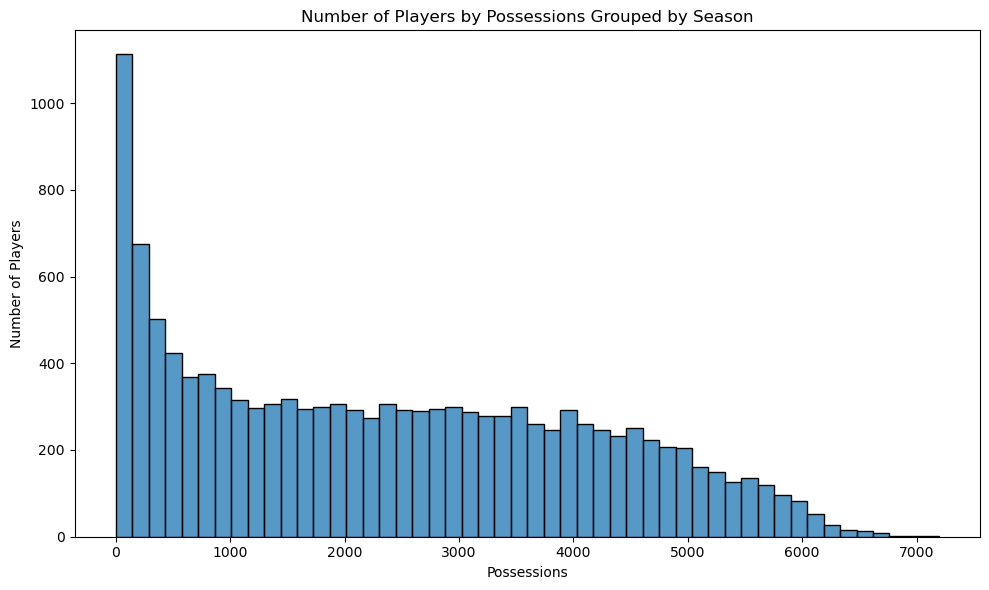

In [149]:
plot_data = player_stats.copy()

plot_data['season'] = plot_data['season']-20000
plot_data['decade'] = (plot_data['season'] // 10) * 10
plot_data['decade'] = plot_data['decade'].astype(str)+'s'

# Create the histogram grouped by 'season' with 'possessions' on the x-axis
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data, x='possessions', kde=False, bins=50, multiple="dodge")
# Add labels and title
plt.xlabel('Possessions')
plt.ylabel('Number of Players')
plt.title('Number of Players by Possessions Per Season')
# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

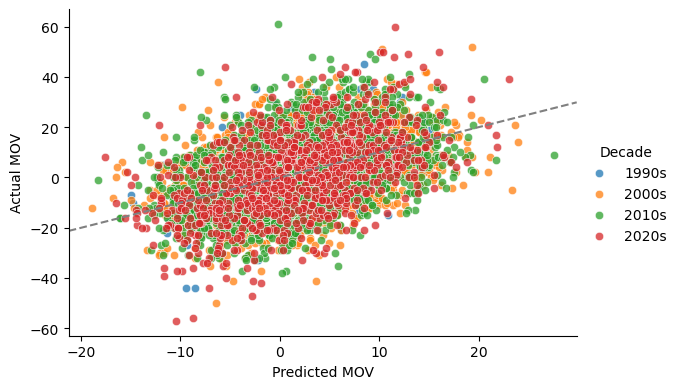

In [152]:
# Plot using seaborn
plot_data = test_pivot4[(test_pivot4['weight']==0.5) & (test_pivot4['alpha_x']==2000) & (test_pivot4['alpha_y']==0) & (test_pivot4['possession_threshold']==100)].copy()
plot_data['season'] = plot_data['season']-20000
plot_data['decade'] = (plot_data['season'] // 10) * 10
plot_data['decade'] = plot_data['decade'].astype(str)+'s'

# Plotting
plt.figure(figsize=(10, 6))

g = sns.FacetGrid(plot_data, hue='decade', height=4, aspect=1.5)#, col_wrap=2)
g.map(sns.scatterplot, 'pred_mov', 'mov', alpha=0.75)

for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, color='gray', linestyle='--')
     
g.add_legend(title="Decade")        
g.set_axis_labels("Predicted MOV", "Actual MOV")
# g.set_titles(col_template="S-RAPM, 50% RAPM + 50% B-RAPM")
plt.show()

In [153]:
# Sort the DataFrame by rapm
df_sorted = lineup_rapm[lineup_rapm['alpha']==500].sort_values(by='rapm', ascending=False).reset_index(drop=True)

df_sorted['Season'] = df_sorted['season']-20000
df_sorted['orapm'] = df_sorted['orapm']*100
df_sorted['drapm'] = df_sorted['drapm']*100
df_sorted['rapm'] = df_sorted['rapm']*100
df_sorted['ORAPM'] = df_sorted['orapm'].apply(lambda x: f"+{x:.1f}" if x > 0 else f"{x:.1f}" if x == 0 else f"-{abs(x):.1f}")
df_sorted['DRAPM'] = df_sorted['drapm'].apply(lambda x: f"+{x:.1f}" if x > 0 else f"{x:.1f}" if x == 0 else f"-{abs(x):.1f}")
df_sorted['RAPM'] = df_sorted['rapm'].apply(lambda x: f"+{x:.1f}" if x > 0 else f"{x:.1f}" if x == 0 else f"-{abs(x):.1f}")
df_sorted['Rank'] = df_sorted.index+1
df_sorted['Player 1'] = df_sorted['player1']
df_sorted['Player 2'] = df_sorted['player2']
df_sorted['Player 3'] = df_sorted['player3']
df_sorted['Player 4'] = df_sorted['player4']
df_sorted['Player 5'] = df_sorted['player5']

df_sorted[['Rank','Season','Player 1','Player 2','Player 3','Player 4','Player 5','ORAPM','DRAPM','RAPM']].head(10).reset_index(drop=True)

NameError: name 'lineup_rapm' is not defined

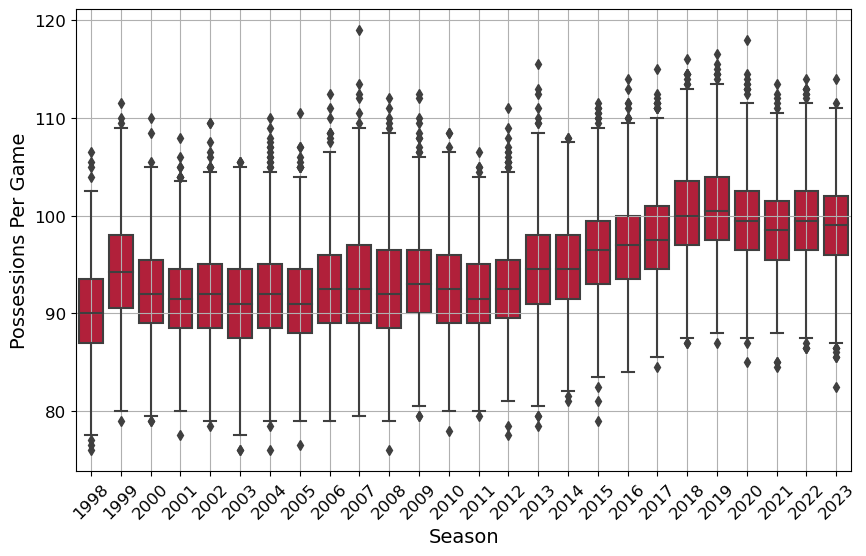

In [178]:
# Step 1: Group by 'game' and find the max 'game_possession'
max_game_possession = lineups_df.groupby('game')['game_possession'].max().reset_index()

# Step 2: Merge the max game possession back with the season information
max_game_possession = max_game_possession.merge(lineups_df[['game', 'season']].drop_duplicates(), on='game')

max_game_possession['season'] = max_game_possession['season']-20000 
max_game_possession['game_possession'] = max_game_possession['game_possession']/2
# Step 3: Create a box and whisker plot for game_possession by season
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='game_possession', data=max_game_possession, color='#C9082A')
# plt.title('League Pace')
plt.xlabel('Season', fontsize=14)
plt.ylabel('Possessions Per Game', fontsize=14)
plt.xticks(rotation=45)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()

In [ ]:
player_rapm.head(5)

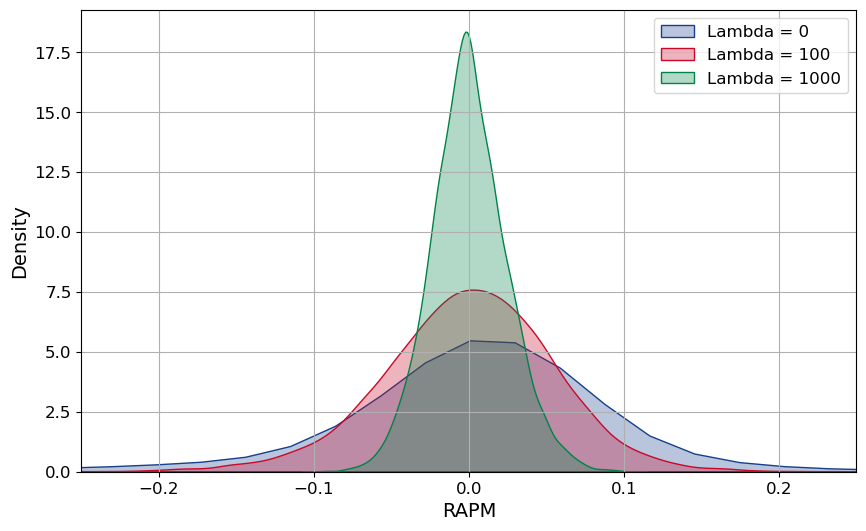

In [201]:
# Filter the DataFrame for alpha=0 and alpha=10000
df_alpha_0 = player_rapm[player_rapm['alpha'] == 0]
df_alpha_100 = player_rapm[player_rapm['alpha'] == 100]
df_alpha_1000 = player_rapm[player_rapm['alpha'] == 1000]
df_alpha_2000 = player_rapm[player_rapm['alpha'] == 2000]

# Plot the density and histogram
plt.figure(figsize=(10, 6))

# Density plots
sns.kdeplot(df_alpha_0['rapm'], label='Lambda = 0', fill=True, color='#17408b', alpha=0.3)
sns.kdeplot(df_alpha_100['rapm'], label='Lambda = 100', fill=True, color='#c9082a', alpha=0.3)
sns.kdeplot(df_alpha_1000['rapm'], label='Lambda = 1000', fill=True, color='#008347', alpha=0.3)
# sns.kdeplot(df_alpha_2000['rapm'], label='Lambda = 2000', fill=True, color='#f58522', alpha=0.3)

# Histogram plots
# plt.hist(df_alpha_0['rapm'], bins=50, alpha=0.3, color='blue', density=True)
# plt.hist(df_alpha_10000['rapm'], bins=20, alpha=0.3, color='red', density=True)

plt.xlim(-.25,.25)
# Customize the plot
plt.xlabel('RAPM', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.title('Density and Histogram of RAPM for Alpha = 0 and Alpha = 10000')
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()

In [ ]:
df_alpha_10000.sort_values(by='rapm')

In [211]:
# Merge the tables on 'player_id'
merge_pm = player_rapm[player_rapm['alpha']==2000][['player_id','player_name','season','rapm']].merge(
    player_bpm[(player_bpm['alpha']==100) & (player_bpm['possession_threshold']==100)][['player_id','season','bpm']], on=['player_id','season']).merge(
    player_spm[(player_spm['rapm_weight']==0.5) & (player_spm['alpha_x']==1000) & (player_spm['alpha_y']==100) & (player_spm['possession_threshold']==100)][['player_id','season','ospm','dspm']], on=['player_id','season'])
# Create new columns for the differences
merge_pm['spm'] = merge_pm['ospm'] + merge_pm['dspm']
merge_pm['rapm_minus_bpm'] = merge_pm['rapm'] - merge_pm['bpm']
merge_pm['rapm_minus_spm'] = merge_pm['rapm'] - merge_pm['spm']
merge_pm['bpm_minus_spm'] = merge_pm['bpm'] - merge_pm['spm']
merge_pm = merge_pm.drop(['ospm','dspm'], axis=1)

In [212]:
merge_pm.sort_values(by='spm', ascending=False)

player_id      player_name  season      rapm       bpm       spm  \
4058     101108       Chris Paul   22008  0.065596  0.109332  0.101444   
7200     201939    Stephen Curry   22015  0.074045  0.109314  0.099974   
4370       2544     LeBron James   22008  0.072780  0.089873  0.093547   
1651       1717    Dirk Nowitzki   22002  0.072063  0.074995  0.085177   
4789       2544     LeBron James   22009  0.057517  0.090722  0.085171   
...         ...              ...     ...       ...       ...       ...   
6462     203136    Ognjen Kuzmic   22013 -0.018219 -0.106900 -0.069341   
8571    1629014  Anfernee Simons   22018 -0.010907 -0.124409 -0.070689   
5342       1716     Larry Hughes   22011 -0.024660 -0.110117 -0.076304   
4738       2201       Eddy Curry   22009 -0.008052 -0.151193 -0.083267   
1778       2213      Kirk Haston   22002 -0.013501 -0.141546 -0.083663   

      rapm_minus_bpm  rapm_minus_spm  bpm_minus_spm  
4058       -0.043736       -0.035848       0.007888  
7200       -0.035269       -0.025929       0.009340  
4370       -0.017093       -0.020767      -0.003674  
1651       -0.002932       -0.013114      -0.010182  
4789       -0.033205       -0.027654       0.005551  
...              ...             ...            ...  
6462        0.088681        0.051121      -0.037560  
8571        0.113502        0.059782      -0.053720  
5342        0.085457        0.051644      -0.033813  
4738        0.143141        0.075214      -0.067927  
1778        0.128044        0.070162      -0.057883  

[11225 rows x 9 columns]

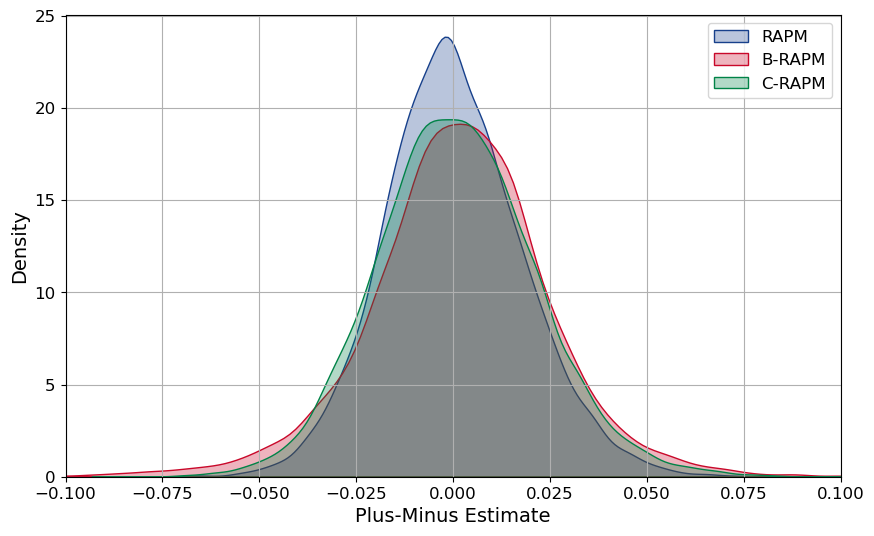

In [214]:
# Plot the density and histogram
plt.figure(figsize=(10, 6))

# Density plots
sns.kdeplot(merge_pm['rapm'], label='RAPM', fill=True, color='#17408b', alpha=0.3)
sns.kdeplot(merge_pm['bpm'], label='B-RAPM', fill=True, color='#c9082a', alpha=0.3)
sns.kdeplot(merge_pm['spm'], label='C-RAPM', fill=True, color='#008347', alpha=0.3)

# Histogram plots
# plt.hist(df_alpha_0['rapm'], bins=50, alpha=0.3, color='blue', density=True)
# plt.hist(df_alpha_10000['rapm'], bins=20, alpha=0.3, color='red', density=True)

plt.xlim(-.1,.1)
# Customize the plot
plt.xlabel('Plus-Minus Estimate', fontsize=14)
plt.ylabel('Density', fontsize=14)
# plt.title('Density and Histogram of RAPM for Alpha = 0 and Alpha = 10000')
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.grid(True)
plt.show()

In [ ]:
merge_pm.sort_values(by='rapm_minus_bpm', ascending=False).head(20)

In [217]:
# Sort the DataFrame by rapm
df_sorted = merge_pm[((merge_pm['player_name']=='Tony Snell') & (merge_pm['season']==22015)) |
                    ((merge_pm['player_name']=='George Hill') & (merge_pm['season']==22021)) |
                    ((merge_pm['player_name']=='Manu Ginobili') & (merge_pm['season']==22008)) |
                    ((merge_pm['player_name']=='James Harden') & (merge_pm['season']==22018)) |
                    ((merge_pm['player_name']=='Eddy Curry') & (merge_pm['season']==22007)) |
                    ((merge_pm['player_name']=='Kevin Knox II') & (merge_pm['season']==22018)) |
                    ((merge_pm['player_name']=='Stephen Curry') & (merge_pm['season']==22015)) |
                    ((merge_pm['player_name']=='LeBron James') & (merge_pm['season']==22008)) |
                    ((merge_pm['player_name']=='Jahlil Okafor') & (merge_pm['season']==22015)) |
                    ((merge_pm['player_name']=='Lamar Odom') & (merge_pm['season']==22008))].sort_values(by='spm', ascending=False).reset_index(drop=True)

df_sorted['Season'] = df_sorted['season']-20000
df_sorted['rapm'] = df_sorted['rapm']*100
df_sorted['bpm'] = df_sorted['bpm']*100
df_sorted['spm'] = df_sorted['spm']*100
df_sorted['RAPM'] = df_sorted['rapm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['B-RAPM'] = df_sorted['bpm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['C-RAPM'] = df_sorted['spm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['Rank'] = df_sorted.index+1
df_sorted['Player'] = df_sorted['player_name']

df_sorted[['Player','Season','RAPM','B-RAPM','C-RAPM']].head(25).reset_index(drop=True)

Player  Season   RAPM  B-RAPM  C-RAPM
0  Stephen Curry    2015  +7.40  +10.93  +10.00
1   LeBron James    2008  +7.28   +8.99   +9.35
2   James Harden    2018  +1.67   +7.53   +4.92
3     Lamar Odom    2008  +5.91   +1.40   +4.49
4    George Hill    2021  +6.30   -0.23   +4.45
5  Manu Ginobili    2008  -0.02   +6.55   +3.16
6     Tony Snell    2015  +3.59   -2.99   +1.00
7  Jahlil Okafor    2015  -6.35   -1.80   -4.85
8  Kevin Knox II    2018  -5.60   -3.29   -5.24
9     Eddy Curry    2007  -6.76   -3.55   -6.25

In [220]:
# Sort the DataFrame by rapm
df_sorted = player_rapm[player_rapm['alpha']==2000].sort_values(by='rapm', ascending=False).reset_index(drop=True)

df_sorted['season'] = df_sorted['season']-20000
df_sorted['orapm'] = df_sorted['orapm']*100
df_sorted['drapm'] = df_sorted['drapm']*100
df_sorted['rapm'] = df_sorted['rapm']*100
df_sorted['orapm'] = df_sorted['orapm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['drapm'] = df_sorted['drapm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['rapm'] = df_sorted['rapm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['rank'] = df_sorted.index+1

df_sorted[['rank','season','player_name','orapm','drapm','rapm']].head(10).reset_index(drop=True)

rank  season       player_name  orapm  drapm   rapm
0     1    2015    Draymond Green  +4.98  +2.73  +7.70
1     2    2015     Stephen Curry  +5.58  +1.82  +7.40
2     3    2008      LeBron James  +4.47  +2.81  +7.28
3     4    2002     Dirk Nowitzki  +3.99  +3.22  +7.21
4     5    2002     Kevin Garnett  +4.08  +2.90  +6.98
5     6    2010     Dirk Nowitzki  +5.99  +0.81  +6.80
6     7    2018      Kevin Durant  +4.80  +1.98  +6.78
7     8    2001        Ryan Bowen  +2.68  +4.04  +6.73
8     9    2001  Andrei Kirilenko  +2.38  +4.26  +6.64
9    10    2008        Chris Paul  +4.22  +2.34  +6.56

In [221]:
# Sort the DataFrame by bpm
df_sorted = player_bpm[(player_bpm['alpha']==0) & (player_bpm['possession_threshold']==1000)].sort_values(by='bpm', ascending=False).reset_index(drop=True)

df_sorted['season'] = df_sorted['season']-20000
df_sorted['obpm'] = df_sorted['obpm']*100
df_sorted['dbpm'] = df_sorted['dbpm']*100
df_sorted['bpm'] = df_sorted['bpm']*100
df_sorted['obpm'] = df_sorted['obpm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['dbpm'] = df_sorted['dbpm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['bpm'] = df_sorted['bpm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['rank'] = df_sorted.index+1

df_sorted[['rank','season','player_name','obpm','dbpm','bpm']].head(10).reset_index(drop=True)

rank  season    player_name    obpm   dbpm     bpm
0     1    2015  Stephen Curry  +12.85  +1.39  +14.24
1     2    2008     Chris Paul   +8.84  +5.21  +14.06
2     3    2007     Chris Paul   +8.49  +4.67  +13.15
3     4    2012     Chris Paul   +8.14  +4.82  +12.95
4     5    2011     Chris Paul   +8.18  +3.48  +11.67
5     6    2016     Chris Paul   +7.72  +3.81  +11.53
6     7    2009     Chris Paul   +8.21  +3.28  +11.49
7     8    2010     Chris Paul   +6.47  +4.95  +11.42
8     9    2009   LeBron James   +9.41  +1.91  +11.32
9    10    2013     Chris Paul   +7.80  +3.44  +11.24

In [228]:
# Sort the DataFrame by C-RAPM
player_spm['spm'] = player_spm['ospm'] + player_spm['dspm']
df_sorted = player_spm[(player_spm['rapm_weight']==0.5) & (player_spm['alpha_x']==1000) & (player_spm['alpha_y']==100) & (player_spm['possession_threshold']==100) & (player_spm['possessions']>=0)].sort_values(by='spm', ascending=False).reset_index(drop=True)

df_sorted['Season'] = df_sorted['season']-20000
df_sorted['ospm'] = df_sorted['ospm']*100
df_sorted['dspm'] = df_sorted['dspm']*100
df_sorted['spm'] = df_sorted['spm']*100
df_sorted['C-ORAPM'] = df_sorted['ospm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['C-DRAPM'] = df_sorted['dspm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['C-RAPM'] = df_sorted['spm'].apply(lambda x: f"+{x:.2f}" if x > 0 else f"{x:.2f}" if x == 0 else f"-{abs(x):.2f}")
df_sorted['Rank'] = df_sorted.index+1
df_sorted['Player'] = df_sorted['player_name']

df_sorted[['Rank','Player','Season','C-ORAPM','C-DRAPM','C-RAPM']].head(10).reset_index(drop=True)

Rank         Player  Season C-ORAPM C-DRAPM  C-RAPM
0     1     Chris Paul    2008   +6.48   +3.66  +10.14
1     2  Stephen Curry    2015   +8.57   +1.43  +10.00
2     3   LeBron James    2008   +6.59   +2.77   +9.35
3     4  Dirk Nowitzki    2002   +4.99   +3.53   +8.52
4     5   LeBron James    2009   +6.80   +1.71   +8.52
5     6  Stephen Curry    2014   +6.06   +2.24   +8.30
6     7    Dwyane Wade    2008   +6.04   +2.18   +8.22
7     8  Kevin Garnett    2002   +4.99   +3.13   +8.12
8     9     Chris Paul    2013   +4.65   +3.25   +7.89
9    10     Chris Paul    2011   +6.03   +1.79   +7.82

In [ ]:
# view how many lineups are used on average per game for home and away

In [87]:
lineups_df['home_lineup'] = lineups_df['players'].apply(lambda x: tuple(sorted(x[:5])))
lineups_df['away_lineup'] = lineups_df['players'].apply(lambda x: tuple(sorted(x[5:])))

In [88]:
# Group by game and perform the required aggregations
lineups_by_game = lineups_df.groupby('game').agg(
    unique_home_lineup_count=('home_lineup', pd.Series.nunique),
    unique_away_lineup_count=('away_lineup', pd.Series.nunique)
).reset_index()

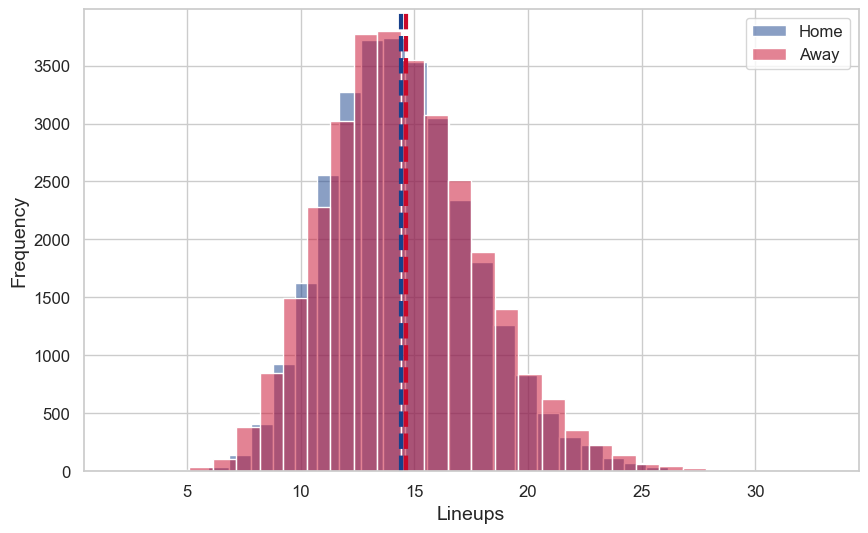

In [89]:
# Set the style for seaborn
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the histogram for unique_home_lineup_count
sns.histplot(lineups_by_game['unique_home_lineup_count'], bins=29, kde=False, color='#17408b', label='Home', alpha=0.5)

# Plot the histogram for unique_away_lineup_count
sns.histplot(lineups_by_game['unique_away_lineup_count'], bins=30, kde=False, color='#c9082a', label='Away', alpha=0.5)

# Add vertical lines for the means
mean_home = lineups_by_game['unique_home_lineup_count'].mean()
mean_away = lineups_by_game['unique_away_lineup_count'].mean()
plt.axvline(mean_home, color='#17408b', linestyle='dashed', linewidth=3)#, label=f'Mean Home Lineup Count: {mean_home:.2f}')
plt.axvline(mean_away, color='#c9082a', linestyle='dashed', linewidth=3)#, label=f'Mean Away Lineup Count: {mean_away:.2f}')

# Add titles and labels
# plt.title('Histogram of Unique Home and Away Lineup Counts')
plt.xlabel('Lineups', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

# Show the plot
plt.show()

#### Export and import BPM model

In [229]:
player_spm[(player_spm['rapm_weight']==0.5) & (player_spm['alpha_x']==1000) & (player_spm['alpha_y']==100) & (player_spm['possession_threshold']==100)].to_csv('best_model_predictions.csv', index=False)

In [ ]:
import joblib

# Save the model to a file
joblib.dump(model, 'box_score_rapm_model.pkl')

In [ ]:
# Load the model from the file
loaded_model = joblib.load('linear_regression_model.pkl')

In [ ]:
from tabulate import tabulate
# Generate the table in APA style
formatted_table = tabulate(merge_pm.sort_values(by='bpm_minus_spm', ascending=False).head(5), headers='keys', tablefmt='grid', showindex=False)
# Print the formatted table
print(formatted_table)

In [45]:
pd.set_option('display.max_columns', 100)

In [61]:
pd.set_option('display.max_rows', 1000)